In [2]:
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import scipy as sc

In [3]:
import matplotlib.animation as animation

In [ ]:
mpl.use("pgf")
#plt.rcParams['text.latex.unicode'] = True
plt.rcParams.update({
    "pgf.texsystem":   "pdflatex", # or any other engine you want to use
    "text.usetex":     True,       # use TeX for all texts
    "font.family":     "serif",
    "font.serif":      [],         # empty entries should cause the usage of the document fonts
    "font.sans-serif": [],
    "font.monospace":  [],
    "font.size":       10,         # control font sizes of different elements
    "axes.labelsize":  10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "pgf.preamble": [              # specify additional preamble calls for LaTeX's run
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{siunitx}",
        r"\usepackage[utf8]{inputenc}",
        r"\DeclareUnicodeCharacter{2212}{-}",
    ],
})

In [4]:
from tqdm.notebook import tqdm

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [6]:
from matplotlib.collections import LineCollection

In [7]:
from sympy import symbols, Symbol, expand, collect,sqrt,factor,fraction, diff, elliptic_e, elliptic_k, \
simplify,Poly,lambdify,series, cancel, Matrix
from sympy.parsing.mathematica import parse_mathematica as prsmat
x = symbols('x')

In [8]:
np.seterr('ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [9]:
### parse field expression ###
P,P1,P2,P3,P4 = symbols('P P1 P2 P3 P4')
Z,Z1,Z2,Z3,Z4 = symbols('Z Z1 Z2 Z3 Z4')
H1_wol_str = '(P2 Z1-P1 Z2)/(P1^2+Z1^2)^(3/2)'
H1_wol = prsmat(H1_wol_str)
H1_wol_lam = lambdify([P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4], H1_wol)
H2_wol_str = '-(Z1/(P Sqrt[P1^2+Z1^2]))'
H2_wol = prsmat(H2_wol_str)
H2_wol_lam = lambdify([P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4], H2_wol)


laplH1_wol_str='(1/(P (P1^2+Z1^2)^(9/2)))(-P1^6 Z3+P1^2 Z1 (3 P P2 (5 P2^2-13 Z2^2)+Z1^2 (-3 P2^2+2 P P4+3 Z2^2)-Z1^3 Z3+2 P Z1 (-P3 Z2+P2 Z3))+P1^4 (Z1 (-3 P2^2+P P4+3 Z2^2)-2 Z1^2 Z3+2 P (2 P3 Z2+3 P2 Z3))+P Z1^3 (-3 P2^3+Z1 (P4 Z1-6 P3 Z2)+P2 (15 Z2^2-4 Z1 Z3))+P1^5 (P3 Z1+3 P2 Z2-P Z4)+P1 Z1^2 (P3 Z1^3+3 P Z2 (13 P2^2-5 Z2^2)+10 P Z1 (-P2 P3+Z2 Z3)-Z1^2 (3 P2 Z2+P Z4))+P1^3 (2 P3 Z1^3+P (-10 P2 P3 Z1-15 P2^2 Z2+3 Z2^3+10 Z1 Z2 Z3-2 Z1^2 Z4)))'
laplH1_wol = prsmat(laplH1_wol_str)
laplH1_wol_lam = lambdify([P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4], laplH1_wol)
laplH2_wol_str='(1/(P^3 (P1^2+Z1^2)^(7/2)))(-P1^6 Z1+P P2 Z1^3 (P P2+Z1^2)+P P1^5 Z2+P^2 P1^3 (P3 Z1+3 P2 Z2)+P P1 Z1^2 (P P3 Z1-(5 P P2+Z1^2) Z2)-P1^4 (P P2 Z1+2 Z1^3+P^2 Z3)-P1^2 Z1 (Z1^4+P^2 (3 P2^2-4 Z2^2)+P^2 Z1 Z3))'
laplH2_wol = prsmat(laplH2_wol_str)
laplH2_wol_lam = lambdify([P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4], laplH2_wol)

In [10]:
def get_ext_array(arr, tp='z'):
    n_arr = len(arr)-1
    ext_arr = np.zeros(2*n_arr)
    ext_arr[0:n_arr+1]=arr
    if tp=='p':
        ext_arr[n_arr+1:]=-arr[::-1][1:-1:]
    else:
        ext_arr[n_arr+1:]=arr[::-1][1:-1:]
    return ext_arr

In [11]:
#%run G_define.ipynb

In [11]:
### on the axis ###
def D_z_axis_part(z_,rho1_):
    return -2*np.pi*rho1_*z_*(rho1_**2-2*z_**2)/(rho1_**2+z_**2)**(5/2)
def D_rho_axis_part(z_,rho1_):
    return 2*np.pi*rho1_**2*(rho1_**2-2*z_**2)/(rho1_**2+z_**2)**(5/2)

In [12]:
import numdifftools as nd 

## setting

In [14]:
N=80

j_N = np.arange(N+1)
tau_N = j_N/N


n_int = 340
N_int = n_int*10

Tau_int = np.arange(N_int+1)/(N_int)
tau_int = np.arange(n_int+1)/(n_int)

dtau_int = tau_int.reshape(-1,1) - Tau_int.reshape(1,-1) 

In [15]:
weights_simp1 = np.zeros_like(Tau_int)
weights_simp2 = np.zeros_like(Tau_int)

weights_simp1 +=1
weights_simp1[0]=1/2; weights_simp1[-1]=1/2

weights_simp2[::2] +=1
weights_simp2[::2][0]=1/2; weights_simp2[::2][-1]=1/2

weights_simp = 4/3*weights_simp1 - 2/3*weights_simp2
weights_simp /= N_int

In [16]:
Kron = (np.abs(dtau_int)<1e-6)
AKron = ~Kron

In [38]:
def get_int_field(field_rfft):
    """
    Returns N_int points of field by furier transphorm from `field_fur`
    """
    field_int = np.fft.irfft(field_rfft, norm='forward', n=2*N_int)
    return field_int[0:N_int+1]

def get_rfft_N_field(field):
    """
    Returns rfft of filed
    up to N harmonics
    """
    field_rfft=np.fft.rfft(field, norm='forward')
    return field_rfft[0:N]

def get_int_fields(field_rfft):
    """
    Returns N_int points of field and 4 derivatives by furier transphorm from `field_fur`
    """

    field_int = np.fft.irfft(field_rfft, norm='forward', n=2*N_int)
    der_oper = 1j*np.pi*np.arange(field_rfft.shape[0])
    field_1_int = np.fft.irfft(field_rfft*der_oper, norm='forward', n=2*N_int)
    field_2_int = np.fft.irfft(field_rfft*der_oper**2, norm='forward', n=2*N_int)
    field_3_int = np.fft.irfft(field_rfft*der_oper**3, norm='forward', n=2*N_int)
    field_4_int = np.fft.irfft(field_rfft*der_oper**4, norm='forward', n=2*N_int)
    return field_int[0:N_int+1], field_1_int[0:N_int+1], \
           field_2_int[0:N_int+1], field_3_int[0:N_int+1],field_4_int[0:N_int+1]

In [39]:
def get_VolSqr(P_fur, Z_fur):    
    ### find fields ###
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)    
    V = np.sqrt(P1**2+Z1**2)  
    Sqr = np.sum(2*np.pi * V*P *weights_simp)
    Vol= np.sum(-np.pi * P**2*Z1*weights_simp)
    V_cal = Vol/4/np.pi*3/(Sqr/4/np.pi)**(3/2)
    return Vol, Sqr, V_cal

In [40]:
from numpy import sqrt as Sqrt

In [41]:
def List(*a):
    return np.array(a)


def get_G_tilde_KE(rho, z, rho1):
    return List(List(List((2*
            (rho**2 + rho1**2 + 2*z**2))/
          (rho*Sqrt((rho - rho1)**2 + z**2)),
         (2*rho1*z)/
          (rho*Sqrt((rho - rho1)**2 + z**2))),
        List((-2*z)/Sqrt((rho - rho1)**2 + z**2),
         (4*rho1)/Sqrt((rho - rho1)**2 + z**2))),
       List(List((-2*
            ((rho**2 - rho1**2)**2 + 
              (3*rho**2 + 3*rho1**2)*z**2 + 
              2*z**4))/
          (rho*Sqrt((rho - rho1)**2 + z**2)*
            ((rho + rho1)**2 + z**2)),
         (-2*rho1*z*(-rho**2 + rho1**2 + z**2))/
          (rho*Sqrt((rho - rho1)**2 + z**2)*
            ((rho + rho1)**2 + z**2))),
        List((2*z*(rho**2 - rho1**2 + z**2))/
          (Sqrt((rho - rho1)**2 + z**2)*
            ((rho + rho1)**2 + z**2)),
         (4*rho1*z**2)/
          (Sqrt((rho - rho1)**2 + z**2)*
            ((rho + rho1)**2 + z**2)))))

In [42]:
from numba import njit, vectorize

In [43]:
@njit
def get_G_tilde_KE_numba(rho, z, rho1):
    
    ### K part ###
    factor_K = 2/Sqrt((rho - rho1)**2 + z**2)
    
    arr_K_0_0 = (rho**2 + rho1**2 + 2*z**2)/rho
    arr_K_0_1 = (rho1*z)/rho
    arr_K_1_0 = -z
    arr_K_1_1 = 2*rho1
    arr_K_0_0 *= factor_K ;arr_K_0_1 *= factor_K;
    arr_K_1_0 *= factor_K ;arr_K_1_1 *= factor_K;
    
    arr_K = [[arr_K_0_0,arr_K_0_1],
            [arr_K_1_0, arr_K_1_1]]
    
    ### E part ###
    factor_E = -2/(Sqrt((rho - rho1)**2 + z**2)*((rho + rho1)**2 + z**2))
    
    arr_E_0_0 =((rho**2 - rho1**2)**2 + 3*(rho**2 + rho1**2)*z**2 + 2*z**4)/rho
    arr_E_0_1 =(rho1*z*(-rho**2 + rho1**2 + z**2))/rho
    arr_E_1_0 =-(z*(rho**2 - rho1**2 + z**2))
    arr_E_1_1 =-2*rho1*z**2
    
    arr_E_0_0 *= factor_E ;arr_E_0_1 *= factor_E;
    arr_E_1_0 *= factor_E ;arr_E_1_1 *= factor_E;
    
    arr_E = [[arr_E_0_0,arr_E_0_1],
            [arr_E_1_0, arr_E_1_1]]
    
    return [arr_K,arr_E]

In [44]:
print('Checking equality')
print(np.allclose(get_G_tilde_KE(0.2,3,5.),
np.array(get_G_tilde_KE_numba(0.2,3,5.))))

test_arr = np.linspace(1,2,10)
res = get_G_tilde_KE(test_arr, test_arr*2,test_arr)
res_numba = np.array(get_G_tilde_KE_numba(
    test_arr, test_arr*2,test_arr))
print(np.allclose(res, res_numba))

test_arr = np.linspace(1,2,10).reshape(2,-1)
res = get_G_tilde_KE(test_arr, test_arr*2,test_arr)
res_numba = np.array(get_G_tilde_KE_numba(
    test_arr, test_arr*2,test_arr))
print(np.allclose(res, res_numba))

Checking equality
True
True
True


In [45]:
get_G_tilde_KE = get_G_tilde_KE_numba

In [46]:
def get_drho_G_tilde_KE(rho, z, rho1):
    return List(List(List((-2*((-(rho**2*rho1) + rho1**3)**2 + 
              (3*rho**4 - 3*rho**2*rho1**2 + 4*rho1**4)*z**2 + 5*(rho**2 + rho1**2)*z**4 + 2*z**6))/
          (rho**2*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)),
         (2*rho1*z*(-(rho + rho1)**2 - z**2)*
            ((rho**2 - rho1**2)**2 + 2*(2*rho**2 + rho1**2)*z**2 + z**4))/
          (rho**2*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2)),
        List((2*z*((rho**2 - rho1**2)**2 + (rho**2 + rho1**2)*z**2))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)),
         (2*rho1*(-(rho + rho1)**2 - z**2)*
            ((rho**2 - rho1**2)**2 + (rho**2 + 3*rho1**2)*z**2 + 2*z**4))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2))),
       List(List((2*(rho1**2*(-rho**2 + rho1**2)**3 + 
              (3*rho**6 + 3*rho**4*rho1**2 - 11*rho**2*rho1**4 + 5*rho1**6)*z**2 + 
              (8*rho**4 - rho**2*rho1**2 + 9*rho1**4)*z**4 + 7*(rho**2 + rho1**2)*z**6 + 2*z**8))/
          (rho**2*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2),
         (2*rho1*z*(-3*rho**6 + 7*rho**4*rho1**2 - 5*rho**2*rho1**4 + rho1**6 + 
              (3*rho**4 + 2*rho**2*rho1**2 + 3*rho1**4)*z**2 + (7*rho**2 + 3*rho1**2)*z**4 + z**6))/
          (rho**2*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2)),
        List((-2*z*((rho**2 - rho1**2)**2*(rho**2 + rho1**2) + 
              2*(rho**4 - 6*rho**2*rho1**2 + rho1**4)*z**2 + (rho**2 + rho1**2)*z**4))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2),
         (2*rho1*(-(rho**2 - rho1**2)**3 + 4*(-2*rho**4 + rho**2*rho1**2 + rho1**4)*z**2 + 
              5*(-rho**2 + rho1**2)*z**4 + 2*z**6))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2))))

def get_dz_G_tilde_KE(rho, z, rho1):
    return List(List(List((2*z*(3*(rho**2 - rho1**2)**2 + 5*(rho**2 + rho1**2)*z**2 + 2*z**4))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)),
         (2*rho1*((rho**2 - rho1**2)**2 + (3*rho**2 + rho1**2)*z**2))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2))),
        List((-2*((rho**2 - rho1**2)**2 + (rho**2 + 3*rho1**2)*z**2))/
          (((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)),
         (4*rho1*z**3)/(((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)))),
       List(List((-2*z*(3*(rho**2 - rho1**2)**2*(rho**2 + rho1**2) + 
              8*(rho**4 - rho**2*rho1**2 + rho1**4)*z**2 + 7*(rho**2 + rho1**2)*z**4 + 2*z**6))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2),
         (-2*rho1*(-(rho**2 - rho1**2)**3 + 2*(3*rho**4 - 4*rho**2*rho1**2 + rho1**4)*z**2 + 
              (7*rho**2 + rho1**2)*z**4))/
          (rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2)),
        List((2*((rho**2 - rho1**2)**3 + 2*(rho**4 - 4*rho**2*rho1**2 + 3*rho1**4)*z**2 + 
              (rho**2 + 7*rho1**2)*z**4))/(((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2),
         (4*rho1*z*((rho**2 - rho1**2)**2 - 2*(rho**2 + rho1**2)*z**2 - 3*z**4))/
          (((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2))))

In [47]:
@njit
def get_drho_G_tilde_KE_numba(rho, z, rho1):
    ### K part ###
    factor_K = 2/(rho**2*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2))
    
    arr_K_0_0 =-(-(rho**2*rho1) + rho1**3)**2 + (-3*rho**4 + 3*rho**2*rho1**2 - 4*rho1**4)*z**2 - 5*(rho**2 + rho1**2)*z**4 - 2*z**6
    arr_K_0_1 =-(rho1*z*((rho**2 - rho1**2)**2 + 2*(2*rho**2 + rho1**2)*z**2 + z**4))
    arr_K_1_0 =rho*z*((rho**2 - rho1**2)**2 + (rho**2 + rho1**2)*z**2)
    arr_K_1_1 =-(rho*rho1*((rho**2 - rho1**2)**2 + (rho**2 + 3*rho1**2)*z**2 + 2*z**4))
    
    arr_K_0_0 *= factor_K ;arr_K_0_1 *= factor_K;
    arr_K_1_0 *= factor_K ;arr_K_1_1 *= factor_K;
    
    arr_K = [[arr_K_0_0,arr_K_0_1],
            [arr_K_1_0, arr_K_1_1]]
    
    ### E part ###
    factor_E = -2/(rho**2*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2)
    
    arr_E_0_0 = rho1**2*(rho**2 - rho1**2)**3 - (3*rho**6 + 3*rho**4*rho1**2 - 11*rho**2*rho1**4 + 5*rho1**6)*z**2 + (-8*rho**4 + rho**2*rho1**2 - 9*rho1**4)*z**4 - 7*(rho**2 + rho1**2)*z**6 - 2*z**8
    arr_E_0_1 = -(rho1*z*(-3*rho**6 + 7*rho**4*rho1**2 - 5*rho**2*rho1**4 + rho1**6 + (3*rho**4 + 2*rho**2*rho1**2 + 3*rho1**4)*z**2 + (7*rho**2 + 3*rho1**2)*z**4 + z**6))
    arr_E_1_0 = rho*z*((rho**2 - rho1**2)**2*(rho**2 + rho1**2) + 2*(rho**4 - 6*rho**2*rho1**2 + rho1**4)*z**2 + (rho**2 + rho1**2)*z**4)
    arr_E_1_1 = rho*rho1*((rho**2 - rho1**2)**3 + 4*(rho - rho1)*(rho + rho1)*(2*rho**2 + rho1**2)*z**2 + 5*(rho - rho1)*(rho + rho1)*z**4 - 2*z**6)
    
    arr_E_0_0 *= factor_E ;arr_E_0_1 *= factor_E;
    arr_E_1_0 *= factor_E ;arr_E_1_1 *= factor_E;
    
    arr_E = [[arr_E_0_0,arr_E_0_1],
            [arr_E_1_0, arr_E_1_1]]
    
    return [arr_K,arr_E]

In [48]:
@njit
def get_dz_G_tilde_KE_numba(rho, z, rho1):
    ### K part ###
    factor_K = 2/(rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2))
    
    arr_K_0_0 =3*(rho**2 - rho1**2)**2*z + 5*(rho**2 + rho1**2)*z**3 + 2*z**5
    arr_K_0_1 =rho1*((rho**2 - rho1**2)**2 + (3*rho**2 + rho1**2)*z**2)
    arr_K_1_0 =-(rho*((rho**2 - rho1**2)**2 + (rho**2 + 3*rho1**2)*z**2))
    arr_K_1_1 =2*rho*rho1*z**3
    
    arr_K_0_0 *= factor_K ;arr_K_0_1 *= factor_K;
    arr_K_1_0 *= factor_K ;arr_K_1_1 *= factor_K;
    
    arr_K = [[arr_K_0_0,arr_K_0_1],
            [arr_K_1_0, arr_K_1_1]]
    
    ### E part ###
    factor_E = -2/(rho*((rho - rho1)**2 + z**2)**1.5*((rho + rho1)**2 + z**2)**2)
    
    arr_E_0_0 =3*(rho**2 - rho1**2)**2*(rho**2 + rho1**2)*z + 8*(rho**4 - rho**2*rho1**2 + rho1**4)*z**3 + 7*(rho**2 + rho1**2)*z**5 + 2*z**7
    arr_E_0_1 =rho1*(-(rho**2 - rho1**2)**3 + 2*(3*rho**4 - 4*rho**2*rho1**2 + rho1**4)*z**2 + (7*rho**2 + rho1**2)*z**4)
    arr_E_1_0 =-(rho*((rho**2 - rho1**2)**3 + 2*(rho**4 - 4*rho**2*rho1**2 + 3*rho1**4)*z**2 + (rho**2 + 7*rho1**2)*z**4))
    arr_E_1_1 =2*rho*rho1*z*(-(rho**2 - rho1**2)**2 + 2*(rho**2 + rho1**2)*z**2 + 3*z**4)
    
    arr_E_0_0 *= factor_E ;arr_E_0_1 *= factor_E;
    arr_E_1_0 *= factor_E ;arr_E_1_1 *= factor_E;
    
    arr_E = [[arr_E_0_0,arr_E_0_1],
            [arr_E_1_0, arr_E_1_1]]
    
    return [arr_K,arr_E]

In [49]:
print('Check drho')
print(np.allclose(get_drho_G_tilde_KE(0.2,3,5.),
np.array(get_drho_G_tilde_KE_numba(0.2,3,5.))))

test_arr = np.linspace(1,2,10)
res = get_drho_G_tilde_KE(test_arr, test_arr*2,test_arr)
res_numba = np.array(get_drho_G_tilde_KE_numba(
    test_arr, test_arr*2,test_arr))
print(np.allclose(res, res_numba))

test_arr = np.linspace(1,2,10).reshape(2,-1)
res = get_drho_G_tilde_KE(test_arr, test_arr*2,test_arr)
res_numba = np.array(get_drho_G_tilde_KE_numba(
    test_arr, test_arr*2,test_arr))
print(np.allclose(res, res_numba))

print('Check dz')
print(np.allclose(get_dz_G_tilde_KE(0.2,3,5.),
np.array(get_dz_G_tilde_KE_numba(0.2,3,5.))))

test_arr = np.linspace(1,2,10)
res = get_dz_G_tilde_KE(test_arr, test_arr*2,test_arr)
res_numba = np.array(get_dz_G_tilde_KE_numba(
    test_arr, test_arr*2,test_arr))
print(np.allclose(res, res_numba))

test_arr = np.linspace(1,2,10).reshape(2,-1)
res = get_dz_G_tilde_KE(test_arr, test_arr*2,test_arr)
res_numba = np.array(get_dz_G_tilde_KE_numba(
    test_arr, test_arr*2,test_arr))
print(np.allclose(res, res_numba))

Check drho
True
True
True
Check dz
True
True
True


In [50]:
get_drho_G_tilde_KE = get_drho_G_tilde_KE_numba
get_dz_G_tilde_KE = get_dz_G_tilde_KE_numba

In [51]:
from scipy.special import ellipk, ellipe


def get_all_G_tilde(P, P_int, Z, Z_int):
    dZ = Z_int.reshape(-1,1) - Z.reshape(1,-1)
    Rho = P_int.reshape(-1,1) + dZ*0
    Rho1 = P.reshape(1,-1) + dZ*0

    G_tilde_KE = np.array(get_G_tilde_KE(Rho, dZ, Rho1))
    

    Nu_mesh = 4*Rho*Rho1/(dZ**2 + (Rho-Rho1)**2)
    
    K,E = ellipk(-Nu_mesh), ellipe(-Nu_mesh)
    G = G_tilde_KE[0]*K
    G +=G_tilde_KE[1]*E
    return G

In [52]:
def get_dG_tilde(P, P_int, Z, Z_int):
    dZ = Z_int.reshape(-1,1) - Z.reshape(1,-1)
    Rho = P_int.reshape(-1,1) + dZ*0
    Rho1 = P.reshape(1,-1) + dZ*0
    
    drho_G_tilde_KE = np.array(get_drho_G_tilde_KE(Rho, dZ, Rho1))
    dz_G_tilde_KE   = np.array(get_dz_G_tilde_KE(Rho, dZ, Rho1))
    
    Nu_mesh = 4*Rho*Rho1/(dZ**2 + (Rho-Rho1)**2)
    K,E = ellipk(-Nu_mesh), ellipe(-Nu_mesh)

    drho_G = drho_G_tilde_KE[0]*K + drho_G_tilde_KE[1]*E
    dz_G = dz_G_tilde_KE[0]*K + dz_G_tilde_KE[1]*E
    return drho_G, dz_G

### Testing field

In [31]:
P_fur = np.zeros(N);
P_fur[1]=2./2

Z_fur = np.zeros(N);
Z_fur[1]=1./2

In [32]:
P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)

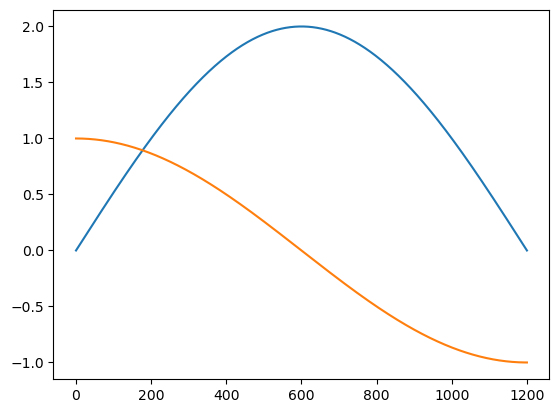

In [33]:
plt.figure()
plt.plot(P)
plt.plot(Z)

Text(0.5, 1.0, 'Input form \n $V=16.76, S=34.69$, $\\mathcal{V}=$$0.87$')

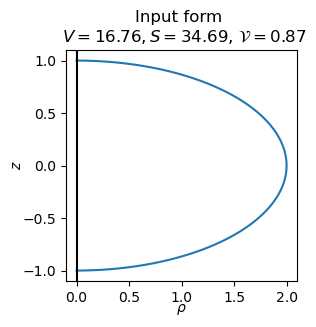

In [34]:
# %matplotlib notebook

Vol0,Sqr0,V_cal0 = get_VolSqr(P_fur, Z_fur)


plt.figure(figsize=(3,3))
plt.plot(P, Z,lw=1.5, ms=8, color = 'C0')
plt.axis('scaled')

plt.axvline(0, color='k')
plt.xlabel(r'$\rho$', labelpad=-2)
plt.ylabel(r'$z$', labelpad=-1)
plt.title(fr'Input form '+'\n'+fr' $V={Vol0:.2f}, S={Sqr0:.2f}$, '+r'$\mathcal{V}=$'+fr'${V_cal0:.2f}$')

In [53]:
H,force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 


### force function

In [56]:
def get_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4):
    V = np.sqrt(P1**2+Z1**2)
    H1 = H1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2 = H2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2[0] = H1[0];H2[-1] = H1[-1]
    
    
    K = H1*H2
    H = H1+H2
    
    laplH1 = laplH1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH1[0] = 2*(-P1[0]**2*Z4[0]+4*P1[0]*P3[0]*Z2[0]+3*Z2[0]**3)/np.abs(P1[0])**5/P1[0]
    laplH1[-1] = 2*(-P1[-1]**2*Z4[-1]+4*P1[-1]*P3[-1]*Z2[-1]+3*Z2[-1]**3)/np.abs(P1[-1])**5/P1[-1]
    
    laplH2 = laplH2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH2[0]=laplH1[0]/3
    laplH2[-1]=laplH1[-1]/3
    
    laplH = laplH1+laplH2
    
    force =  H**3/2 - 2*H*K + laplH
    return force

def get_force_from_ar(P_fur, Z_fur):
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    return get_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4)

In [57]:
def get_force_a(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4):
    V = np.sqrt(P1**2+Z1**2)
    H1 = H1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2 = H2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2[0] = H1[0];H2[-1] = H1[-1]
    
    
    K = H1*H2
    H = H1+H2
    
    laplH1 = laplH1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH1[0] = 2*(-P1[0]**2*Z4[0]+4*P1[0]*P3[0]*Z2[0]+3*Z2[0]**3)/np.abs(P1[0])**5/P1[0]
    laplH1[-1] = 2*(-P1[-1]**2*Z4[-1]+4*P1[-1]*P3[-1]*Z2[-1]+3*Z2[-1]**3)/np.abs(P1[-1])**5/P1[-1]
    
    laplH2 = laplH2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH2[0]=laplH1[0]/3
    laplH2[-1]=laplH1[-1]/3
    
    laplH = laplH1+laplH2
    
    force =  H**3/2 - 2*H*K + laplH
    force_fur = np.fft.rfft(get_ext_array(force), norm='forward')
    force_a = np.fft.irfft(force_fur[:N], norm='forward',n=2*N_int)[:N_int+1]
    return force_a



def get_force_a_from_ar(P_fur, Z_fur):
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    return get_force_a(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4)

In [58]:
def get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4):
    V = np.sqrt(P1**2+Z1**2)
    H1 = H1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2 = H2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2[0] = H1[0];H2[-1] = H1[-1]
    
    
    K = H1*H2
    H = H1+H2
    
    laplH1 = laplH1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH1[0] = 2*(-P1[0]**2*Z4[0]+4*P1[0]*P3[0]*Z2[0]+3*Z2[0]**3)/np.abs(P1[0])**5/P1[0]
    laplH1[-1] = 2*(-P1[-1]**2*Z4[-1]+4*P1[-1]*P3[-1]*Z2[-1]+3*Z2[-1]**3)/np.abs(P1[-1])**5/P1[-1]
    
    laplH2 = laplH2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH2[0]=laplH1[0]/3
    laplH2[-1]=laplH1[-1]/3
    
    laplH = laplH1+laplH2
    
    force =  H**3/2 - 2*H*K + laplH
    return H, force

def get_H_force_from_ar(P_fur, Z_fur):
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    return get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4)

In [59]:
def get_H_force_a(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4):
    V = np.sqrt(P1**2+Z1**2)
    H1 = H1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2 = H2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2[0] = H1[0];H2[-1] = H1[-1]
    
    
    K = H1*H2
    H = H1+H2
    
    laplH1 = laplH1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH1[0] = 2*(-P1[0]**2*Z4[0]+4*P1[0]*P3[0]*Z2[0]+3*Z2[0]**3)/np.abs(P1[0])**5/P1[0]
    laplH1[-1] = 2*(-P1[-1]**2*Z4[-1]+4*P1[-1]*P3[-1]*Z2[-1]+3*Z2[-1]**3)/np.abs(P1[-1])**5/P1[-1]
    
    laplH2 = laplH2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH2[0]=laplH1[0]/3
    laplH2[-1]=laplH1[-1]/3
    
    laplH = laplH1+laplH2
    
    force =  H**3/2 - 2*H*K + laplH
    
    force_fur = np.fft.rfft(get_ext_array(force), norm='forward')
    force_a = np.fft.irfft(force_fur[:N], norm='forward',n=2*N_int)[:N_int+1]
    
    H_fur = np.fft.rfft(get_ext_array(H), norm='forward')
    H_a = np.fft.irfft(H_fur[:N], norm='forward',n=2*N_int)[:N_int+1]

    return H_a, force_a

def get_H_force_a_from_ar(P_fur, Z_fur):
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    return get_H_force_a(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4)

In [60]:
def get_H12(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4):
    V = np.sqrt(P1**2+Z1**2)
    H1 = H1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2 = H2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    H2[0] = H1[0];H2[-1] = H1[-1]
    return H1, H2

def get_H12_from_ar(P_fur, Z_fur):
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    return get_H12(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4)

In [61]:
def get_a_H(P_fur, Z_fur):
    H1,H2 = get_H12_from_ar(P_fur, Z_fur)
    return 1/(np.sqrt(H1**2+H2**2))

In [62]:
def get_a_lapl_H(P_fur, Z_fur):
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)
    
    laplH1 = laplH1_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH1[0] = 2*(-P1[0]**2*Z4[0]+4*P1[0]*P3[0]*Z2[0]+3*Z2[0]**3)/np.abs(P1[0])**5/P1[0]
    laplH1[-1] = 2*(-P1[-1]**2*Z4[-1]+4*P1[-1]*P3[-1]*Z2[-1]+3*Z2[-1]**3)/np.abs(P1[-1])**5/P1[-1]
    
    laplH2 = laplH2_wol_lam(P,P1,P2,P3,P4, Z,Z1,Z2,Z3,Z4)
    laplH2[0]=laplH1[0]/3
    laplH2[-1]=laplH1[-1]/3
    
    lapl_H_mean = np.sqrt(laplH1**2+laplH2**2)
    
    return 1/(lapl_H_mean**(1/3))

### Normal delta

In [63]:
def get_normal_delta_PZ(P_fur, Z_fur, normal_delta_fur):
    normal_delta = get_int_field(normal_delta_fur)
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)    
    V = np.sqrt(P1**2+Z1**2)  
    
    normal_delta_P = get_int_field(normal_delta_fur)*(-Z1/V)
    normal_delta_Z = get_int_field(normal_delta_fur)*(P1/V)
    
    return normal_delta_P,normal_delta_Z

def get_normal_delta_PZ_fur(P_fur, Z_fur, normal_delta_fur):
    normal_delta_P,normal_delta_Z = get_normal_delta_PZ(P_fur, Z_fur, normal_delta_fur)
    normal_delta_P_fur = np.real(np.fft.rfft(get_ext_array(normal_delta_P, 'p'), norm='forward')[:n_int]/(-1j))
    normal_delta_Z_fur = np.fft.rfft(get_ext_array(normal_delta_Z, 'z'), norm='forward')[:n_int].real
    return normal_delta_P_fur, normal_delta_Z_fur

### Velocity be Helfrik

In [568]:
def get_velo_h(P_fur, Z_fur):
    """
    Find velocity induced by Helfrik force 
    at n_int points
    Returns:
    V_rho, V_z
    """
    ### find fields ###
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)

    force = get_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 
    
    V_int = V[::N_int//n_int]
    
    Z_int = Z[::N_int//n_int]
    P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int]
    P1_int = P1[::N_int//n_int]
    force_int = force[::N_int//n_int]
    

    ### kernals G ###
    G_tild_mesh = get_all_G_tilde(P, P_int, Z, Z_int)

    G_rhorho_tilde_mesh = G_tild_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tild_mesh[0,1]
    G_zz_tilde_mesh     = G_tild_mesh[1,1]
    G_zrho_tilde_mesh   = G_tild_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    ### Kernals for normal force ###
    
    ### V_rho ###
    K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
                     -Z1.reshape(1,-1)*G_rhorho_tilde_mesh
    
    K_rho[Kron]=0
    K_rho[0]=0; K_rho[-1]=0
    
    V_rho_force = K_rho @ (weights_simp*force) - (force_int.reshape(-1,1)*K_rho) @ weights_simp
    V_rho_force /= 8*np.pi
    
    ### V_z ###    
    K_z =  P1.reshape(1,-1)*G_zz_tilde_mesh\
                     -Z1.reshape(1,-1)*G_zrho_tilde_mesh
    K_z[1:-1][Kron[1:-1]]=0
    
    
    V_z_force = K_z @ (weights_simp*force) - (force_int.reshape(-1,1)*K_z) @ weights_simp
    V_z_force /= 8*np.pi
    
    return V_rho_force, V_z_force

In [569]:
def get_velo_h_fur(P_fur, Z_fur):
    """
    Find N furier compoemts of 
    velocity induced by Helfrik force 
    at n_int points
    Returns:
    V_rho_fur, V_z_fur
    """
    velo_h_rho, velo_h_z = get_velo_h(P_fur, Z_fur)
    velo_h_rho_fur = np.fft.rfft(get_ext_array(velo_h_rho,'p'), norm='forward')[:N]
    velo_h_z_fur = np.fft.rfft(get_ext_array(velo_h_z,'z'), norm='forward')[:N]
    return (velo_h_rho_fur/(-1j)).real, velo_h_z_fur.real

In [570]:
def get_velo_h_fur_full(P_fur, Z_fur):
    """
    Find all furier compoemts of 
    velocity induced by Helfrik force 
    at n_int points
    Returns:
    V_rho_fur, V_z_fur
    """
    velo_h_rho, velo_h_z = get_velo_h(P_fur, Z_fur)
    velo_h_rho_fur = np.fft.rfft(get_ext_array(velo_h_rho,'p'), norm='forward')[:-1]
    velo_h_z_fur = np.fft.rfft(get_ext_array(velo_h_z,'z'), norm='forward')[:-1]
    return (velo_h_rho_fur/(-1j)).real, velo_h_z_fur.real

In [571]:
def get_velo_h_normal(P_fur, Z_fur):
    """
    Returns normal part of velocity, induced by Helfrik force
    """
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)

    force = get_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 
    
    ### fields at n_int points ###
    V_int = V[::N_int//n_int]
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    force_int = force[::N_int//n_int]
    
    ### kernals G ###
    G_tild_mesh = get_all_G_tilde(P, P_int, Z, Z_int)
    G_rhorho_tilde_mesh = G_tild_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tild_mesh[0,1]
    G_zz_tilde_mesh     = G_tild_mesh[1,1]
    G_zrho_tilde_mesh   = G_tild_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    ### Kernals for normal force ###
    
    ### V_rho ###
    K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
                     -Z1.reshape(1,-1)*G_rhorho_tilde_mesh
    
    K_rho[Kron]=0
    K_rho[0]=0; K_rho[-1]=0
    
    V_rho_force = K_rho @ (weights_simp*force) - (force_int.reshape(-1,1)*K_rho) @ weights_simp
    V_rho_force /= 8*np.pi
    
    ### V_z ###    
    K_z =  P1.reshape(1,-1)*G_zz_tilde_mesh\
                     -Z1.reshape(1,-1)*G_zrho_tilde_mesh
    K_z[1:-1][Kron[1:-1]]=0
    
    
    V_z_force = K_z @ (weights_simp*force) - (force_int.reshape(-1,1)*K_z) @ weights_simp
    V_z_force /= 8*np.pi
    
    ### Normal part ###
    velo_norm = -Z1_int/V_int* V_rho_force + P1_int/V_int* V_z_force
    
    return velo_norm

In [572]:
def get_div_v_force_fur(P_fur, Z_fur):
    """
    Return div_v_force_fur 
    """
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    H,force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4)
    
    ### fileds ###
    V = np.sqrt(P1**2+Z1**2)
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    
    ### kernals G ###
    G_tilde_mesh = get_all_G_tilde(P, P_int, Z, Z_int)
    G_rhorho_tilde_mesh = G_tilde_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tilde_mesh[0,1]
    G_zz_tilde_mesh     = G_tilde_mesh[1,1]
    G_zrho_tilde_mesh   = G_tilde_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    
    
    ### kernals dG (tilde) ###
    d_rhoG, d_zG = get_dG_tilde(P, P_int, Z, Z_int)
        
    d_rhoG_rhorho = d_rhoG[0,0]; d_rhoG_rhoz = d_rhoG[0,1]
    d_rhoG_zrho   = d_rhoG[1,0]; d_rhoG_zz   = d_rhoG[1,1]
    
    d_zG_rhorho = d_zG[0,0]; d_zG_rhoz = d_zG[0,1]
    d_zG_zrho   = d_zG[1,0]; d_zG_zz   = d_zG[1,1]


    ### vector kernals ###
    D_rho = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhorho + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zrho+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhorho+d_rhoG_zrho)+\
            (1/P_int).reshape(-1,1)*(G_rhorho_tilde_mesh)
    D_z = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhoz + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zz+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhoz+d_rhoG_zz)+\
            (1/P_int).reshape(-1,1)*(G_rhoz_tilde_mesh)
    ### axis expr ###
    D_z[0,:] = D_z_axis_part(Z_int[0]-Z, P); D_z[-1,:] = D_z_axis_part(Z_int[-1]-Z, P)
    D_rho[0,:] = D_rho_axis_part(Z_int[0]-Z, P);D_rho[-1,:] = D_rho_axis_part(Z_int[-1]-Z, P)
    D_z[0,0] = np.pi*Z2_int[0]/P1_int[0]**2;D_z[-1,-1] = np.pi*Z2_int[-1]/P1_int[-1]**2

    ### normal response ###
    D_n = -Z1.reshape(1,-1)*D_rho + P1.reshape(1,-1)*D_z
    D_n[0,0] = -Z2_int[0]*2*np.pi/P1_int[0]+P1_int[0]*D_z[0,0]
    D_n[-1,-1] = -Z2_int[-1]*2*np.pi/P1_int[-1]+P1_int[-1]*D_z[-1,-1]
    D_n[1:-1][Kron[1:-1]]=0

    ### find div_v from helfrih force ###
    Div_v_force = D_n * weights_simp.reshape(1,-1)      @ force -\
                         (D_n @ weights_simp) * force[::N_int//n_int]
    Div_v_force /= 8*np.pi
    Div_v_force_fur =  np.fft.rfft(get_ext_array(Div_v_force), norm='forward').real
    
    return Div_v_force_fur

In [573]:
def get_div_v_force_by_velo(P_fur, Z_fur):
    
    
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)    
    
    V = np.sqrt(P1**2+Z1**2)
    
    V_P_fur, V_Z_fur = get_velo_h_fur_full(P_fur, Z_fur)
    der_oper = 1j*np.pi*np.arange(V_P_fur.shape[0])
    
    
    V_rho = np.fft.irfft(V_P_fur*(-1j), norm='forward', n=2*N_int)[:N_int+1]
    V_rho1 = np.fft.irfft(V_P_fur*(-1j)*der_oper, norm='forward', n=2*N_int)[:N_int+1]
    
    V_z = np.fft.irfft(V_Z_fur, norm='forward', n=2*N_int)[:N_int+1]
    V_z1 = np.fft.irfft(V_Z_fur*der_oper, norm='forward', n=2*N_int)[:N_int+1]
    
    div_V = P1/V**2*V_rho1 + Z1/V**2*V_z1+V_rho/P
    
    return div_V



def get_div_v_force_fur_by_velo(P_fur, Z_fur):
    div_V = get_div_v_force_by_velo(P_fur, Z_fur)
    div_V[0] = div_V[1]
    div_V[-1] = div_V[-2]
    div_V_fur = np.fft.rfft(get_ext_array(div_V), norm='forward')
    return div_V_fur.real

<IPython.core.display.Javascript object>


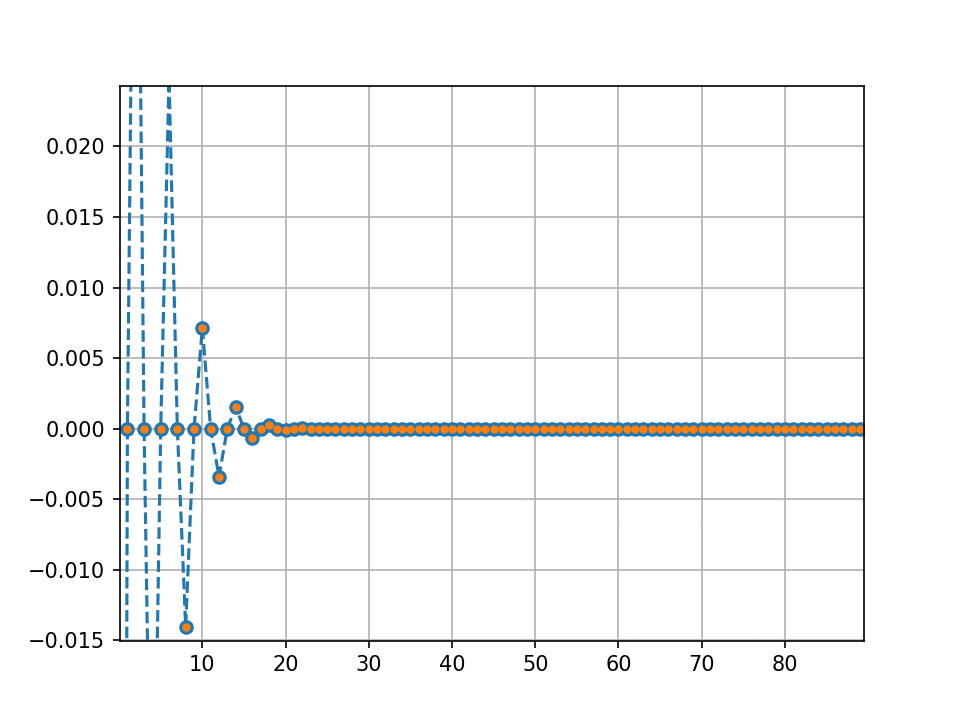

In [574]:
%matplotlib notebook
plt.figure()
plt.grid()
plt.plot(get_div_v_force_fur_by_velo(P_fur, Z_fur), 'o--')
plt.plot(get_div_v_force_fur(P_fur, Z_fur), '.')

## Reparametrization to constant velocity

In [13]:
def make_constant_v_repar(P_fur, Z_fur, N_proj=30):
    """
    Find reparametrization with constan V
    """
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)
    
    Der_goal_fft = np.fft.rfft(get_ext_array(V), norm='forward')
    Der_goal_fft /= Der_goal_fft[0]
    
    der_oper = 1j*np.pi*np.arange(Der_goal_fft.shape[0])
    Tau_s_goal_fur = Der_goal_fft.real/der_oper
    Tau_s_goal_fur[0]=0.
    
    Tau_s_goal_norm = np.fft.irfft(Tau_s_goal_fur, norm='forward', n=2*N_int)[:N_int+1]

    Tau_s_goal = Tau_int+Tau_s_goal_norm

    P_s_spline =sc.interpolate.make_interp_spline(Tau_s_goal,P,k=7,bc_type=(
        [(2, 0.0),(4, 0.0),(6, 0.0)], 
        [(2, 0.0),(4, 0.0),(6, 0.0)]))
    P_s = P_s_spline(Tau_int)

    Z_s_spline =sc.interpolate.make_interp_spline(Tau_s_goal,Z,k=7,bc_type=(
        [(1, 0.0),(3, 0.0),(5, 0.0)], 
        [(1, 0.0),(3, 0.0),(5, 0.0)]))
    Z_s = Z_s_spline(Tau_int)

    P_s_fft = np.fft.rfft(get_ext_array(P_s,'p'),norm='forward')
    Z_s_fft = np.fft.rfft(get_ext_array(Z_s,'z'),norm='forward')

    P_fur0_s = np.zeros(N)
    Z_fur0_s = np.zeros(N)

    P_fur0_s[:N_proj] = -P_s_fft.imag[:N_proj]
    Z_fur0_s[:N_proj] =  Z_s_fft.real[:N_proj]    
    return P_fur0_s,Z_fur0_s

In [14]:
def make_constant_v_repar_from_PZV(P, Z, V, N_proj=30):
    """
    Find reparametrization with constan V
    """

    
    Der_goal_fft = np.fft.rfft(get_ext_array(V), norm='forward')
    Der_goal_fft /= Der_goal_fft[0]
    
    der_oper = 1j*np.pi*np.arange(Der_goal_fft.shape[0])
    Tau_s_goal_fur = Der_goal_fft.real/der_oper
    Tau_s_goal_fur[0]=0.
    
    Tau_s_goal_norm = np.fft.irfft(Tau_s_goal_fur, norm='forward', n=2*N_int)[:N_int+1]

    Tau_s_goal = Tau_int+Tau_s_goal_norm

    P_s_spline =sc.interpolate.make_interp_spline(Tau_s_goal,P,k=7,bc_type=(
        [(2, 0.0),(4, 0.0),(6, 0.0)], 
        [(2, 0.0),(4, 0.0),(6, 0.0)]))
    P_s = P_s_spline(Tau_int)

    Z_s_spline =sc.interpolate.make_interp_spline(Tau_s_goal,Z,k=7,bc_type=(
        [(1, 0.0),(3, 0.0),(5, 0.0)], 
        [(1, 0.0),(3, 0.0),(5, 0.0)]))
    Z_s = Z_s_spline(Tau_int)

    P_s_fft = np.fft.rfft(get_ext_array(P_s,'p'),norm='forward')
    Z_s_fft = np.fft.rfft(get_ext_array(Z_s,'z'),norm='forward')

    P_fur0_s = np.zeros(N)
    Z_fur0_s = np.zeros(N)

    P_fur0_s[:N_proj] = -P_s_fft.imag[:N_proj]
    Z_fur0_s[:N_proj] =  Z_s_fft.real[:N_proj]    
    return P_fur0_s,Z_fur0_s

$$
\tau_s(\tau)\implies \tau_s' =C\cdot V
$$

## example

In [42]:
### find fields ###
P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
V = np.sqrt(P1**2+Z1**2)

force = get_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 

V_int = V[::N_int//n_int]

Z_int = Z[::N_int//n_int]
P_int = P[::N_int//n_int]
Z1_int = Z1[::N_int//n_int]
P1_int = P1[::N_int//n_int]
force_int = force[::N_int//n_int]


### kernals G ###
G_tild_mesh = get_all_G_tilde(P, P_int, Z, Z_int)

G_rhorho_tilde_mesh = G_tild_mesh[0,0]
G_rhoz_tilde_mesh   = G_tild_mesh[0,1]
G_zz_tilde_mesh     = G_tild_mesh[1,1]
G_zrho_tilde_mesh   = G_tild_mesh[1,0]

In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


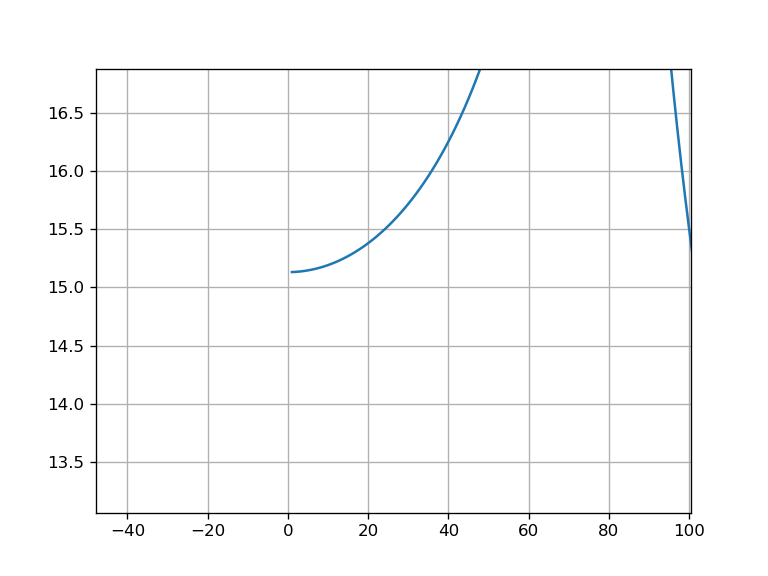

In [50]:
plt.figure()
plt.plot(G_zz_tilde_mesh[20,:]/P)

#plt.plot(1/np.sqrt(P))

plt.grid()

In [155]:
sigma_fur = get_sigma_fur(P, P1, P2, Z, Z1, Z2, H, force)
sigma_fur_new = get_sigma_fur_new(P, P1, P2, Z, Z1, Z2, H, force)

In [154]:
N_ext_sigma=50

<IPython.core.display.Javascript object>


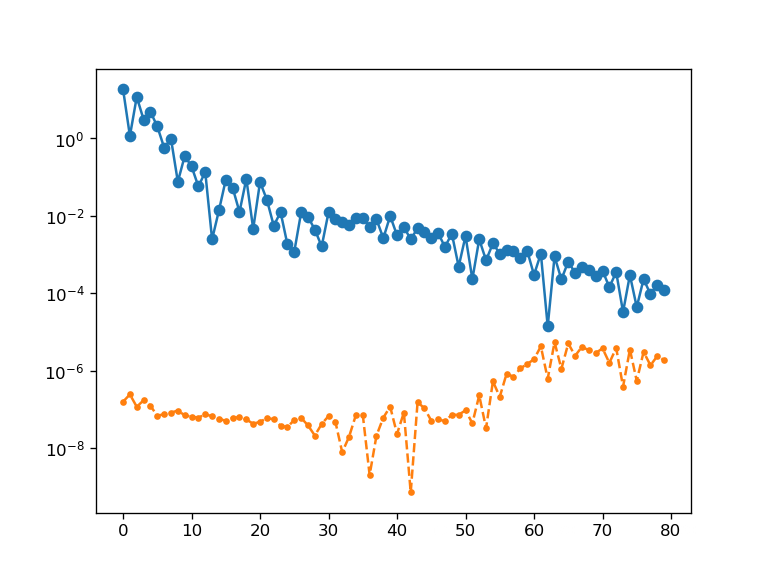

In [156]:
plt.figure()
plt.plot(np.abs(sigma_fur),'o-')
plt.plot(np.abs(sigma_fur-sigma_fur_new),'.--')
plt.yscale('log')

<IPython.core.display.Javascript object>


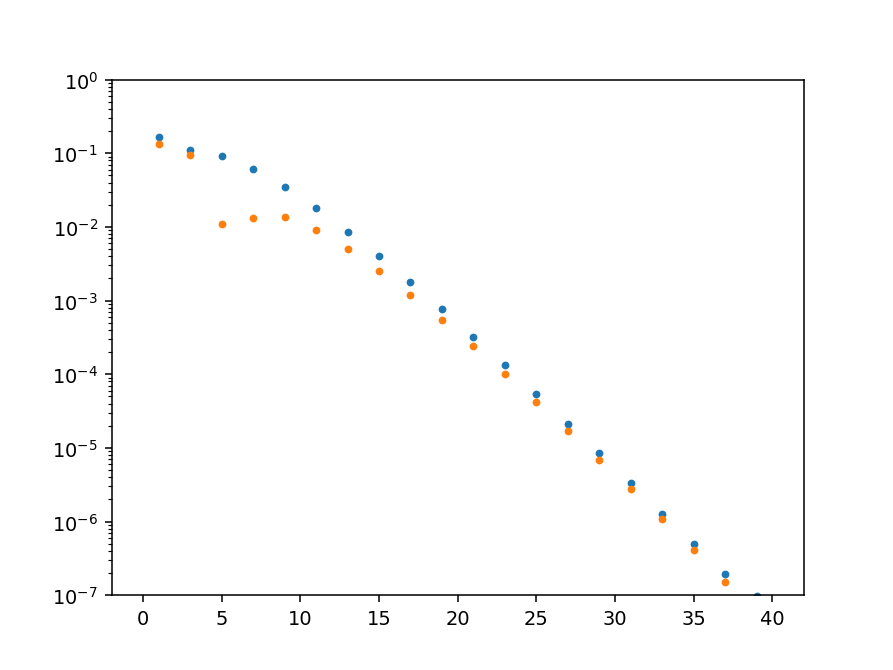

/tmp/ipykernel_5295/3809236376.py:25: RuntimeWarning: invalid value encountered in subtract
  K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\


(1e-07, 1.0)

In [29]:
plt.figure()
velo_h_rho, velo_h_z = get_velo_h(P_fur, Z_fur)
plt.plot(np.abs(np.fft.rfft(get_ext_array(velo_h_rho,'p'), norm='forward')),'.')
plt.plot(np.abs(np.fft.rfft(get_ext_array(velo_h_z,'z'), norm='forward')),'.')

plt.yscale('symlog', linthresh=1e-6)
plt.yscale('log')
plt.ylim(1e-7,1e0)

<IPython.core.display.Javascript object>


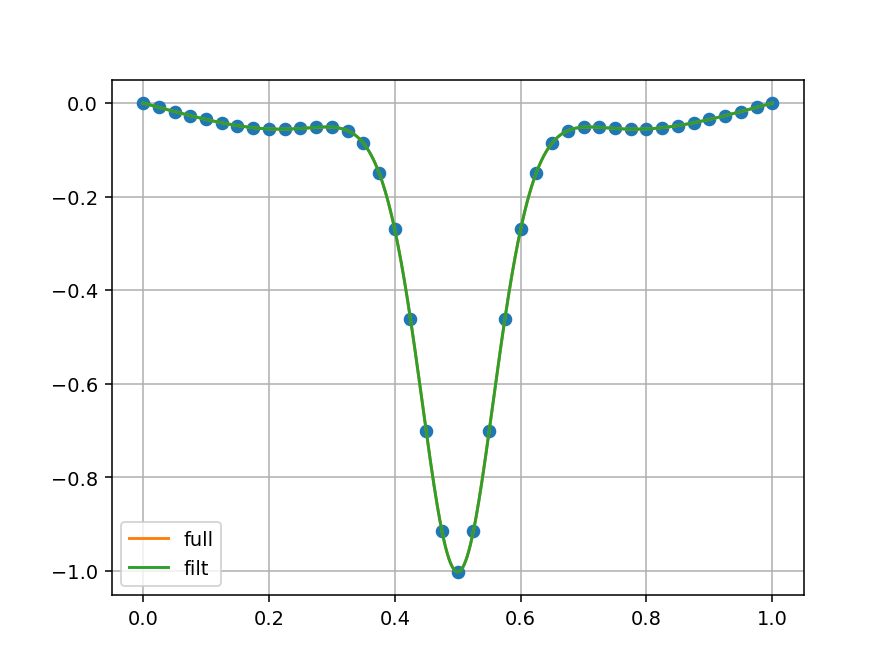

In [30]:
plt.figure()
plt.plot(tau_int, velo_h_rho,'o')

plt.plot(Tau_int, get_int_field(np.fft.rfft(get_ext_array(velo_h_rho, 'p'), norm='forward')[:n_int]), label='full')
plt.plot(Tau_int, get_int_field(np.fft.rfft(get_ext_array(velo_h_rho, 'p'), norm='forward')[:N]), label='filt')

#plt.plot(Tau_int, get_int_field(get_ext_array(velo_h_rho, 'p')), label='filt')

plt.grid()
plt.legend()
#plt.plot(velo_h_z,'o')


<IPython.core.display.Javascript object>


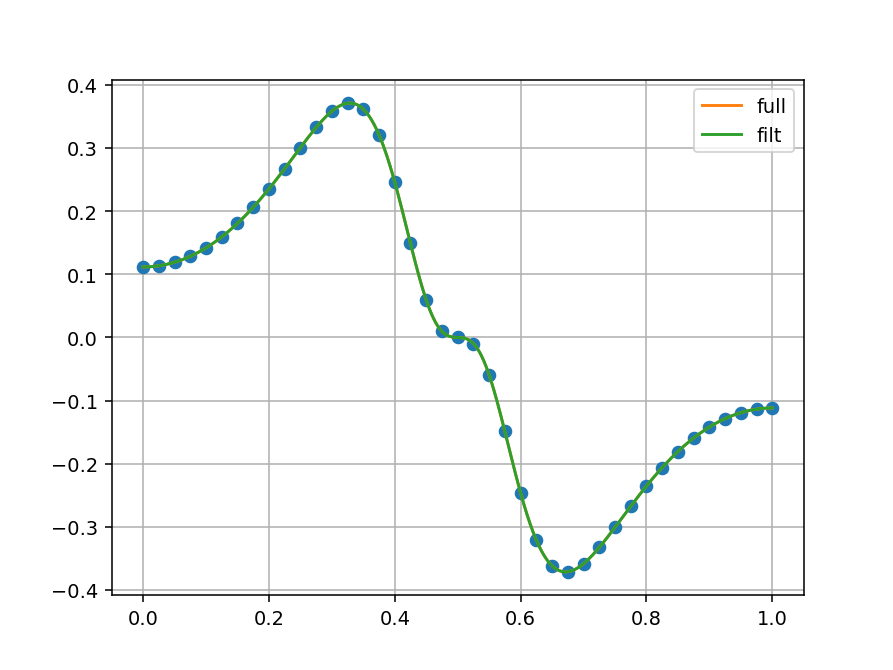

In [31]:
plt.figure()
plt.plot(tau_int, velo_h_z,'o')

plt.plot(Tau_int, get_int_field(np.fft.rfft(get_ext_array(velo_h_z, 'z'), norm='forward')[:n_int]), label='full')
plt.plot(Tau_int, get_int_field(np.fft.rfft(get_ext_array(velo_h_z, 'z'), norm='forward')[:N]), label='filt')

#plt.plot(Tau_int, get_int_field(get_ext_array(velo_h_rho, 'p')), label='filt')

plt.grid()
plt.legend()
#plt.plot(velo_h_z,'o')


<IPython.core.display.Javascript object>


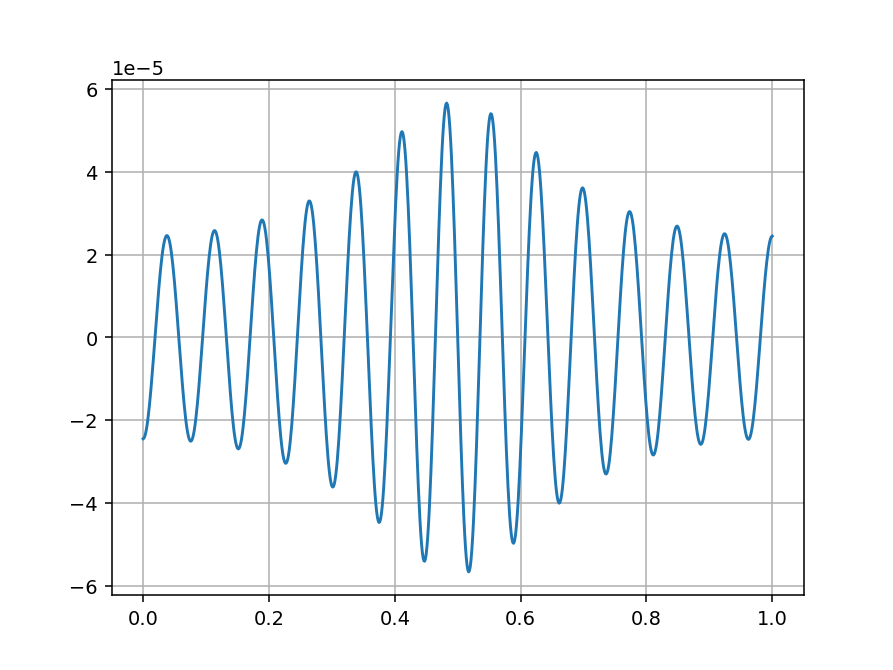

<IPython.core.display.Javascript object>


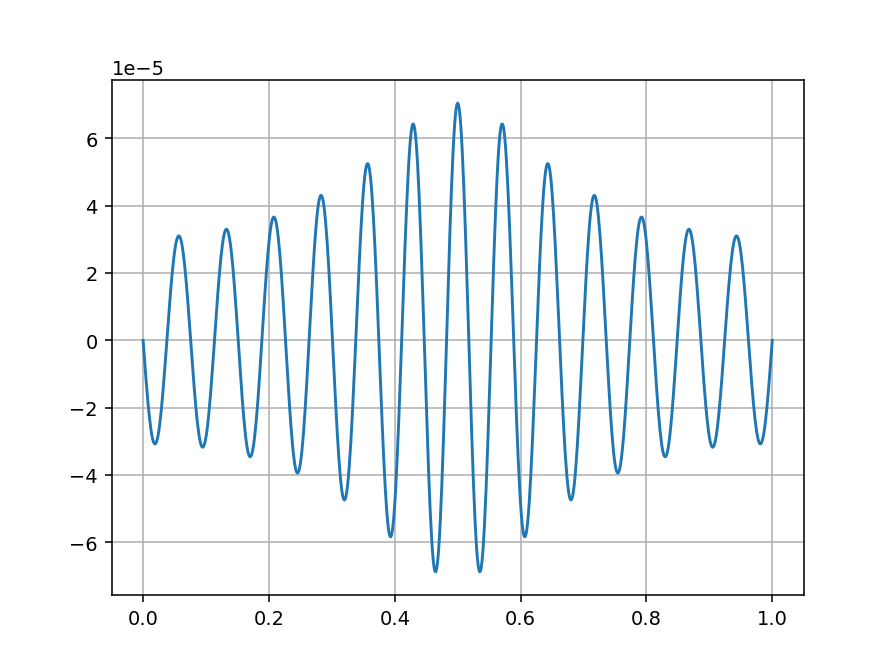

In [32]:
plt.figure()
plt.plot(Tau_int, 
        get_int_field(np.fft.rfft(get_ext_array(velo_h_z, 'z'), norm='forward')[:N])-\
        get_int_field(np.fft.rfft(get_ext_array(velo_h_z, 'z'), norm='forward')[:n_int])
        )

plt.grid()

plt.figure()
plt.plot(Tau_int, 
        get_int_field(np.fft.rfft(get_ext_array(velo_h_rho, 'p'), norm='forward')[:N])-\
        get_int_field(np.fft.rfft(get_ext_array(velo_h_rho, 'p'), norm='forward')[:n_int])
        )

plt.grid()

<IPython.core.display.Javascript object>


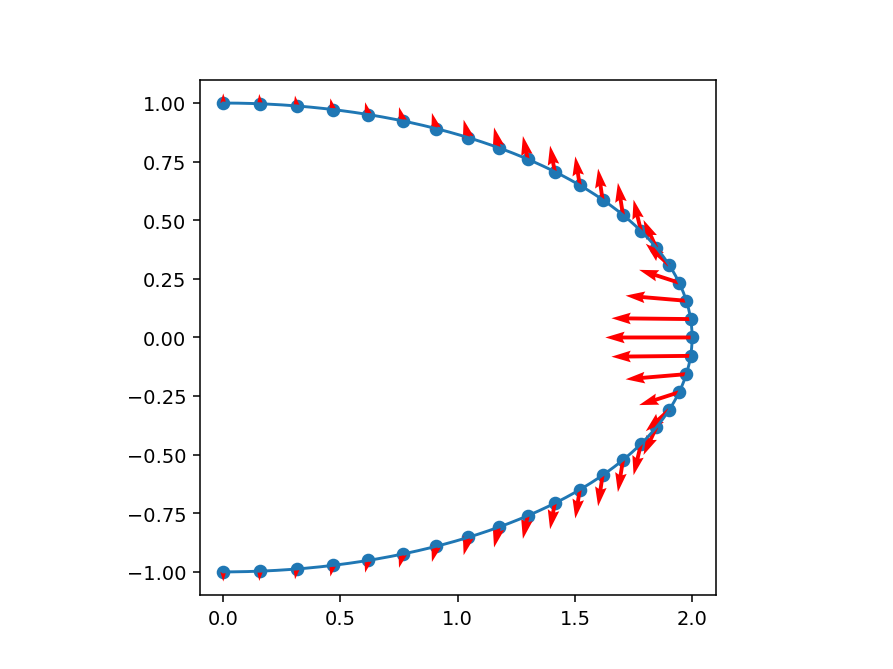

(-0.09999999999999999, 2.0999999999999996, -1.1, 1.1)

In [33]:
plt.figure()
Z_int = Z[::N_int//n_int]
P_int = P[::N_int//n_int]
    
plt.scatter(P_int, Z_int)
plt.plot(P, Z)
Qnow = plt.quiver(P_int, Z_int, velo_h_rho, velo_h_z, color='red')
plt.axis('scaled')

### Jacibian

In [93]:
def get_velo_h_fur_1d(pz):
    P_fur = np.zeros(N)
    P_fur[1:N]=pz[:N-1]
    Z_fur = pz[N-1:]
    veloP, veloZ = get_velo_fur(P_fur, Z_fur)
    return np.concatenate([veloP[1:N], veloZ])

In [94]:
import numdifftools as nd

In [95]:
jfun_h = nd.Jacobian(get_velo_h_fur_1d, step=5e-5)

jac_h = jfun_h(np.concatenate([P_fur[1:N],Z_fur]))

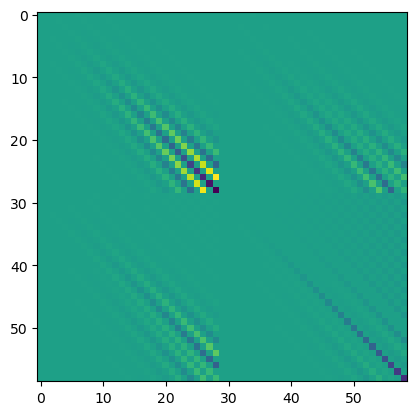

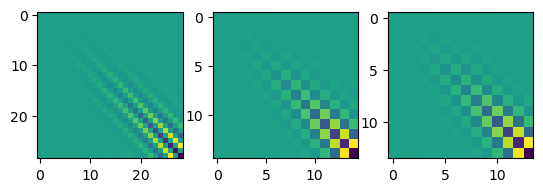

<Figure size 640x480 with 0 Axes>

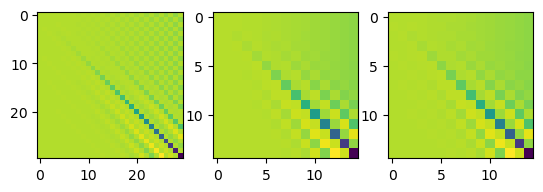

In [106]:
plt.figure()
plt.imshow(jac_h)

fig, axs = plt.subplots(1,3)

axs[0].imshow(jac_h[:N-1,:N-1])
axs[1].imshow(jac_h[:N-1:2,:N-1:2])
axs[2].imshow(jac_h[1:N-1:2,1:N-1:2])


plt.figure()

fig, axs = plt.subplots(1,3)

axs[0].imshow(jac_h[N-1:,N-1:])
axs[1].imshow(jac_h[N-1::2,N-1::2])
axs[2].imshow(jac_h[N::2,N::2])


In [107]:
w_full,vr_full =sc.linalg.eig(jac_h)
w_full_real = w_full[np.abs(np.imag(w_full))<1e-4]
w_full_real = np.real(w_full_real)
np.sort(w_full_real)

array([-3.37115201e+03, -3.00567591e+03, -1.93465075e+03, -1.70992544e+03,
       -1.30564644e+03, -1.15125632e+03, -9.77507582e+02, -8.60879550e+02,
       -7.63220408e+02, -6.66613949e+02, -5.82963317e+02, -5.01731514e+02,
       -4.28879376e+02, -3.62758443e+02, -3.03810325e+02, -2.51569136e+02,
       -2.05658038e+02, -1.65692284e+02, -1.31225515e+02, -1.01908281e+02,
       -7.72396877e+01, -5.69489573e+01, -4.04194458e+01, -2.75489394e+01,
       -1.74816975e+01, -1.04514687e+01, -5.16084870e+00, -2.41078239e+00,
       -1.63707808e-01, -1.14997330e-01, -1.11189896e-01, -1.06870955e-01,
       -1.03429510e-01, -1.00446209e-01, -9.00773186e-02, -7.86008956e-02,
       -7.46405435e-02, -7.45361614e-02, -6.83650706e-02, -6.58347351e-02,
       -6.31650784e-02, -6.27768866e-02, -5.96727931e-02, -5.93780973e-02,
       -3.99005038e-02, -2.76739755e-02,  0.00000000e+00])

In [113]:
w_full[np.abs(np.imag(w_full))>1e-4]

array([-0.28625584+0.29425344j, -0.28625584-0.29425344j,
        0.23197408+0.27015078j,  0.23197408-0.27015078j,
       -0.19400544+0.12826692j, -0.19400544-0.12826692j,
       -0.2640882 +0.19257342j, -0.2640882 -0.19257342j,
        0.0028257 +0.0839935j ,  0.0028257 -0.0839935j ,
       -0.08505429+0.00425514j, -0.08505429-0.00425514j])

<IPython.core.display.Javascript object>


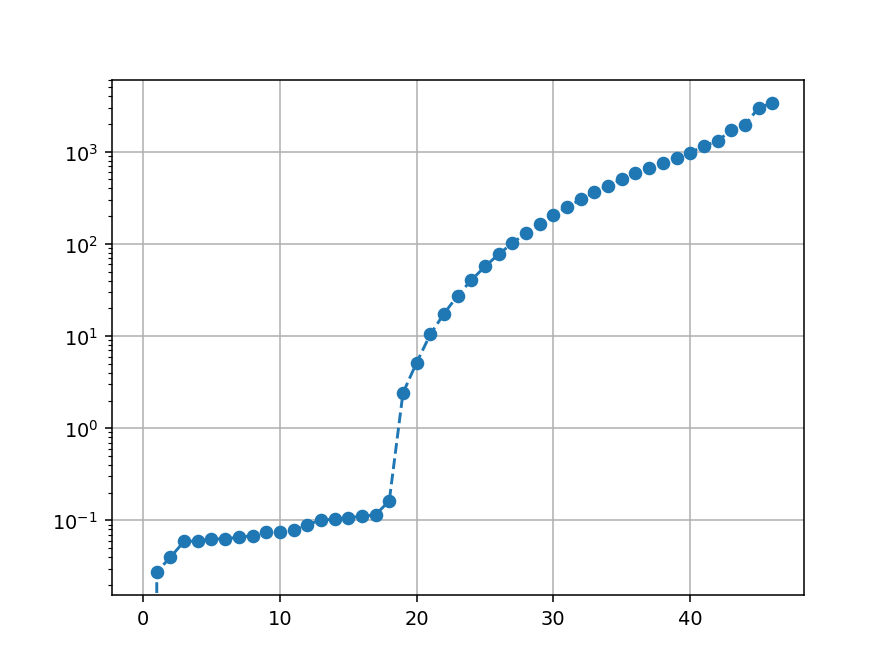

In [110]:
%matplotlib notebook
plt.figure()
plt.plot(-np.sort(w_full_real)[::-1],'o--')

plt.grid()
plt.axhline(0, color='k')
#plt.ylim(-1,10)
plt.yscale('log')

<IPython.core.display.Javascript object>


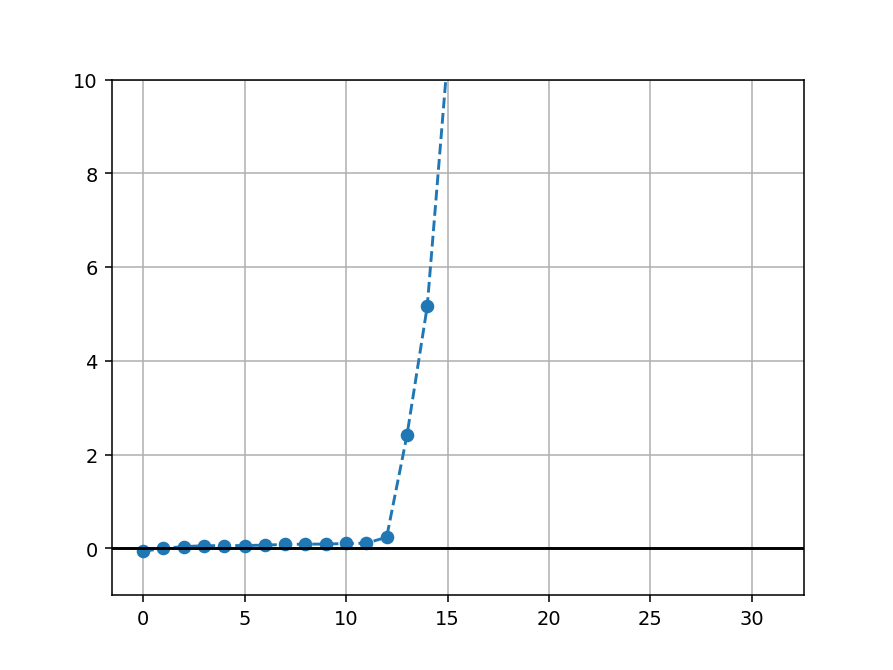

(-1.0, 10.0)

In [191]:
%matplotlib notebook
plt.figure()
plt.plot(-np.sort(w_full_real)[::-1],'o--')
plt.grid()
plt.axhline(0, color='k')
plt.ylim(-1,10)

In [111]:
%matplotlib inline
@interact_manual(m=(0,50))
def plot_eig_j(m):
    plt.figure()
    
    w_m = (np.sort(w_full_real)[::-1])[m]
    plt.title(f'w={w_m}')
    index_m = np.argmin(np.abs(w_full - w_m))
    print(w_full[index_m])
    v_m = np.real(vr_full[:, index_m])
    plt.plot(w_m*v_m,'.--')
    plt.plot(Div_v_sum_oper_fur[:N,:N] @ v_m,'o--')
    
#     v_tau = get_P_with0(v_m[:N-1])*P1_ar_j + v_m[N-1:]*Z1_ar_j
#     v_tau /= V_ar_j
    
#     v_n = -Z1_ar_j*get_P_with0(v_m[:N-1]) + P1_ar_j*v_m[N-1:]
#     v_n /= V_ar_j
#     plt.figure()
#     plt.plot(v_n, 'o--',label=r'$v_n$')
#     plt.plot(v_tau, 'o--',label=r'$v_\tau$')
#     plt.legend()

interactive(children=(IntSlider(value=25, description='m', max=50), Button(description='Run Interact', style=B…

### Jacobian with normal delta

In [612]:
P, P1,P2,P3,P4 = get_int_fields(get_ext_array(P_ar, 'p'))
P[0]=0; P[-1]=0; P2[0]=0;P2[-1]=0; P4[0]=0;P4[-1]=0;
Z, Z1,Z2,Z3,Z4 = get_int_fields(get_ext_array(Z_ar, 'z'))
Z1[0]=0; Z1[-1]=0; Z3[0]=0;Z3[-1]=0

V = np.sqrt(P1**2+Z1**2)

In [613]:
P1_ar = P1[::N_int//N]
Z1_ar = Z1[::N_int//N]
V_ar = V[::N_int//N]

In [614]:
P1_int = P1[::N_int//n_int]
Z1_int = Z1[::N_int//n_int]
V_int = V[::N_int//n_int]

$$
\mathbf{\tau }  =\frac{1}{v}  \begin{pmatrix}
P_{\tau } & Z_{\tau }
\end{pmatrix} , \mathbf{l}  = \frac{1}{v}\begin{pmatrix}
-Z_{\tau } & P_{\tau }
\end{pmatrix}
$$


In [615]:
def get_velo_h_normal(delta_n):
    delta_P_ar = delta_n*(-Z1_ar/V_ar)
    delta_Z_ar = delta_n*(P1_ar/V_ar)
    
    velo_h_rho, velo_h_z = get_velo_h(P_ar+delta_P_ar, Z_ar+delta_Z_ar)
    velo_h_rho_filt = get_N_field(get_ext_array(velo_h_rho,'p'))
    velo_h_z_filt = get_N_field(get_ext_array(velo_h_z,'z'))
    
    velo_norm = -Z1_ar/V_ar* velo_h_rho_filt + P1_ar/V_ar* velo_h_z_filt
    return velo_norm

In [616]:
def get_velo_h_normal_full(delta_n):
    delta_P_ar = delta_n*(-Z1_ar/V_ar)
    delta_Z_ar = delta_n*(P1_ar/V_ar)
    
    velo_h_rho, velo_h_z = get_velo_h(P_ar+delta_P_ar, Z_ar+delta_Z_ar)
    print(velo_h_rho.shape)
    velo_norm = -Z1_int/V_int* velo_h_rho + P1_int/V_int* velo_h_z
    return velo_norm

In [320]:
import numdifftools as nd

In [321]:
jfun_h_n = nd.Jacobian(get_velo_h_normal, step=1e-6)

jac_h_n = jfun_h_n(np.zeros(N+1))

<IPython.core.display.Javascript object>


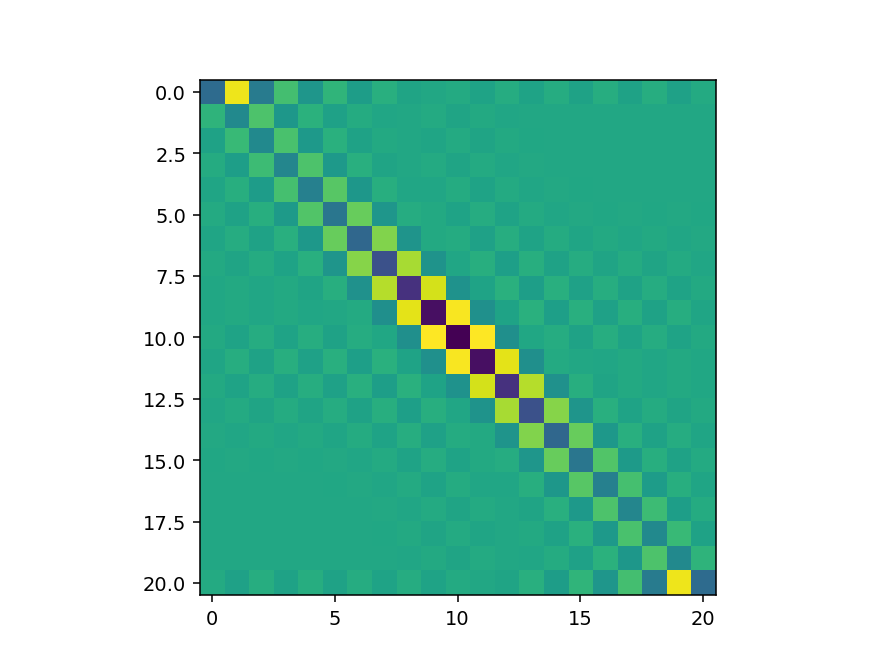

In [322]:
plt.figure()
plt.imshow(jac_h_n)

In [323]:
w_full,vr_full =sc.linalg.eig(jac_h_n)
print(w_full)
w_full_real = w_full[np.abs(np.imag(w_full))<1e-4]
w_full_real = np.real(w_full_real)
np.sort(w_full_real)

[-8.51447629e+02+0.j -7.05710411e+02+0.j -4.47296301e+02+0.j
 -3.63871903e+02+0.j -2.94132740e+02+0.j -2.48759865e+02+0.j
 -2.02552234e+02+0.j -1.65968456e+02+0.j -1.31006856e+02+0.j
 -1.01947257e+02+0.j -7.72321010e+01+0.j -5.69751092e+01+0.j
 -4.03983274e+01+0.j -2.75858364e+01+0.j -1.74177647e+01+0.j
 -1.05044805e+01+0.j -5.02963064e+00+0.j -2.48166229e+00+0.j
  3.73598783e-01+0.j -1.19779298e-01+0.j -3.43624093e-01+0.j]


array([-8.51447629e+02, -7.05710411e+02, -4.47296301e+02, -3.63871903e+02,
       -2.94132740e+02, -2.48759865e+02, -2.02552234e+02, -1.65968456e+02,
       -1.31006856e+02, -1.01947257e+02, -7.72321010e+01, -5.69751092e+01,
       -4.03983274e+01, -2.75858364e+01, -1.74177647e+01, -1.05044805e+01,
       -5.02963064e+00, -2.48166229e+00, -3.43624093e-01, -1.19779298e-01,
        3.73598783e-01])

In [274]:
w_full,vr_full =sc.linalg.eig(jac_h_n)
print(w_full)
w_full_real = w_full[np.abs(np.imag(w_full))<1e-4]
w_full_real = np.real(w_full_real)
np.sort(w_full_real)

[-8.51446040e+02+0.j -7.05709145e+02+0.j -4.47295506e+02+0.j
 -3.63871268e+02+0.j -2.94132249e+02+0.j -2.48759511e+02+0.j
 -2.02552000e+02+0.j -1.65968298e+02+0.j -1.31006754e+02+0.j
 -1.01947192e+02+0.j -7.72320629e+01+0.j -5.69750878e+01+0.j
 -4.03983165e+01+0.j -2.75858313e+01+0.j -1.74177625e+01+0.j
 -1.05044797e+01+0.j -5.02963046e+00+0.j -2.48166226e+00+0.j
  3.73598753e-01+0.j -1.19779315e-01+0.j -3.43624099e-01+0.j]


array([-8.51446040e+02, -7.05709145e+02, -4.47295506e+02, -3.63871268e+02,
       -2.94132249e+02, -2.48759511e+02, -2.02552000e+02, -1.65968298e+02,
       -1.31006754e+02, -1.01947192e+02, -7.72320629e+01, -5.69750878e+01,
       -4.03983165e+01, -2.75858313e+01, -1.74177625e+01, -1.05044797e+01,
       -5.02963046e+00, -2.48166226e+00, -3.43624099e-01, -1.19779315e-01,
        3.73598753e-01])

<IPython.core.display.Javascript object>


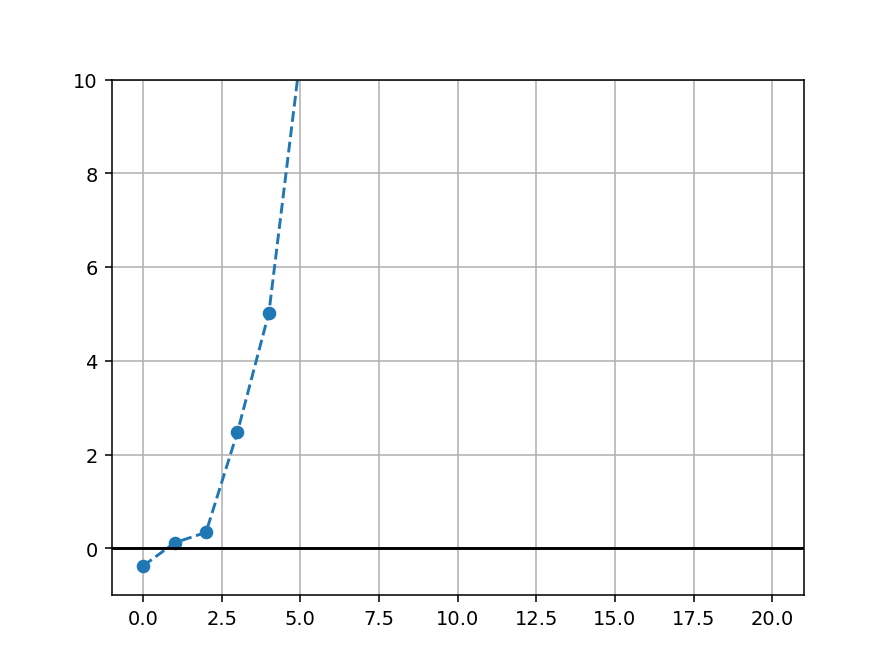

(-1.0, 10.0)

In [324]:
%matplotlib notebook
plt.figure()
plt.plot(-np.sort(w_full_real)[::-1],'o--')
# plt.plot(-np.sort(w_full_real_30_300)[::-1],'o--')

plt.grid()
plt.axhline(0, color='k')
plt.ylim(-1,10)

In [325]:
%matplotlib inline
@interact_manual(m=(0,50))
def plot_eig_j(m):
    plt.figure()
    
    w_m = (-np.sort(w_full_real)[::-1])[m]
    plt.title(f'w={w_m}')
    index_m = np.argmin(np.abs(w_full - w_m))
    v_m = np.real(vr_full[:, m])
    plt.plot(v_m,'.--')
    
#     v_tau = get_P_with0(v_m[:N-1])*P1_ar_j + v_m[N-1:]*Z1_ar_j
#     v_tau /= V_ar_j
    
#     v_n = -Z1_ar_j*get_P_with0(v_m[:N-1]) + P1_ar_j*v_m[N-1:]
#     v_n /= V_ar_j
#     plt.figure()
#     plt.plot(v_n, 'o--',label=r'$v_n$')
#     plt.plot(v_tau, 'o--',label=r'$v_\tau$')
#     plt.legend()
;

interactive(children=(IntSlider(value=25, description='m', max=50), Button(description='Run Interact', style=B…

''

<Figure size 640x480 with 0 Axes>

In [326]:
up_part = np.eye(N+1, dtype=int)
down_part = np.fliplr(np.eye(N+1, dtype=int))[1:-1]
extender_z = np.concatenate((up_part, down_part))
extender_p = np.concatenate((up_part, -down_part))

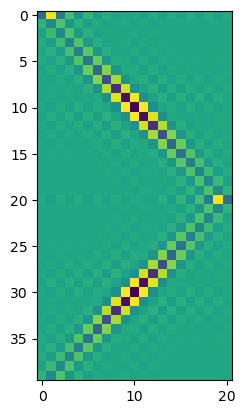

In [327]:
plt.figure()
plt.imshow(extender_z @ jac_h_n)

In [328]:
jac_h_n_fur = np.fft.rfft(extender_z @ jac_h_n, norm='forward', axis=0) @ np.fft.irfft(np.eye(N+1), axis=0, norm='forward', n=2*N)[:N+1,:]

In [274]:
w_full,vr_full =sc.linalg.eig(jac_h_n)
print(w_full)
w_full_real = w_full[np.abs(np.imag(w_full))<1e-4]
w_full_real = np.real(w_full_real)
np.sort(w_full_real)

[-8.51446040e+02+0.j -7.05709145e+02+0.j -4.47295506e+02+0.j
 -3.63871268e+02+0.j -2.94132249e+02+0.j -2.48759511e+02+0.j
 -2.02552000e+02+0.j -1.65968298e+02+0.j -1.31006754e+02+0.j
 -1.01947192e+02+0.j -7.72320629e+01+0.j -5.69750878e+01+0.j
 -4.03983165e+01+0.j -2.75858313e+01+0.j -1.74177625e+01+0.j
 -1.05044797e+01+0.j -5.02963046e+00+0.j -2.48166226e+00+0.j
  3.73598753e-01+0.j -1.19779315e-01+0.j -3.43624099e-01+0.j]


array([-8.51446040e+02, -7.05709145e+02, -4.47295506e+02, -3.63871268e+02,
       -2.94132249e+02, -2.48759511e+02, -2.02552000e+02, -1.65968298e+02,
       -1.31006754e+02, -1.01947192e+02, -7.72320629e+01, -5.69750878e+01,
       -4.03983165e+01, -2.75858313e+01, -1.74177625e+01, -1.05044797e+01,
       -5.02963046e+00, -2.48166226e+00, -3.43624099e-01, -1.19779315e-01,
        3.73598753e-01])

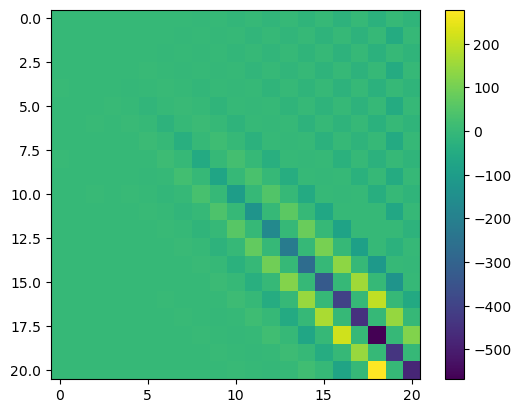

In [329]:
plt.figure()
plt.imshow(jac_h_n_fur.real)
plt.colorbar()

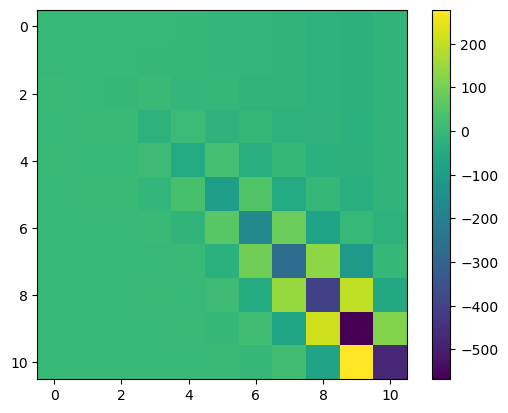

In [330]:
plt.figure()
plt.imshow(jac_h_n_fur.real[::2,::2])
plt.colorbar()

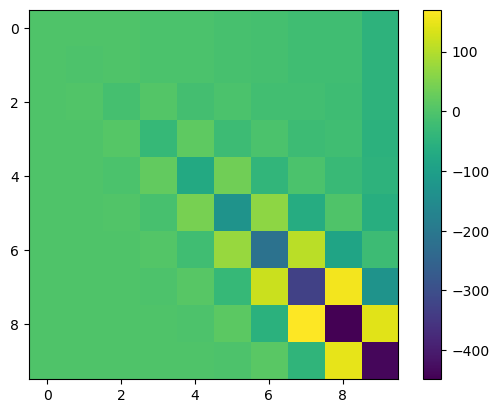

In [345]:
plt.figure()
plt.imshow(jac_h_n_fur.real[1::2,1::2])
plt.colorbar()

In [344]:
w_k,_ =sc.linalg.eig(jac_h_n_fur.real[::2,::2])
w_k.real

array([-8.51447629e+02, -4.47296301e+02, -2.94132740e+02, -2.02552234e+02,
       -1.31006856e+02, -7.72321010e+01, -4.03983274e+01, -1.74177647e+01,
       -5.02963064e+00,  3.73598783e-01, -1.19779298e-01])

In [348]:
w_k,_ =sc.linalg.eig(jac_h_n_fur.real[::2,::2][-9:,-9:])
w_k.real

array([-851.44775447, -447.29823135, -294.12293513, -202.57275211,
         -5.19990204,  -17.38641303,  -40.41135192, -130.98452756,
        -77.25395072])

In [347]:
w_k,_ =sc.linalg.eig(jac_h_n_fur.real[1::2,1::2][-5:,-5:])
w_k.real

array([-705.40751674, -359.42724298,  -97.8704218 , -150.14737134,
       -250.67786312])

In [436]:
np.fft.rfft(get_ext_array(Z_ar))

array([-1.11022302e-16+0.00000000e+00j,  2.00000000e+01-6.66133815e-16j,
        6.90533041e-16+2.19833563e-16j, -3.31983947e-16+4.92920449e-16j,
        1.61792770e-16-1.30428371e-15j,  1.70478510e-16-2.35513869e-16j,
        5.07635351e-16-1.09237794e-15j, -1.01774247e-16-9.00727448e-17j,
       -1.30496709e-16+6.64274160e-17j,  1.38941716e-16-1.09928807e-15j,
       -2.22044605e-16+1.11022302e-16j, -1.38941716e-16-6.55198865e-16j,
        4.55725532e-16+3.07599860e-16j, -2.79294459e-16+8.36633742e-17j,
       -6.35461407e-17+6.83978903e-16j, -6.14567720e-16-2.35513869e-16j,
       -6.05881980e-16+4.72073130e-16j,  9.18899322e-16+3.31256631e-17j,
       -1.22160853e-15-1.72524898e-16j, -1.77635684e-15-2.22044605e-16j,
       -3.33066907e-16+0.00000000e+00j])

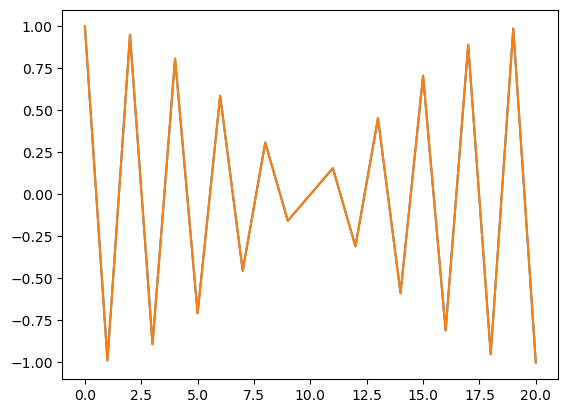

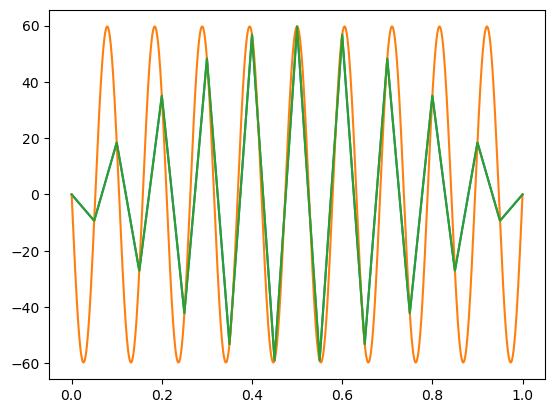

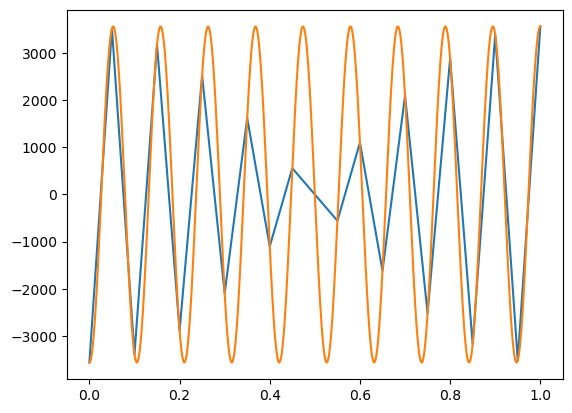

In [465]:
k=19
test_f = np.cos(np.pi*tau_N*k)
plt.plot(test_f)
plt.plot(np.fft.irfft(np.fft.rfft(get_ext_array(test_f), norm='forward'), norm='forward')[:N+1])

plt.figure()

der_oper = 1j*np.pi*np.arange(N+1)

plt.plot(tau_N, -np.sin(np.pi*tau_N*k)*(np.pi*k))
plt.plot(Tau_int,-np.sin(np.pi*Tau_int*k)*(np.pi*k))

plt.plot(tau_N, np.fft.irfft(der_oper*np.fft.rfft(get_ext_array(test_f), norm='forward'), norm='forward')[:N+1])

plt.figure()
plt.plot(tau_N, np.fft.irfft(der_oper**2*np.fft.rfft(get_ext_array(test_f), norm='forward'), norm='forward')[:N+1])
plt.plot(Tau_int,-np.cos(np.pi*Tau_int*k)*(np.pi*k)**2)


<IPython.core.display.Javascript object>


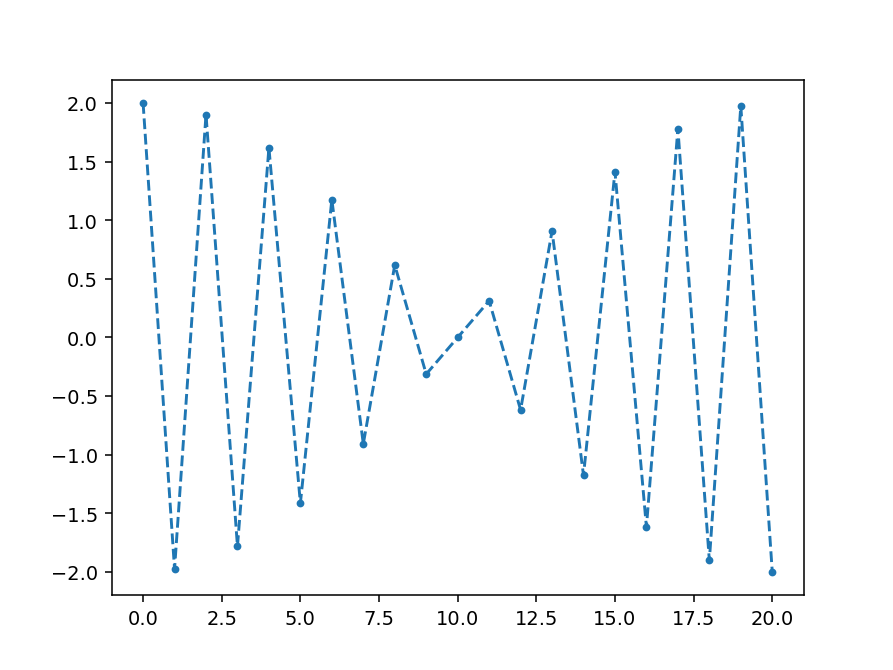

In [627]:
k=19
delta_k = np.zeros(N+1)
delta_k[k]=1.
delta_n_k = np.fft.irfft(delta_k, n=2*N, norm='forward')[0:N+1]
plt.figure()
plt.plot(delta_n_k,'.--')

<IPython.core.display.Javascript object>


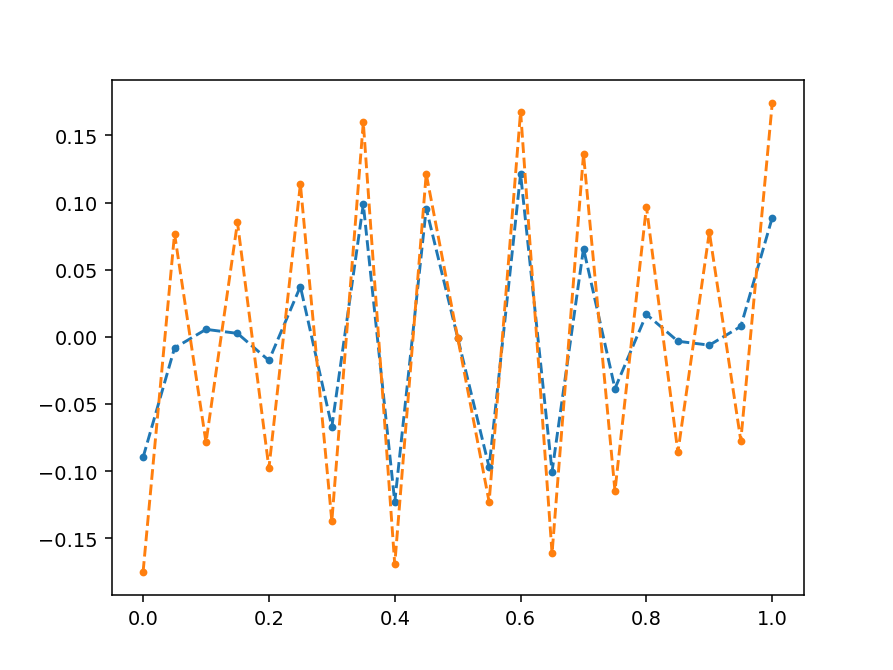

(21,)
(21,)


/tmp/ipykernel_89112/1385853270.py:28: RuntimeWarning: invalid value encountered in multiply
  -Z1.reshape(1,-1)*G_rhorho_tilde_mesh
/tmp/ipykernel_89112/1385853270.py:27: RuntimeWarning: invalid value encountered in subtract
  K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\


<IPython.core.display.Javascript object>


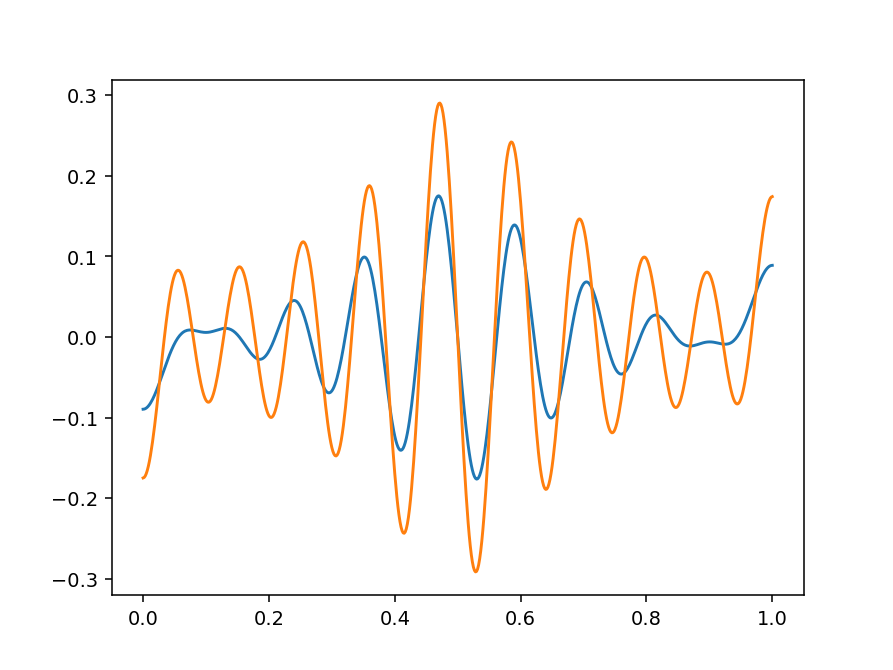

In [628]:
plt.figure()
delta_velo = get_velo_h_normal(delta_n_k*1e-4)-get_velo_h_normal(delta_n_k*0)
#delta_velo = get_N_field(get_ext_array(delta_velo))
plt.plot(tau_N, delta_velo,'.--')

delta_velo_full = get_velo_h_normal_full(delta_n_k*1e-4)-get_velo_h_normal_full(delta_n_k*0)
plt.plot(tau_int, delta_velo_full,'.--')

plt.figure()
delta_velo_cont = np.fft.irfft(np.fft.rfft(get_ext_array(delta_velo), norm='forward'),n=2*N_int, norm='forward')[:N_int+1]

plt.plot(Tau_int, delta_velo_cont)


delta_velo_cont = np.fft.irfft(np.fft.rfft(get_ext_array(delta_velo_full), norm='forward')[:N_int],n=2*N_int, norm='forward')[:N_int+1]

plt.plot(Tau_int, delta_velo_cont)

<IPython.core.display.Javascript object>


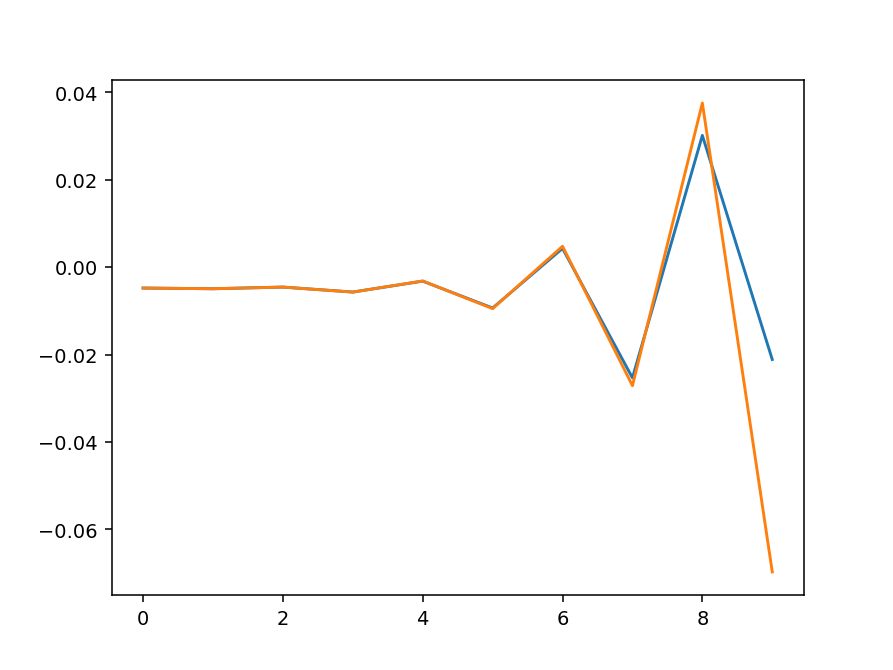

In [629]:
plt.figure()
plt.plot(np.fft.rfft(get_ext_array(delta_velo), norm='forward')[1::2])
plt.plot(np.fft.rfft(get_ext_array(delta_velo_full), norm='forward')[1::2])

## Helfrick dynamics

In [135]:
sol_bdf = sc.integrate.solve_ivp(lambda t,pz: get_velo_h_fur_1d(pz), (0., 10), np.concatenate([P_fur[1:N], Z_fur]), 
                                   method='BDF', atol=1e-8, rtol=1e-5);

/tmp/ipykernel_141999/3809236376.py:25: RuntimeWarning: invalid value encountered in subtract
  K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
/tmp/ipykernel_141999/3809236376.py:26: RuntimeWarning: invalid value encountered in multiply
  -Z1.reshape(1,-1)*G_rhorho_tilde_mesh


In [116]:
R_Vol0 = (3*Vol0/4/np.pi)**(1/3)
R_Vol0

1.5874010519619075

In [118]:
theta = np.linspace(0,np.pi,500)
P_Vol0 = R_Vol0*np.sin(theta)
Z_Vol0 = R_Vol0*np.cos(theta)

Text(0.5, 1.0, 'form')

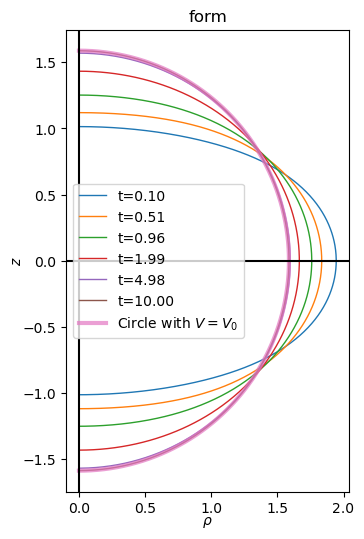

In [119]:
plt.figure(figsize=(6,6))
for t_j in [0.1,0.5, 1,2,5,10]:#range(len(sol_radau.t)):
    j = np.argmin(np.abs(sol_bdf.t-t_j))
    
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_bdf.y[:N-1,j]
    Z_fur_j =sol_bdf.y[N-1:,j] 
    P = get_int_field(-P_fur_j*1j)
    Z = get_int_field(Z_fur_j)
    
    plt.plot(P,Z,lw=1, label=f't={sol_bdf.t[j]:.2f}')


plt.plot(P_Vol0,Z_Vol0, lw=3, label=r'Circle with $V=V_0$', alpha=0.7)    
    
    
plt.axis('scaled')
plt.legend()
plt.axvline(0, color='k')
plt.axhline(0, color='k')

plt.xlabel(r'$\rho$', labelpad=-1)
plt.ylabel(r'$z$', labelpad=-1)
plt.title('form')

<IPython.core.display.Javascript object>


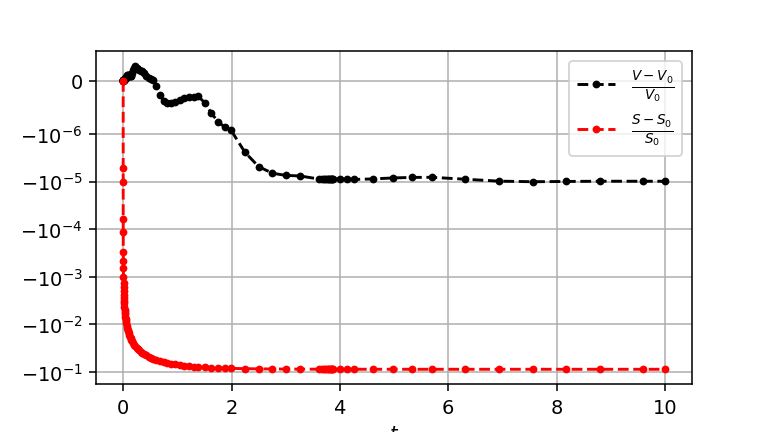

In [120]:
%matplotlib notebook
Vol0, Sqr0,_ = get_VolSqr(P_fur, Z_fur)
plt.figure(figsize=(3,2))
plt.grid()
Vol_ar=[]
Sqr_ar=[]
for j in range(len(sol_bdf.t)):
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_bdf.y[:N-1,j]
    Z_fur_j =sol_bdf.y[N-1:,j] 
    Vol,Sqr,_ = get_VolSqr(P_fur_j, Z_fur_j)
    Vol_ar.append(Vol)
    Sqr_ar.append(Sqr)
Vol_ar=np.array(Vol_ar)
Sqr_ar=np.array(Sqr_ar)   
plt.plot(sol_bdf.t, Vol_ar/Vol0-1,'.--', color='k', label=r'$\frac{V-V_0}{V_0}$')
plt.plot(sol_bdf.t, Sqr_ar/Sqr0-1,'.--', color='r', label=r'$\frac{S-S_0}{S_0}$')

plt.legend()
plt.xlabel(r'$t$')
plt.yscale('symlog', linthresh=1e-6)

<IPython.core.display.Javascript object>


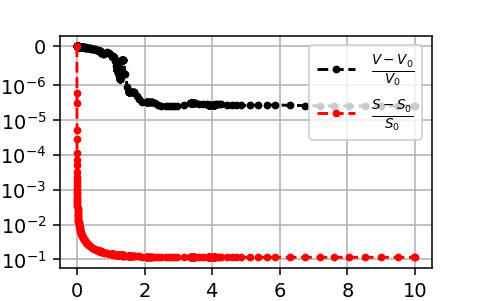

In [136]:
%matplotlib notebook
Vol0, Sqr0,_ = get_VolSqr(P_fur, Z_fur)
plt.figure(figsize=(3,2))
plt.grid()
Vol_ar=[]
Sqr_ar=[]
for j in range(len(sol_bdf.t)):
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_bdf.y[:N-1,j]
    Z_fur_j =sol_bdf.y[N-1:,j] 
    Vol,Sqr,_ = get_VolSqr(P_fur_j, Z_fur_j)
    Vol_ar.append(Vol)
    Sqr_ar.append(Sqr)
Vol_ar=np.array(Vol_ar)
Sqr_ar=np.array(Sqr_ar)   
plt.plot(sol_bdf.t, Vol_ar/Vol0-1,'.--', color='k', label=r'$\frac{V-V_0}{V_0}$')
plt.plot(sol_bdf.t, Sqr_ar/Sqr0-1,'.--', color='r', label=r'$\frac{S-S_0}{S_0}$')

plt.legend()
plt.xlabel(r'$t$')
plt.yscale('symlog', linthresh=1e-6)

<IPython.core.display.Javascript object>


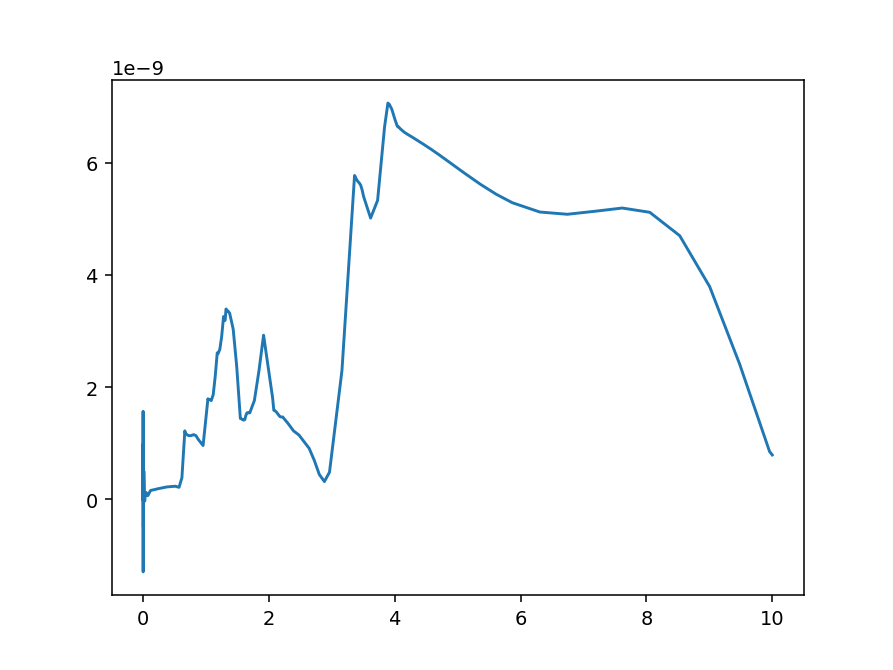

In [154]:
plt.figure()
j=26
plt.plot(sol_bdf.t, sol_bdf.y[j,:])

In [121]:
%matplotlib inline
@interact_manual(j=(0,len(sol_bdf.t)-1))
def plot_fields_j(j):
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_bdf.y[:N-1,j]
    Z_fur_j =sol_bdf.y[N-1:,j] 
    plt.figure()
    plt.title(f't={sol_bdf.t[j]:.3f}')
    plt.plot(np.abs(Z_fur_j),'.--',ms=15, label=r'$Z_k$')
    plt.plot(np.abs(np.fft.rfft(get_ext_array(get_force_from_ar(P_fur_j, Z_fur_j)), norm='forward')),'.--',ms=15, label=r'$f_k$')
    
    plt.plot(np.abs(np.fft.rfft(get_ext_array(get_velo_h(P_fur_j, Z_fur_j)[1]), norm='forward')),'.--',ms=15, label=r'$v^z_k$')
    
    
    plt.xlim(0,N*2)
    plt.ylim(1e-10, 1e2)
    
    plt.legend()
    plt.yscale('log')

interactive(children=(IntSlider(value=46, description='j', max=93), Button(description='Run Interact', style=B…

### RK dinamic

In [155]:
sol_rk = sc.integrate.solve_ivp(lambda t,pz: get_velo_h_fur_1d(pz), (0., 2), np.concatenate([P_fur[1:N], Z_fur]), 
                                   method='RK45');

/tmp/ipykernel_141999/3809236376.py:25: RuntimeWarning: invalid value encountered in subtract
  K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
/tmp/ipykernel_141999/3809236376.py:26: RuntimeWarning: invalid value encountered in multiply
  -Z1.reshape(1,-1)*G_rhorho_tilde_mesh


In [116]:
R_Vol0 = (3*Vol0/4/np.pi)**(1/3)
R_Vol0

1.5874010519619075

In [118]:
theta = np.linspace(0,np.pi,500)
P_Vol0 = R_Vol0*np.sin(theta)
Z_Vol0 = R_Vol0*np.cos(theta)

<IPython.core.display.Javascript object>


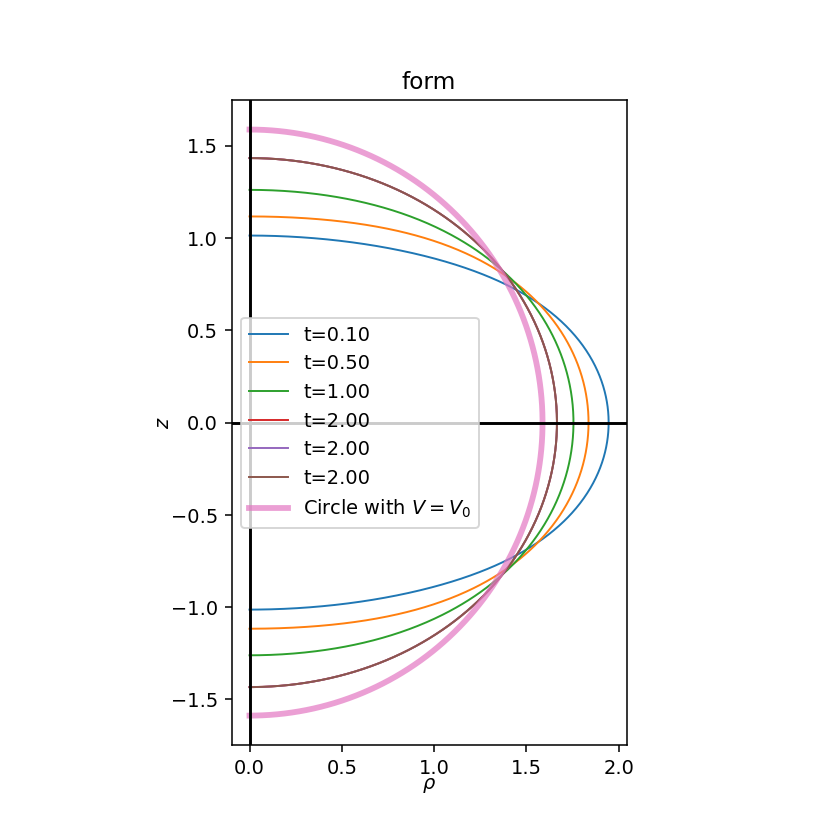

Text(0.5, 1.0, 'form')

In [156]:
plt.figure(figsize=(6,6))
for t_j in [0.1,0.5, 1,2,5,10]:#range(len(sol_radau.t)):
    j = np.argmin(np.abs(sol_rk.t-t_j))
    
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_rk.y[:N-1,j]
    Z_fur_j =sol_rk.y[N-1:,j] 
    P = get_int_field(-P_fur_j*1j)
    Z = get_int_field(Z_fur_j)
    
    plt.plot(P,Z,lw=1, label=f't={sol_rk.t[j]:.2f}')


plt.plot(P_Vol0,Z_Vol0, lw=3, label=r'Circle with $V=V_0$', alpha=0.7)    
    
    
plt.axis('scaled')
plt.legend()
plt.axvline(0, color='k')
plt.axhline(0, color='k')

plt.xlabel(r'$\rho$', labelpad=-1)
plt.ylabel(r'$z$', labelpad=-1)
plt.title('form')

<IPython.core.display.Javascript object>


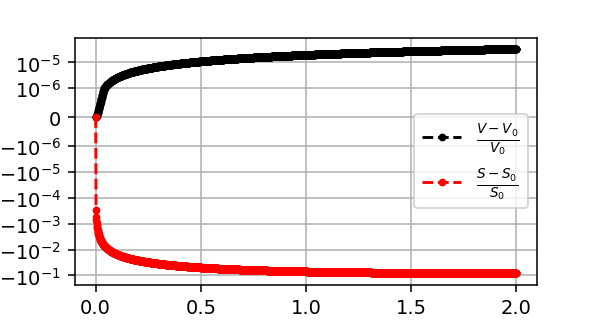

In [157]:
%matplotlib notebook
Vol0, Sqr0,_ = get_VolSqr(P_fur, Z_fur)
plt.figure(figsize=(3,2))
plt.grid()
Vol_ar=[]
Sqr_ar=[]
for j in range(len(sol_rk.t)):
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_rk.y[:N-1,j]
    Z_fur_j =sol_rk.y[N-1:,j] 
    Vol,Sqr,_ = get_VolSqr(P_fur_j, Z_fur_j)
    Vol_ar.append(Vol)
    Sqr_ar.append(Sqr)
Vol_ar=np.array(Vol_ar)
Sqr_ar=np.array(Sqr_ar)   
plt.plot(sol_rk.t, Vol_ar/Vol0-1,'.--', color='k', label=r'$\frac{V-V_0}{V_0}$')
plt.plot(sol_rk.t, Sqr_ar/Sqr0-1,'.--', color='r', label=r'$\frac{S-S_0}{S_0}$')

plt.legend()
plt.xlabel(r'$t$')
plt.yscale('symlog', linthresh=1e-6)

<IPython.core.display.Javascript object>


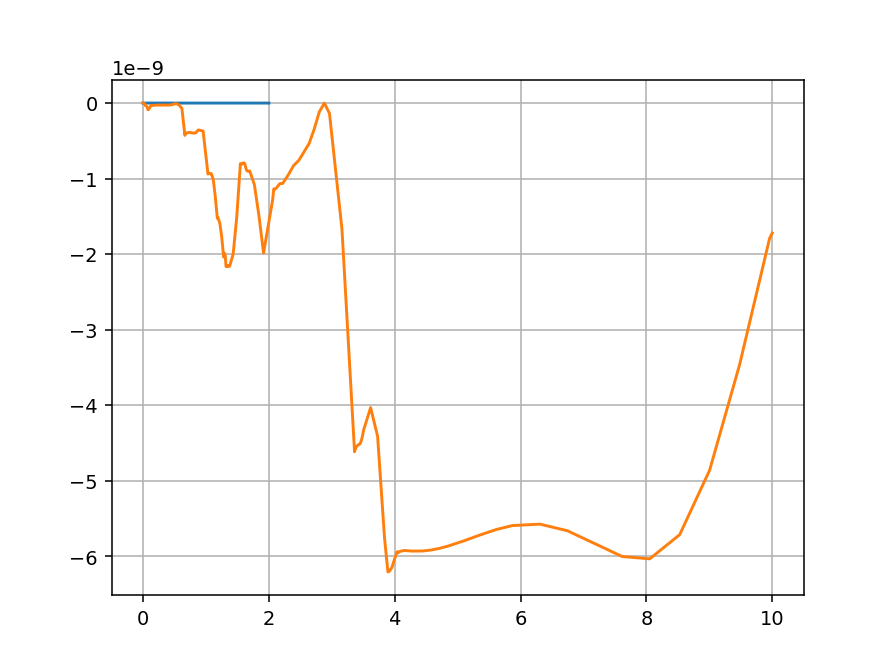

In [179]:
plt.figure()
j=23
plt.plot(sol_rk.t, sol_rk.y[j,:])
plt.plot(sol_bdf.t, sol_bdf.y[j,:])
plt.grid()

### Radau

In [189]:
sol_rad = sc.integrate.solve_ivp(lambda t,pz: get_velo_h_fur_1d(pz), (0., 2), np.concatenate([P_fur[1:N], Z_fur]), 
                                   method='Radau', atol=1e-7, rtol=1e-4);

/tmp/ipykernel_141999/3809236376.py:25: RuntimeWarning: invalid value encountered in subtract
  K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
/tmp/ipykernel_141999/3809236376.py:26: RuntimeWarning: invalid value encountered in multiply
  -Z1.reshape(1,-1)*G_rhorho_tilde_mesh


In [116]:
R_Vol0 = (3*Vol0/4/np.pi)**(1/3)
R_Vol0

1.5874010519619075

In [118]:
theta = np.linspace(0,np.pi,500)
P_Vol0 = R_Vol0*np.sin(theta)
Z_Vol0 = R_Vol0*np.cos(theta)

<IPython.core.display.Javascript object>


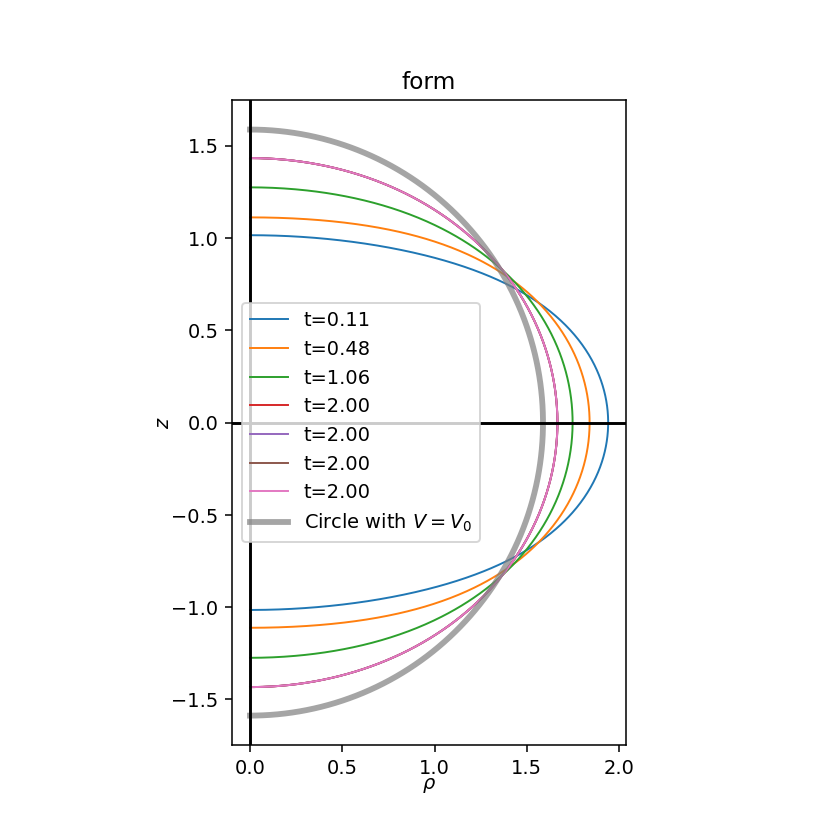

Text(0.5, 1.0, 'form')

In [190]:
plt.figure(figsize=(6,6))
for t_j in [0.1,0.5, 1,2,4,8,10]:#range(len(sol_radau.t)):
    j = np.argmin(np.abs(sol_rad.t-t_j))
    
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_rad.y[:N-1,j]
    Z_fur_j =sol_rad.y[N-1:,j] 
    P = get_int_field(-P_fur_j*1j)
    Z = get_int_field(Z_fur_j)
    
    plt.plot(P,Z,lw=1, label=f't={sol_rad.t[j]:.2f}')


plt.plot(P_Vol0,Z_Vol0, lw=3, label=r'Circle with $V=V_0$', alpha=0.7)    
    
    
plt.axis('scaled')
plt.legend()
plt.axvline(0, color='k')
plt.axhline(0, color='k')

plt.xlabel(r'$\rho$', labelpad=-1)
plt.ylabel(r'$z$', labelpad=-1)
plt.title('form')

<IPython.core.display.Javascript object>


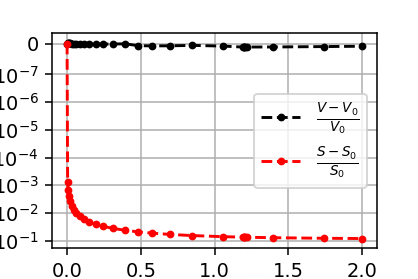

In [192]:
%matplotlib notebook
Vol0, Sqr0,_ = get_VolSqr(P_fur, Z_fur)
plt.figure(figsize=(3,2))
plt.grid()
Vol_ar=[]
Sqr_ar=[]
for j in range(len(sol_rad.t)):
    P_fur_j = np.zeros(N)
    P_fur_j[1:N] = sol_rad.y[:N-1,j]
    Z_fur_j =sol_rad.y[N-1:,j] 
    Vol,Sqr,_ = get_VolSqr(P_fur_j, Z_fur_j)
    Vol_ar.append(Vol)
    Sqr_ar.append(Sqr)
Vol_ar=np.array(Vol_ar)
Sqr_ar=np.array(Sqr_ar)   
plt.plot(sol_rad.t, Vol_ar/Vol0-1,'.--', color='k', label=r'$\frac{V-V_0}{V_0}$')
plt.plot(sol_rad.t, Sqr_ar/Sqr0-1,'.--', color='r', label=r'$\frac{S-S_0}{S_0}$')

plt.legend()
plt.xlabel(r'$t$')
plt.yscale('symlog', linthresh=1e-7)

<IPython.core.display.Javascript object>


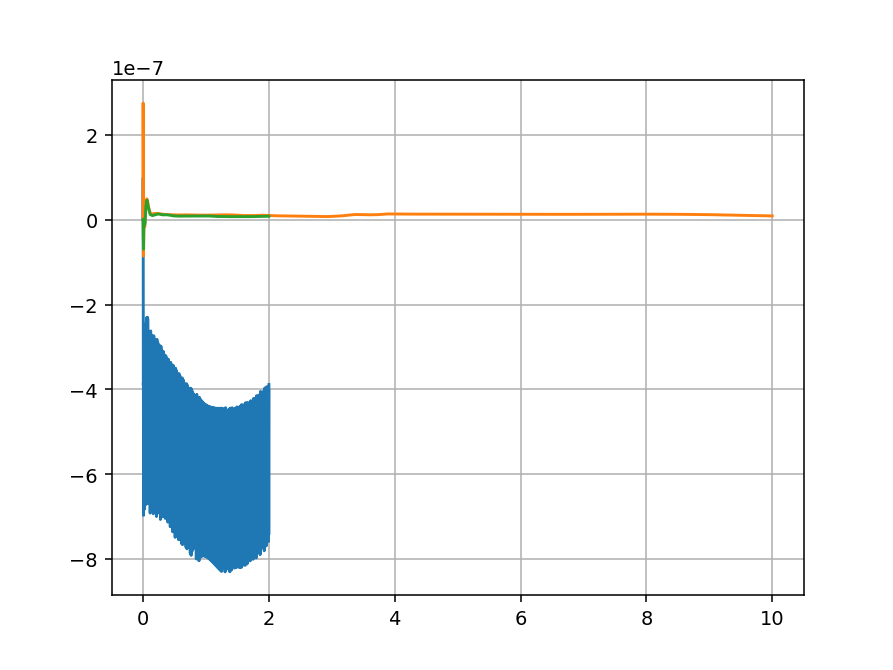

In [210]:
plt.figure()
j=18
plt.plot(sol_rk.t, sol_rk.y[j,:])
plt.plot(sol_bdf.t, sol_bdf.y[j,:])
plt.plot(sol_rad.t, sol_rad.y[j,:])

plt.grid()

## Helfrick normal dynamics

$$
\mathbf{\tau }  =\frac{1}{v}  \begin{pmatrix}
P_{\tau } & Z_{\tau }
\end{pmatrix} , \mathbf{l}  = \frac{1}{v}\begin{pmatrix}
-Z_{\tau } & P_{\tau }
\end{pmatrix}
$$


In [412]:
def get_velo_h_normal_1d(pz):
    P_ar = np.zeros(N+1)
    P_ar[1:N]=pz[:N-1]
    Z_ar = pz[N-1:]
    velo_h_rho, velo_h_z = get_velo_h(P_ar, Z_ar)
    velo_h_rho_filt = get_N_field(get_ext_array(velo_h_rho,'p'))
    velo_h_z_filt = get_N_field(get_ext_array(velo_h_z,'z'))
    
    P, P1,P2,P3,P4 = get_int_fields(get_ext_array(P_ar, 'p'))
    P[0]=0; P[-1]=0; P2[0]=0;P2[-1]=0; P4[0]=0;P4[-1]=0;
    Z, Z1,Z2,Z3,Z4 = get_int_fields(get_ext_array(Z_ar, 'z'))
    Z1[0]=0; Z1[-1]=0; Z3[0]=0;Z3[-1]=0
    
    Z1_ar = Z1[::N_int//N];P1_ar = P1[::N_int//N]
    V_ar = np.sqrt(Z1_ar**2+P1_ar**2)
    velo_norm = -Z1_ar/V_ar* velo_h_rho_filt + P1_ar/V_ar* velo_h_z_filt

    return np.concatenate([(velo_norm*(-Z1_ar/V_ar))[1:N], velo_norm*(P1_ar/V_ar)])

In [413]:
sol_bdf = sc.integrate.solve_ivp(lambda t,pz: get_velo_h_normal_1d(pz), (0., 100), np.concatenate([P_ar[1:-1], Z_ar]), 
                                   method='BDF', atol=1e-8, rtol=1e-5);

/tmp/ipykernel_89112/1385853270.py:27: RuntimeWarning: invalid value encountered in subtract
  K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
/tmp/ipykernel_89112/1385853270.py:28: RuntimeWarning: invalid value encountered in multiply
  -Z1.reshape(1,-1)*G_rhorho_tilde_mesh


In [395]:
R_Vol0 = (3*Vol0/4/np.pi)**(1/3)
R_Vol0

theta = np.linspace(0,np.pi,500)
P_Vol0 = R_Vol0*np.sin(theta)
Z_Vol0 = R_Vol0*np.cos(theta)

Text(0.5, 1.0, 'form')

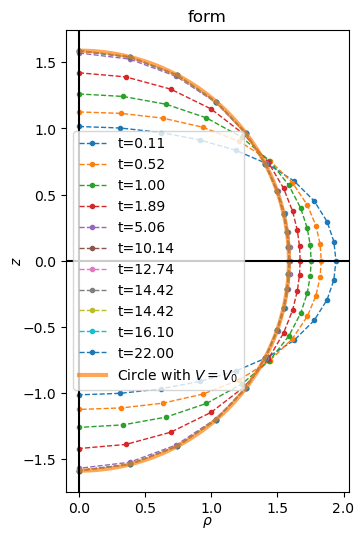

In [396]:
plt.figure(figsize=(6,6))
for t_j in [0.1,0.5, 1,2,5,10,13,15,15,17,20]:#range(len(sol_radau.t)):
    j = np.argmin(np.abs(sol_bdf.t-t_j))
    plt.plot(np.concatenate([[0.],sol_bdf.y[:N-1,j],[0.]]), sol_bdf.y[N-1:,j],'.--',
             lw=1, ms=6, label=f't={sol_bdf.t[j]:.2f}')


plt.plot(P_Vol0,Z_Vol0, lw=3, label=r'Circle with $V=V_0$', alpha=0.7)    
    
    
plt.axis('scaled')
plt.legend()
plt.axvline(0, color='k')
plt.axhline(0, color='k')

plt.xlabel(r'$\rho$', labelpad=-1)
plt.ylabel(r'$z$', labelpad=-1)
plt.title('form')

In [397]:
def get_P_with0(P_red):
    return np.concatenate([[0], P_red, [0]])

<IPython.core.display.Javascript object>


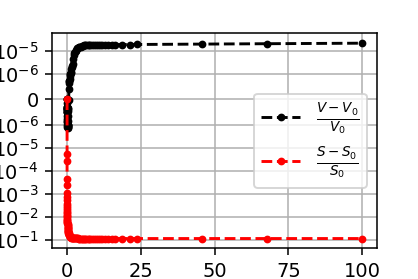

In [414]:
%matplotlib notebook
Vol0, Sqr0,_ = get_VolSqr(P_ar, Z_ar)
plt.figure(figsize=(3,2))
plt.grid()
Vol_ar=[]
Sqr_ar=[]
for j in range(len(sol_bdf.t)):
    Vol,Sqr,_ = get_VolSqr(get_P_with0(sol_bdf.y[:N-1,j]), sol_bdf.y[N-1:,j])
    Vol_ar.append(Vol)
    Sqr_ar.append(Sqr)
Vol_ar=np.array(Vol_ar)
Sqr_ar=np.array(Sqr_ar)   
plt.plot(sol_bdf.t, Vol_ar/Vol0-1,'.--', color='k', label=r'$\frac{V-V_0}{V_0}$')
plt.plot(sol_bdf.t, Sqr_ar/Sqr0-1,'.--', color='r', label=r'$\frac{S-S_0}{S_0}$')

plt.legend()
plt.xlabel(r'$t$')
plt.yscale('symlog', linthresh=1e-6)

In [415]:
%matplotlib inline
@interact_manual(j=(0,len(sol_bdf.t)-1))
def plot_fields_j(j):
    P_j, Z_j = get_P_with0(sol_bdf.y[:N-1,j]), sol_bdf.y[N-1:,j]
    plt.figure()
    plt.title(f't={sol_bdf.t[j]:.3f}')
    plt.plot(np.abs(np.fft.rfft(get_ext_array(Z_j), norm='forward')),'.--',ms=15, label=r'$Z_k$')
    plt.plot(np.abs(np.fft.rfft(get_ext_array(get_force_from_ar(P_j, Z_j)), norm='forward')),'.--',ms=15, label=r'$f_k$')
    
    plt.plot(np.abs(np.fft.rfft(get_ext_array(get_velo_h(P_j, Z_j)[1]), norm='forward')),'.--',ms=15, label=r'$v^z_k$')
    
    
    plt.xlim(0,N*2)
    plt.ylim(1e-10, 1e2)
    
    plt.legend()
    plt.yscale('log')

interactive(children=(IntSlider(value=41, description='j', max=83), Button(description='Run Interact', style=B…

In [417]:
sol_rk = sc.integrate.solve_ivp(lambda t,pz: get_velo_h_normal_1d(pz), (0., 2), np.concatenate([P_ar[1:-1], Z_ar]), 
                                   method='RK45', atol=1e-8, rtol=1e-5);

/tmp/ipykernel_89112/1385853270.py:27: RuntimeWarning: invalid value encountered in subtract
  K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
/tmp/ipykernel_89112/1385853270.py:28: RuntimeWarning: invalid value encountered in multiply
  -Z1.reshape(1,-1)*G_rhorho_tilde_mesh


Text(0.5, 1.0, 'form')

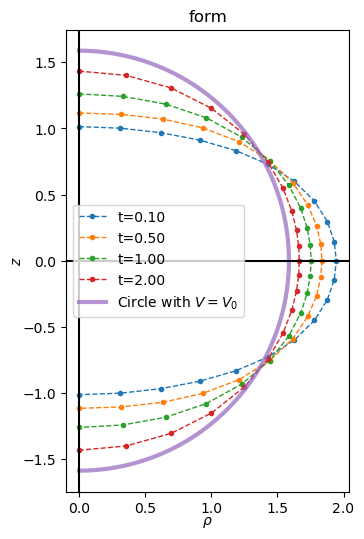

In [418]:
plt.figure(figsize=(6,6))
for t_j in [0.1,0.5, 1,2]:#range(len(sol_radau.t)):
    j = np.argmin(np.abs(sol_rk.t-t_j))
    plt.plot(np.concatenate([[0.],sol_rk.y[:N-1,j],[0.]]), sol_rk.y[N-1:,j],'.--',
             lw=1, ms=6, label=f't={sol_rk.t[j]:.2f}')


plt.plot(P_Vol0,Z_Vol0, lw=3, label=r'Circle with $V=V_0$', alpha=0.7)    
    
    
plt.axis('scaled')
plt.legend()
plt.axvline(0, color='k')
plt.axhline(0, color='k')

plt.xlabel(r'$\rho$', labelpad=-1)
plt.ylabel(r'$z$', labelpad=-1)
plt.title('form')

<IPython.core.display.Javascript object>


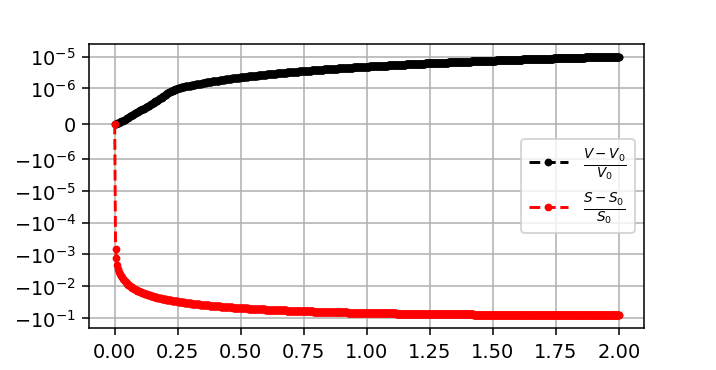

In [419]:
%matplotlib notebook
Vol0, Sqr0,_ = get_VolSqr(P_ar, Z_ar)
plt.figure(figsize=(3,2))
plt.grid()
Vol_ar=[]
Sqr_ar=[]
for j in range(len(sol_rk.t)):
    Vol,Sqr,_ = get_VolSqr(get_P_with0(sol_rk.y[:N-1,j]), sol_rk.y[N-1:,j])
    Vol_ar.append(Vol)
    Sqr_ar.append(Sqr)
Vol_ar=np.array(Vol_ar)
Sqr_ar=np.array(Sqr_ar)   
plt.plot(sol_rk.t, Vol_ar/Vol0-1,'.--', color='k', label=r'$\frac{V-V_0}{V_0}$')
plt.plot(sol_rk.t, Sqr_ar/Sqr0-1,'.--', color='r', label=r'$\frac{S-S_0}{S_0}$')

plt.legend()
plt.xlabel(r'$t$')
plt.yscale('symlog', linthresh=1e-6)

In [420]:
%matplotlib inline
@interact_manual(j=(0,len(sol_rk.t)-1))
def plot_fields_j(j):
    P_j, Z_j = get_P_with0(sol_rk.y[:N-1,j]), sol_rk.y[N-1:,j]
    plt.figure()
    plt.title(f't={sol_rk.t[j]:.3f}')
    plt.plot(np.abs(np.fft.rfft(get_ext_array(Z_j), norm='forward')),'.--',ms=15, label=r'$Z_k$')
    plt.plot(np.abs(np.fft.rfft(get_ext_array(get_force_from_ar(P_j, Z_j)), norm='forward')),'.--',ms=15, label=r'$f_k$')
    
    plt.plot(np.abs(np.fft.rfft(get_ext_array(get_velo_h(P_j, Z_j)[1]), norm='forward')),'.--',ms=15, label=r'$v^z_k$')
    
    
    plt.xlim(0,N*2)
    plt.ylim(1e-10, 1e2)
    
    plt.legend()
    plt.yscale('log')

interactive(children=(IntSlider(value=572, description='j', max=1144), Button(description='Run Interact', styl…

## Surface tension work

In [15]:
def get_div_v_oper_fur(P, P1, P2, Z, Z1, Z2, H):
    """
    Return div_v_i[sigma_j]
    """
    ### fileds ###
    V = np.sqrt(P1**2+Z1**2)
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    ### kernals G ###
    G_tilde_mesh = get_all_G_tilde(P, P_int, Z, Z_int)
    G_rhorho_tilde_mesh = G_tilde_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tilde_mesh[0,1]
    G_zz_tilde_mesh     = G_tilde_mesh[1,1]
    G_zrho_tilde_mesh   = G_tilde_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    
    ### kernals dG (tilde) ###
    d_rhoG, d_zG = get_dG_tilde(P, P_int, Z, Z_int)
        
    d_rhoG_rhorho = d_rhoG[0,0]; d_rhoG_rhoz = d_rhoG[0,1]
    d_rhoG_zrho   = d_rhoG[1,0]; d_rhoG_zz   = d_rhoG[1,1]
    
    d_zG_rhorho = d_zG[0,0]; d_zG_rhoz = d_zG[0,1]
    d_zG_zrho   = d_zG[1,0]; d_zG_zz   = d_zG[1,1]

    
    ### vector kernals ###
    D_rho = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhorho + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zrho+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhorho+d_rhoG_zrho)+\
            (1/P_int).reshape(-1,1)*(G_rhorho_tilde_mesh)
    D_z = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhoz + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zz+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhoz+d_rhoG_zz)+\
            (1/P_int).reshape(-1,1)*(G_rhoz_tilde_mesh)

    D_z[0,:] = D_z_axis_part(Z_int[0]-Z, P); D_z[-1,:] = D_z_axis_part(Z_int[-1]-Z, P)
    D_rho[0,:] = D_rho_axis_part(Z_int[0]-Z, P);D_rho[-1,:] = D_rho_axis_part(Z_int[-1]-Z, P)
    D_z[0,0] = np.pi*Z2_int[0]/P1_int[0]**2;D_z[-1,-1] = np.pi*Z2_int[-1]/P1_int[-1]**2

    ### normal and tau response ###
    D_n = -Z1.reshape(1,-1)*D_rho + P1.reshape(1,-1)*D_z
    D_tau = P1.reshape(1,-1)*D_rho + Z1.reshape(1,-1)*D_z

    D_n[0,0] = -Z2_int[0]*2*np.pi/P1_int[0]+P1_int[0]*D_z[0,0]
    D_n[-1,-1] = -Z2_int[-1]*2*np.pi/P1_int[-1]+P1_int[-1]*D_z[-1,-1]


    D_tau[1:-1][Kron[1:-1]]=0
    D_n[1:-1][Kron[1:-1]]=0

    ### singular part of tau ###
    D_tau_ln = (P1_int/P_int).reshape(-1,1)*\
                        np.log(8*(P_int/V_int).reshape(-1,1)/np.abs(dtau_int))
    D_tau_ln[0,:]=0;D_tau_ln[-1,:]=0

    D_tau_0 = (P1_int*P2_int+Z1_int*Z2_int)/V_int**2 - 3*P1_int*Z1_int**2/P_int/V_int**2
    D_tau_0[0]=0;D_tau_0[-1]=0

    D_tau_ov = 2/(-dtau_int)
    D_tau_ov[0]=0;D_tau_ov[-1]=0

    D_tau_sing = D_tau_ln + D_tau_ov
    D_tau_sing[1:-1][Kron[1:-1]]=0

    ### Weigted opers ###

    I_ln = (1+tau_int*np.log(8*P_int/V_int/tau_int)+
                      (1-tau_int)*np.log(8*P_int/V_int/(1-tau_int)))
    I_ov = 2*np.log((1-tau_int)/tau_int)



    Int_D_tau_reg_oper = D_tau * weights_simp.reshape(1,-1)
    Int_D_tau_reg_oper[0,0]=0;Int_D_tau_reg_oper[-1,-1]=0

    Int_D_tau_reg_sing_oper = -np.diag(D_tau_sing @ weights_simp)
    Int_D_tau_reg_0_oper = np.diag(D_tau_0*weights_simp[::N_int//n_int])
    Int_D_tau_reg_der_oper = 2*np.diag(weights_simp[::N_int//n_int])



    Int_D_tau_reg_der_oper[0,0] = 2*np.pi*weights_simp[0];Int_D_tau_reg_der_oper[-1,-1] = 2*np.pi*weights_simp[-1]


    Int_D_tau_sing_oper = np.diag(P1_int/P_int*I_ln + I_ov)
    Int_D_tau_sing_oper[0]=0;Int_D_tau_sing_oper[-1]=0


    def get_div_v(sigma_fur):
        sigma, sigma1,sigma2,_,_ = get_int_fields(sigma_fur)

        tan_force = sigma1/V
        norm_force = -H*sigma

        tan_force_der_int = (sigma2/V)[::N_int//n_int]-\
                                    sigma1[::N_int//n_int]*((P1_int*P2_int+Z1_int*Z2_int)/V_int**3)

        Div_v_tau = Int_D_tau_reg_oper      @ tan_force +\
                    Int_D_tau_reg_sing_oper @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_0_oper    @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_der_oper  @ tan_force_der_int+\
                    Int_D_tau_sing_oper     @ tan_force[::N_int//n_int]

        Div_v_n = D_n * weights_simp.reshape(1,-1)      @ norm_force -\
                         (D_n @ weights_simp) * norm_force[::N_int//n_int]


        Div_v_sum = Div_v_n + Div_v_tau
        Div_v_sum /= 8*np.pi
        return Div_v_sum
    Div_v_sum_oper = np.apply_along_axis(get_div_v, 0,np.eye(N_sigma))

    Div_v_sum_oper_fur = np.fft.rfft(np.apply_along_axis(get_ext_array,0,Div_v_sum_oper), norm='forward', axis=0).real
    return Div_v_sum_oper_fur

In [16]:
def get_div_v_oper(P, P1, P2, Z, Z1, Z2, H):
    """
    Return div_v_i[varphi_j] i - in real space
    """
    ### fileds ###
    V = np.sqrt(P1**2+Z1**2)
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    ### kernals G ###
    G_tilde_mesh = get_all_G_tilde(P, P_int, Z, Z_int)
    G_rhorho_tilde_mesh = G_tilde_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tilde_mesh[0,1]
    G_zz_tilde_mesh     = G_tilde_mesh[1,1]
    G_zrho_tilde_mesh   = G_tilde_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    
    ### kernals dG (tilde) ###
    d_rhoG, d_zG = get_dG_tilde(P, P_int, Z, Z_int)
        
    d_rhoG_rhorho = d_rhoG[0,0]; d_rhoG_rhoz = d_rhoG[0,1]
    d_rhoG_zrho   = d_rhoG[1,0]; d_rhoG_zz   = d_rhoG[1,1]
    
    d_zG_rhorho = d_zG[0,0]; d_zG_rhoz = d_zG[0,1]
    d_zG_zrho   = d_zG[1,0]; d_zG_zz   = d_zG[1,1]

    
    ### vector kernals ###
    D_rho = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhorho + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zrho+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhorho+d_rhoG_zrho)+\
            (1/P_int).reshape(-1,1)*(G_rhorho_tilde_mesh)
    D_z = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhoz + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zz+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhoz+d_rhoG_zz)+\
            (1/P_int).reshape(-1,1)*(G_rhoz_tilde_mesh)

    D_z[0,:] = D_z_axis_part(Z_int[0]-Z, P); D_z[-1,:] = D_z_axis_part(Z_int[-1]-Z, P)
    D_rho[0,:] = D_rho_axis_part(Z_int[0]-Z, P);D_rho[-1,:] = D_rho_axis_part(Z_int[-1]-Z, P)
    D_z[0,0] = np.pi*Z2_int[0]/P1_int[0]**2;D_z[-1,-1] = np.pi*Z2_int[-1]/P1_int[-1]**2

    ### normal and tau response ###
    D_n = -Z1.reshape(1,-1)*D_rho + P1.reshape(1,-1)*D_z
    D_tau = P1.reshape(1,-1)*D_rho + Z1.reshape(1,-1)*D_z

    D_n[0,0] = -Z2_int[0]*2*np.pi/P1_int[0]+P1_int[0]*D_z[0,0]
    D_n[-1,-1] = -Z2_int[-1]*2*np.pi/P1_int[-1]+P1_int[-1]*D_z[-1,-1]


    D_tau[1:-1][Kron[1:-1]]=0
    D_n[1:-1][Kron[1:-1]]=0

    ### singular part of tau ###
    D_tau_ln = (P1_int/P_int).reshape(-1,1)*\
                        np.log(8*(P_int/V_int).reshape(-1,1)/np.abs(dtau_int))
    D_tau_ln[0,:]=0;D_tau_ln[-1,:]=0

    D_tau_0 = (P1_int*P2_int+Z1_int*Z2_int)/V_int**2 - 3*P1_int*Z1_int**2/P_int/V_int**2
    D_tau_0[0]=0;D_tau_0[-1]=0

    D_tau_ov = 2/(-dtau_int)
    D_tau_ov[0]=0;D_tau_ov[-1]=0

    D_tau_sing = D_tau_ln + D_tau_ov
    D_tau_sing[1:-1][Kron[1:-1]]=0

    ### Weigted opers ###

    I_ln = (1+tau_int*np.log(8*P_int/V_int/tau_int)+
                      (1-tau_int)*np.log(8*P_int/V_int/(1-tau_int)))
    I_ov = 2*np.log((1-tau_int)/tau_int)



    Int_D_tau_reg_oper = D_tau * weights_simp.reshape(1,-1)
    Int_D_tau_reg_oper[0,0]=0;Int_D_tau_reg_oper[-1,-1]=0

    Int_D_tau_reg_sing_oper = -np.diag(D_tau_sing @ weights_simp)
    Int_D_tau_reg_0_oper = np.diag(D_tau_0*weights_simp[::N_int//n_int])
    Int_D_tau_reg_der_oper = 2*np.diag(weights_simp[::N_int//n_int])



    Int_D_tau_reg_der_oper[0,0] = 2*np.pi*weights_simp[0];Int_D_tau_reg_der_oper[-1,-1] = 2*np.pi*weights_simp[-1]


    Int_D_tau_sing_oper = np.diag(P1_int/P_int*I_ln + I_ov)
    Int_D_tau_sing_oper[0]=0;Int_D_tau_sing_oper[-1]=0


    def get_div_v(sigma_fur):
        sigma, sigma1,sigma2,_,_ = get_int_fields(sigma_fur)

        tan_force = sigma1/V
        norm_force = -H*sigma

        tan_force_der_int = (sigma2/V)[::N_int//n_int]-\
                                    sigma1[::N_int//n_int]*((P1_int*P2_int+Z1_int*Z2_int)/V_int**3)

        Div_v_tau = Int_D_tau_reg_oper      @ tan_force +\
                    Int_D_tau_reg_sing_oper @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_0_oper    @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_der_oper  @ tan_force_der_int+\
                    Int_D_tau_sing_oper     @ tan_force[::N_int//n_int]

        Div_v_n = D_n * weights_simp.reshape(1,-1)      @ norm_force -\
                         (D_n @ weights_simp) * norm_force[::N_int//n_int]


        Div_v_sum = Div_v_n + Div_v_tau
        Div_v_sum /= 8*np.pi
        return Div_v_sum
    Div_v_sum_oper = np.apply_along_axis(get_div_v, 0,np.eye(N_sigma))
    Div_v_sum_oper_fur = np.fft.rfft(np.apply_along_axis(get_ext_array,0,Div_v_sum_oper), norm='forward', axis=0).real
    return Div_v_sum_oper_fur

In [17]:
def get_sigma_fur_new(P, P1, P2, Z, Z1, Z2, H, force):
    """
    Return sigma_fur 
    """
    ### fileds ###
    V = np.sqrt(P1**2+Z1**2)
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    ### kernals G ###
    G_tilde_mesh = get_all_G_tilde(P, P_int, Z, Z_int)
    G_rhorho_tilde_mesh = G_tilde_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tilde_mesh[0,1]
    G_zz_tilde_mesh     = G_tilde_mesh[1,1]
    G_zrho_tilde_mesh   = G_tilde_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    
    ### kernals dG (tilde) ###
    d_rhoG, d_zG = get_dG_tilde(P, P_int, Z, Z_int)
        
    d_rhoG_rhorho = d_rhoG[0,0]; d_rhoG_rhoz = d_rhoG[0,1]
    d_rhoG_zrho   = d_rhoG[1,0]; d_rhoG_zz   = d_rhoG[1,1]
    
    d_zG_rhorho = d_zG[0,0]; d_zG_rhoz = d_zG[0,1]
    d_zG_zrho   = d_zG[1,0]; d_zG_zz   = d_zG[1,1]

    ### vector kernals ###
    D_rho = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhorho + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zrho+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhorho+d_rhoG_zrho)+\
            (1/P_int).reshape(-1,1)*(G_rhorho_tilde_mesh)
    D_z = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhoz + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zz+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhoz+d_rhoG_zz)+\
            (1/P_int).reshape(-1,1)*(G_rhoz_tilde_mesh)

    D_z[0,:] = D_z_axis_part(Z_int[0]-Z, P); D_z[-1,:] = D_z_axis_part(Z_int[-1]-Z, P)
    D_rho[0,:] = D_rho_axis_part(Z_int[0]-Z, P);D_rho[-1,:] = D_rho_axis_part(Z_int[-1]-Z, P)
    D_z[0,0] = np.pi*Z2_int[0]/P1_int[0]**2;D_z[-1,-1] = np.pi*Z2_int[-1]/P1_int[-1]**2

    ### normal and tau response ###
    D_n = -Z1.reshape(1,-1)*D_rho + P1.reshape(1,-1)*D_z
    D_tau = P1.reshape(1,-1)*D_rho + Z1.reshape(1,-1)*D_z

    D_n[0,0] = -Z2_int[0]*2*np.pi/P1_int[0]+P1_int[0]*D_z[0,0]
    D_n[-1,-1] = -Z2_int[-1]*2*np.pi/P1_int[-1]+P1_int[-1]*D_z[-1,-1]


    D_tau[1:-1][Kron[1:-1]]=0
    D_n[1:-1][Kron[1:-1]]=0

    ### singular part of tau ###
    D_tau_ln = (P1_int/P_int).reshape(-1,1)*\
                        np.log(8*(P_int/V_int).reshape(-1,1)/np.abs(dtau_int))
    D_tau_ln[0,:]=0;D_tau_ln[-1,:]=0

    D_tau_0 = (P1_int*P2_int+Z1_int*Z2_int)/V_int**2 - 3*P1_int*Z1_int**2/P_int/V_int**2
    D_tau_0[0]=0;D_tau_0[-1]=0

    D_tau_ov = 2/(-dtau_int)
    D_tau_ov[0]=0;D_tau_ov[-1]=0

    D_tau_sing = D_tau_ln + D_tau_ov
    D_tau_sing[1:-1][Kron[1:-1]]=0

    ### Weigted opers ###

    I_ln = (1+tau_int*np.log(8*P_int/V_int/tau_int)+
                      (1-tau_int)*np.log(8*P_int/V_int/(1-tau_int)))
    I_ov = 2*np.log((1-tau_int)/tau_int)



    Int_D_tau_reg_oper = D_tau * weights_simp.reshape(1,-1)
    Int_D_tau_reg_oper[0,0]=0;Int_D_tau_reg_oper[-1,-1]=0

    Int_D_tau_reg_sing_oper = -np.diag(D_tau_sing @ weights_simp)
    Int_D_tau_reg_0_oper = np.diag(D_tau_0*weights_simp[::N_int//n_int])
    Int_D_tau_reg_der_oper = 2*np.diag(weights_simp[::N_int//n_int])



    Int_D_tau_reg_der_oper[0,0] = 2*np.pi*weights_simp[0];Int_D_tau_reg_der_oper[-1,-1] = 2*np.pi*weights_simp[-1]


    Int_D_tau_sing_oper = np.diag(P1_int/P_int*I_ln + I_ov)
    Int_D_tau_sing_oper[0]=0;Int_D_tau_sing_oper[-1]=0


    def get_div_v(sigma_fur):
        sigma, sigma1,sigma2,_,_ = get_int_fields(sigma_fur)

        tan_force = sigma1/V
        norm_force = -H*sigma

        tan_force_der_int = (sigma2/V)[::N_int//n_int]-\
                                    sigma1[::N_int//n_int]*((P1_int*P2_int+Z1_int*Z2_int)/V_int**3)

        Div_v_tau = Int_D_tau_reg_oper      @ tan_force +\
                    Int_D_tau_reg_sing_oper @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_0_oper    @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_der_oper  @ tan_force_der_int+\
                    Int_D_tau_sing_oper     @ tan_force[::N_int//n_int]

        Div_v_n = D_n * weights_simp.reshape(1,-1)      @ norm_force -\
                         (D_n @ weights_simp) * norm_force[::N_int//n_int]


        Div_v_sum = Div_v_n + Div_v_tau
        Div_v_sum /= 8*np.pi
        return Div_v_sum
    Div_v_sum_oper = np.apply_along_axis(get_div_v, 0,np.eye(N_sigma))
    
    Div_v_sum_oper[0,:]*=1/np.sqrt(2);Div_v_sum_oper[-1,:]*=1/np.sqrt(2)
    
    ### find div_v from helfrih force ###
    Div_v_force = D_n * weights_simp.reshape(1,-1)      @ force -\
                         (D_n @ weights_simp) * force[::N_int//n_int]
    Div_v_force /= 8*np.pi
    
    Div_v_force[0]*=1/np.sqrt(2);Div_v_force[-1]*=1/np.sqrt(2)
    
    sigma_fur = sc.linalg.lstsq(Div_v_sum_oper, -Div_v_force)[0]
    
    return sigma_fur

In [18]:
get_sigma_fur=get_sigma_fur_new

In [19]:
def get_div_v_from_force(P, P1, P2, Z, Z1, Z2, norm_force, tan_force):
    """
    Return div_v induced by force 
    """
    ### fileds ###
    V = np.sqrt(P1**2+Z1**2)
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    ### kernals G ###
    G_tilde_mesh = get_all_G_tilde(P, P_int, Z, Z_int)
    G_rhorho_tilde_mesh = G_tilde_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tilde_mesh[0,1]
    G_zz_tilde_mesh     = G_tilde_mesh[1,1]
    G_zrho_tilde_mesh   = G_tilde_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    
    ### kernals dG (tilde) ###
    d_rhoG, d_zG = get_dG_tilde(P, P_int, Z, Z_int)
        
    d_rhoG_rhorho = d_rhoG[0,0]; d_rhoG_rhoz = d_rhoG[0,1]
    d_rhoG_zrho   = d_rhoG[1,0]; d_rhoG_zz   = d_rhoG[1,1]
    
    d_zG_rhorho = d_zG[0,0]; d_zG_rhoz = d_zG[0,1]
    d_zG_zrho   = d_zG[1,0]; d_zG_zz   = d_zG[1,1]

    ### vector kernals ###
    D_rho = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhorho + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zrho+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhorho+d_rhoG_zrho)+\
            (1/P_int).reshape(-1,1)*(G_rhorho_tilde_mesh)
    D_z = (P1_int**2/V_int**2).reshape(-1,1)*d_rhoG_rhoz + \
            (Z1_int**2/V_int**2).reshape(-1,1)*d_zG_zz+\
            (P1_int*Z1_int/V_int**2).reshape(-1,1)*(d_zG_rhoz+d_rhoG_zz)+\
            (1/P_int).reshape(-1,1)*(G_rhoz_tilde_mesh)

    D_z[0,:] = D_z_axis_part(Z_int[0]-Z, P); D_z[-1,:] = D_z_axis_part(Z_int[-1]-Z, P)
    D_rho[0,:] = D_rho_axis_part(Z_int[0]-Z, P);D_rho[-1,:] = D_rho_axis_part(Z_int[-1]-Z, P)
    D_z[0,0] = np.pi*Z2_int[0]/P1_int[0]**2;D_z[-1,-1] = np.pi*Z2_int[-1]/P1_int[-1]**2

    ### normal and tau response ###
    D_n = -Z1.reshape(1,-1)*D_rho + P1.reshape(1,-1)*D_z
    D_tau = P1.reshape(1,-1)*D_rho + Z1.reshape(1,-1)*D_z

    D_n[0,0] = -Z2_int[0]*2*np.pi/P1_int[0]+P1_int[0]*D_z[0,0]
    D_n[-1,-1] = -Z2_int[-1]*2*np.pi/P1_int[-1]+P1_int[-1]*D_z[-1,-1]


    D_tau[1:-1][Kron[1:-1]]=0
    D_n[1:-1][Kron[1:-1]]=0

    ### singular part of tau ###
    D_tau_ln = (P1_int/P_int).reshape(-1,1)*\
                        np.log(8*(P_int/V_int).reshape(-1,1)/np.abs(dtau_int))
    D_tau_ln[0,:]=0;D_tau_ln[-1,:]=0

    D_tau_0 = (P1_int*P2_int+Z1_int*Z2_int)/V_int**2 - 3*P1_int*Z1_int**2/P_int/V_int**2
    D_tau_0[0]=0;D_tau_0[-1]=0

    D_tau_ov = 2/(-dtau_int)
    D_tau_ov[0]=0;D_tau_ov[-1]=0

    D_tau_sing = D_tau_ln + D_tau_ov
    D_tau_sing[1:-1][Kron[1:-1]]=0

    ### Weigted opers ###

    I_ln = (1+tau_int*np.log(8*P_int/V_int/tau_int)+
                      (1-tau_int)*np.log(8*P_int/V_int/(1-tau_int)))
    I_ov = 2*np.log((1-tau_int)/tau_int)



    Int_D_tau_reg_oper = D_tau * weights_simp.reshape(1,-1)
    Int_D_tau_reg_oper[0,0]=0;Int_D_tau_reg_oper[-1,-1]=0

    Int_D_tau_reg_sing_oper = -np.diag(D_tau_sing @ weights_simp)
    Int_D_tau_reg_0_oper = np.diag(D_tau_0*weights_simp[::N_int//n_int])
    Int_D_tau_reg_der_oper = 2*np.diag(weights_simp[::N_int//n_int])



    Int_D_tau_reg_der_oper[0,0] = 2*np.pi*weights_simp[0];Int_D_tau_reg_der_oper[-1,-1] = 2*np.pi*weights_simp[-1]


    Int_D_tau_sing_oper = np.diag(P1_int/P_int*I_ln + I_ov)
    Int_D_tau_sing_oper[0]=0;Int_D_tau_sing_oper[-1]=0


    def get_div_v(sigma_fur):
        sigma, sigma1,sigma2,_,_ = get_int_fields(sigma_fur)

        tan_force = sigma1/V
        norm_force = -H*sigma

        tan_force_der_int = (sigma2/V)[::N_int//n_int]-\
                                    sigma1[::N_int//n_int]*((P1_int*P2_int+Z1_int*Z2_int)/V_int**3)

        Div_v_tau = Int_D_tau_reg_oper      @ tan_force +\
                    Int_D_tau_reg_sing_oper @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_0_oper    @ tan_force[::N_int//n_int]+\
                    Int_D_tau_reg_der_oper  @ tan_force_der_int+\
                    Int_D_tau_sing_oper     @ tan_force[::N_int//n_int]

        Div_v_n = D_n * weights_simp.reshape(1,-1)      @ norm_force -\
                         (D_n @ weights_simp) * norm_force[::N_int//n_int]


        Div_v_sum = Div_v_n + Div_v_tau
        Div_v_sum /= 8*np.pi
        return Div_v_sum
    Div_v_sum_oper = np.apply_along_axis(get_div_v, 0,np.eye(N_sigma))
    Div_v_sum_oper_fur = np.fft.rfft(np.apply_along_axis(get_ext_array,0,Div_v_sum_oper), norm='forward', axis=0).real
    
    
    ### find div_v from helfrih force ###
    Div_v_force = D_n * weights_simp.reshape(1,-1)      @ force -\
                         (D_n @ weights_simp) * force[::N_int//n_int]
    Div_v_force /= 8*np.pi
    Div_v_force_fur =  np.fft.rfft(get_ext_array(Div_v_force), norm='forward').real
    
    sigma_fur = sc.linalg.solve(Div_v_sum_oper_fur[:N_sigma,:],-Div_v_force_fur[:N_sigma])
    return sigma_fur

In [20]:
def get_sigma_fur_from_arr(P_fur, Z_fur):
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)

    H, force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 
    
    ### find surface tension ###
    sigma_fur = get_sigma_fur(P, P1, P2, Z, Z1, Z2, H, force)
    return sigma_fur

## Main function

In [21]:
def get_velo_from_forces(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4, norm_force, tan_force):
    """
    Return velocity induced by normal force and tangent
    """
    
    ### fields prepare ###
    V = np.sqrt(P1**2+Z1**2)
    V_int = V[::N_int//n_int]
    Z_int = Z[::N_int//n_int]
    P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int]
    P1_int = P1[::N_int//n_int]
    
    norm_force_int = norm_force[::N_int//n_int]
    tan_force_int = tan_force[::N_int//n_int]
    
    
    ### kernals G ###
    G_tild_mesh = get_all_G_tilde(P, P_int, Z, Z_int)

    G_rhorho_tilde_mesh = G_tild_mesh[0,0]
    G_rhoz_tilde_mesh   = G_tild_mesh[0,1]
    G_zz_tilde_mesh     = G_tild_mesh[1,1]
    G_zrho_tilde_mesh   = G_tild_mesh[1,0]
    
    ### Axis expression ###
    G_zz_tilde_mesh[0,0]=2*np.pi;G_zz_tilde_mesh[-1,-1]=2*np.pi
    G_zrho_tilde_mesh[0,0]=0;G_zrho_tilde_mesh[-1,-1]=0
    
    ### Normal kernals ###
    K_rho =  P1.reshape(1,-1)*G_rhoz_tilde_mesh\
                     -Z1.reshape(1,-1)*G_rhorho_tilde_mesh    
    K_rho[Kron]=0
    K_rho[0]=0; K_rho[-1]=0

    K_z =  P1.reshape(1,-1)*G_zz_tilde_mesh\
                     -Z1.reshape(1,-1)*G_zrho_tilde_mesh
    K_z[1:-1][Kron[1:-1]]=0

    ### normal response ###
    V_rho_norm = K_rho @ (weights_simp*norm_force) - (norm_force_int.reshape(-1,1)*K_rho) @ weights_simp
    V_rho_norm /= 8*np.pi
    
    V_z_norm = K_z @ (weights_simp*norm_force) - (norm_force_int.reshape(-1,1)*K_z) @ weights_simp
    V_z_norm /= 8*np.pi
    

    ### tan response ###
    
    K_rhotau = Z1.reshape(1,-1)*G_rhoz_tilde_mesh+\
               P1.reshape(1,-1)*G_rhorho_tilde_mesh
    K_rhotau[Kron]=0

    K_rhotau_ln = P1_int.reshape(-1,1)*2*\
                        np.log(8*(P_int/V_int).reshape(-1,1)/np.abs(dtau_int))
    K_rhotau_ln[Kron]=0
    
    K_rhotau_0 = -4*P1_int
    
    I_ln = (1+tau_int*np.log(8*P_int/V_int/tau_int)+
                      (1-tau_int)*np.log(8*P_int/V_int/(1-tau_int)))

    
    I_K_rhotau_ln = 2*P1_int*I_ln

    
    K_ztau = Z1.reshape(1,-1)*G_zz_tilde_mesh+\
               P1.reshape(1,-1)*G_zrho_tilde_mesh
    K_ztau[1:-1][Kron[1:-1]]=0
    
    K_ztau_ln = Z1_int.reshape(-1,1)*2*\
                        np.log(8*(P_int/V_int).reshape(-1,1)/np.abs(dtau_int))
    K_ztau_ln[0,:]=0;K_ztau_ln[-1,:]=0
    K_ztau_ln[1:-1][Kron[1:-1]]=0
    
    K_ztau_0 = 2*Z1_int
    K_ztau_0[0]=0; K_ztau_0[-1]=0
    
    
    I_K_ztau_ln = 2*Z1_int*I_ln
    I_K_ztau_ln[0]=0;I_K_ztau_ln[-1]=0
    
    
    
    V_z_tan = K_ztau @ (weights_simp*tan_force)\
                    -(K_ztau_ln @ weights_simp) * tan_force_int\
                    +K_ztau_0*tan_force_int*weights_simp[::N_int//n_int]\
                    +I_K_ztau_ln*(tan_force_int)
    V_z_tan /= 8*np.pi
    
    V_rho_tan = K_rhotau @ (weights_simp*tan_force)\
                    -(K_rhotau_ln @ weights_simp) * tan_force_int\
                    +K_rhotau_0*tan_force_int*weights_simp[::N_int//n_int]\
                    +I_K_rhotau_ln*(tan_force_int)
    V_rho_tan[0]=0;V_rho_tan[-1]=0
    
    V_rho_tan /= 8*np.pi
    #print(V_z_tan, V_z_norm)
    return V_rho_tan+V_rho_norm, V_z_tan+V_z_norm

In [22]:
def get_velo(P_fur, Z_fur):
    """
    Find full velocity at n_int points
    """
    ### find fields ###
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)

    H, force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 
    
    ### find surface tension ###
    sigma_fur = get_sigma_fur(P, P1, P2, Z, Z1, Z2, H, force)
    sigma, sigma1,_,_,_ = get_int_fields(sigma_fur)
    tan_force_sigma = sigma1/V
    norm_force_sigma = -H*sigma
    
    V_rho, V_z = get_velo_from_forces(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4, force+norm_force_sigma, tan_force_sigma)

    return V_rho, V_z

In [23]:
def get_velo_fur(P_fur, Z_fur):
    """
    Find N furier components of velocity 
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    
    V_rho_fur = np.fft.rfft(get_ext_array(V_rho,'p'), norm='forward')[:N]
    V_z_fur = np.fft.rfft(get_ext_array(V_z,'z'), norm='forward')[:N]
    return (V_rho_fur/(-1j)).real, V_z_fur.real

def get_velo_fur_full(P_fur, Z_fur):
    """
    Find all n_int furier components of velocity 
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    
    V_rho_fur = np.fft.rfft(get_ext_array(V_rho,'p'), norm='forward')
    V_z_fur = np.fft.rfft(get_ext_array(V_z,'z'), norm='forward')
    return (V_rho_fur/(-1j)).real, V_z_fur.real

In [24]:
def get_velo_normal_fur_full(P_fur, Z_fur): 
    """
    Find all n_int furier components from normal velocity 
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)
    
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int] 
    V_int = V[::N_int//n_int]

    V_normal = V_rho*(-Z1_int/V_int)+V_z*(P1_int/V_int)
    V_rho_normal = V_normal*(-Z1_int/V_int)
    V_z_normal = V_normal*(P1_int/V_int)
    
    V_rho_normal_fur = np.fft.rfft(get_ext_array(V_rho_normal,'p'), norm='forward')
    V_z_normal_fur = np.fft.rfft(get_ext_array(V_z_normal,'z'), norm='forward')
    return (V_rho_normal_fur/(-1j)).real, V_z_normal_fur.real

def get_velo_normal_fur(P_fur, Z_fur): 
    """
    Find N furier components from normal velocity 
    """    
    V_rho, V_z = get_velo(P_fur, Z_fur)
    
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)
    
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    V_normal = V_rho*(-Z1_int/V_int)+V_z*(P1_int/V_int)
    V_rho_normal = V_normal*(-Z1_int/V_int)
    V_z_normal = V_normal*(P1_int/V_int)
    
    V_rho_normal_fur = np.fft.rfft(get_ext_array(V_rho_normal,'p'), norm='forward')
    V_z_normal_fur = np.fft.rfft(get_ext_array(V_z_normal,'z'), norm='forward')
    return (V_rho_normal_fur/(-1j)).real[:N], V_z_normal_fur.real[:N]

In [25]:
def get_velo_normal_(P_fur, Z_fur): 
    """
    Find N furier components from normal velocity 
    """    
    V_rho, V_z = get_velo(P_fur, Z_fur)
    
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)
    
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    V_normal = V_rho*(-Z1_int/V_int)+V_z*(P1_int/V_int)
    V_rho_normal = V_normal*(-Z1_int/V_int)
    V_z_normal = V_normal*(P1_int/V_int)
    
    V_rho_normal_fur = np.fft.rfft(get_ext_array(V_rho_normal,'p'), norm='forward')
    V_z_normal_fur = np.fft.rfft(get_ext_array(V_z_normal,'z'), norm='forward')
    return V_rho_normal,V_z_normal

In [26]:
def get_corr_velo(P_fur,Z_fur,velo):
    """
    Find corrected velo consevating V along dynamics 
    """    
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)
    H1,_ = get_H12_from_ar(P_fur,Z_fur)
    
    e_tau = np.array([P1[::N_int//n_int],Z1[::N_int//n_int]])/V[::N_int//n_int]
    e_n = np.array([-Z1[::N_int//n_int],P1[::N_int//n_int]])/V[::N_int//n_int]

    velo_n = (velo*e_n).sum(axis=0)

    Der_velo_tau = - H1[::N_int//n_int]*V[::N_int//n_int]*velo_n

    Der_velo_tau_fft = np.fft.rfft(get_ext_array(Der_velo_tau), norm='forward')

    der_oper = 1j*np.pi*np.arange(Der_velo_tau_fft.shape[0])
    velo_tau_fft = Der_velo_tau_fft.real/der_oper
    velo_tau_fft[0]=0.

    velo_tau = np.fft.irfft(velo_tau_fft, norm='forward', n=2*n_int)[:n_int+1]

    velo_corr = e_tau*velo_tau + e_n*velo_n
    return velo_corr

In [27]:
def get_corr_velo_fur(P_fur,Z_fur):
    """
    Find N furier components from corrected velocity adiabatic
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    velo = np.array([V_rho, V_z])
    velo_corr = get_corr_velo(P_fur,Z_fur,velo)

    V_rho_fur = np.fft.rfft(get_ext_array(velo_corr[0],'p'), norm='forward')
    V_z_fur = np.fft.rfft(get_ext_array(velo_corr[1],'z'), norm='forward')
    return (V_rho_fur/(-1j)).real[:N], V_z_fur.real[:N]    

def get_corr_velo_fur_full(P_fur,Z_fur):
    """
    Find N furier components from corrected velocity adiabatic
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    velo = np.array([V_rho, V_z])
    velo_corr = get_corr_velo(P_fur,Z_fur,velo)

    V_rho_fur = np.fft.rfft(get_ext_array(velo_corr[0],'p'), norm='forward')
    V_z_fur = np.fft.rfft(get_ext_array(velo_corr[1],'z'), norm='forward')
    return (V_rho_fur/(-1j)).real, V_z_fur.real    

In [28]:
def get_velo_norm_fur(P_fur, Z_fur): 
    """
    Find N furier components of normal velocity 
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)
    
    Z_int = Z[::N_int//n_int];P_int = P[::N_int//n_int]
    Z1_int = Z1[::N_int//n_int];P1_int = P1[::N_int//n_int]
    Z2_int = Z2[::N_int//n_int];P2_int = P2[::N_int//n_int]
    V_int = V[::N_int//n_int]

    V_normal = V_rho*(-Z1_int/V_int)+V_z*(P1_int/V_int)

    V_normal_fur = np.fft.rfft(get_ext_array(V_normal,'z'), norm='forward')
    return V_normal_fur.real[:N]

In [29]:
def get_corr_velo_(P_fur,Z_fur):
    """
    Find N furier components from corrected velocity adiabatic
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    velo = np.array([V_rho, V_z])
    velo_corr = get_corr_velo(P_fur,Z_fur,velo)

    return velo_corr

## Symmetric pearling

In [30]:
def get_velo(P_fur, Z_fur):
    """
    Find full velocity at n_int points
    """
    ### find fields ###
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)

    H, force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 
    force += force_gamma
    ### find surface tension ###
    sigma_fur = get_sigma_fur(P, P1, P2, Z, Z1, Z2, H, force)
    sigma, sigma1,_,_,_ = get_int_fields(sigma_fur)
    tan_force_sigma = sigma1/V
    norm_force_sigma = -H*sigma
    
    V_rho, V_z = get_velo_from_forces(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4, force+norm_force_sigma, tan_force_sigma)

    return V_rho, V_z

In [31]:
def get_corr_velo_(P_fur,Z_fur):
    """
    Find N furier components from corrected velocity adiabatic
    """
    V_rho, V_z = get_velo(P_fur, Z_fur)
    velo = np.array([V_rho, V_z])
    velo_corr = get_corr_velo(P_fur,Z_fur,velo)

    return velo_corr

In [32]:
def get_corr_velo_projects_full(P_fur,Z_fur):
    velo_rho,velo_z = get_corr_velo_(P_fur,Z_fur)
    
    velo_rho_fur = (np.fft.rfft(get_ext_array(velo_rho,'p'), norm='forward')[1:]*1j).real
    velo_z_fur = np.fft.rfft(get_ext_array(velo_z,'z'), norm='forward').real
    return velo_rho_fur, velo_z_fur

In [33]:
def get_normal_velo_projects_full(P_fur,Z_fur):
    ### find fields ###
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)
    V = np.sqrt(P1**2+Z1**2)

    
    H, force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 
    
    velo_rho,velo_z = get_velo_normal_(P_fur,Z_fur)
    
    velo_rho_fur = (np.fft.rfft(get_ext_array(velo_rho,'p'), norm='forward')[1:]*1j).real
    velo_z_fur = np.fft.rfft(get_ext_array(velo_z,'z'), norm='forward').real
    return velo_rho_fur, velo_z_fur

In [34]:
def get_PZ_fur_from_pz_sym(pz_sym):
    N_ = len(pz_sym)
    P_fur = np.zeros(N_); Z_fur = np.zeros(N_)
    P_fur[1::2]=pz_sym[::2]
    Z_fur[1::2]=pz_sym[1::2]
    return P_fur, Z_fur


def get_pz_sym_from_PZ_fur(P_fur, Z_fur):
    N_ = len(Z_fur)
    pz_sym = np.zeros(N_)
    pz_sym[::2]=P_fur[:N_][1::2]
    pz_sym[1::2]=Z_fur[:N_][1::2]
    return pz_sym

In [35]:
def get_corr_velo_sym_fur_1d(pz_sym):
    N_ = len(pz_sym)
    P_fur, Z_fur = get_PZ_fur_from_pz_sym(pz_sym)
    veloP, veloZ = get_corr_velo_projects_full(P_fur, Z_fur)
    return get_pz_sym_from_PZ_fur(np.concatenate([[0],veloP])[:N_], veloZ[:N_])

In [36]:
N_jac = 300
N_sigma=340


n_int = 500
N_int = n_int*10

Tau_int = np.arange(N_int+1)/(N_int);tau_int = np.arange(n_int+1)/(n_int)

dtau_int = tau_int.reshape(-1,1) - Tau_int.reshape(1,-1) 

weights_simp1 = np.zeros_like(Tau_int);weights_simp2 = np.zeros_like(Tau_int)

weights_simp1 +=1;weights_simp1[0]=1/2; weights_simp1[-1]=1/2

weights_simp2[::2] +=1;weights_simp2[::2][0]=1/2; weights_simp2[::2][-1]=1/2

weights_simp = 4/3*weights_simp1 - 2/3*weights_simp2
weights_simp /= N_int

Kron = (np.abs(dtau_int)<1e-7)
AKron = ~Kron

### Initial state prepare

In [54]:
pz = np.load('prolate_equilib_Vcal=3.0709e-01_N=75.npy')
Pfur_0,Zfur_0 =  get_PZ_fur_from_pz_sym(pz)
N = 200

Pfur_0,Zfur_0 = make_constant_v_repar(Pfur_0,Zfur_0, N)
P, P1,P2,P3,P4 = get_int_fields(-1j*Pfur_0)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Zfur_0)
Pfur_0 /= P[N_int//2];Zfur_0 /= P[N_int//2]
P, P1,P2,P3,P4 = get_int_fields(-1j*Pfur_0)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Zfur_0)
V = np.sqrt(P1**2+Z1**2)
l_rho = -Z1/V;l_z = P1/V;

In [64]:
H, force =get_H_force_from_ar(Pfur_0,Zfur_0)

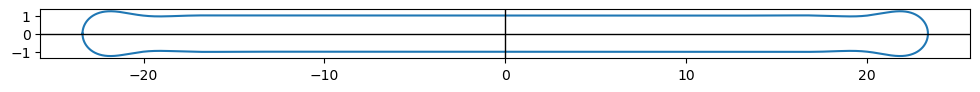

In [65]:
plt.figure(figsize=(12,3))
plt.plot(np.hstack([Z[::-1],Z]),np.hstack([-P[::-1],P]))
plt.axvline(0, color='k', lw=1)
plt.axhline(0, color='k', lw=1)

plt.axis('scaled');

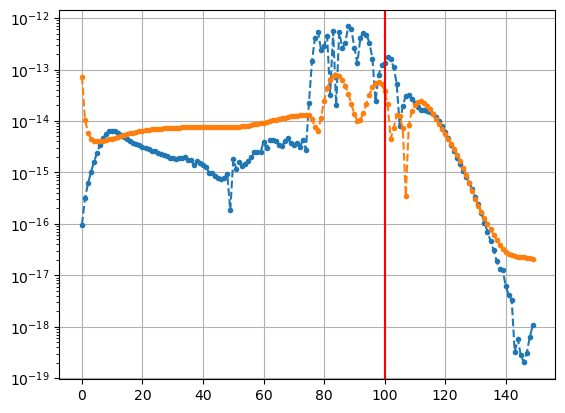

In [207]:
plt.figure()
plt.plot(abs(get_corr_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')


plt.plot(abs(get_corr_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')
plt.axvline(N//2, color='red')
plt.yscale('log')
plt.grid()

#### Add variate

In [68]:
delta_N_fur = np.load('sym_most_unstable_mode_prolate_Vcal=3.0709e-01_gam=4.npy')

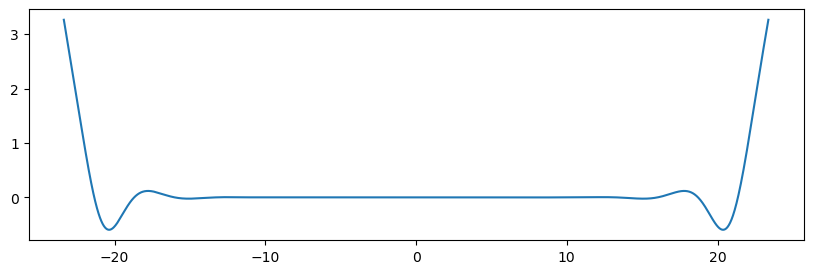

In [69]:
gam = 4.
force_gamma = gam*(H-H[N_int//2])
plt.figure(figsize=(10,3))
plt.plot(Z, force_gamma)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-2.0, 2.0)

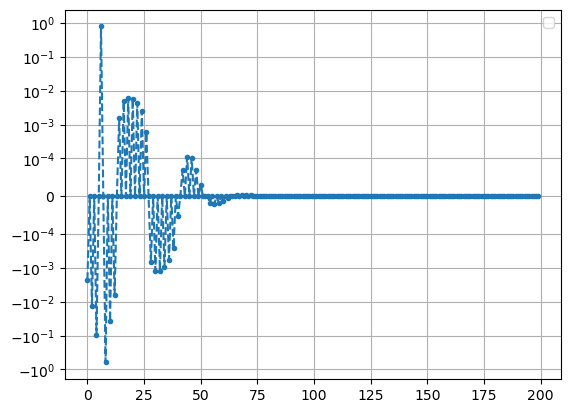

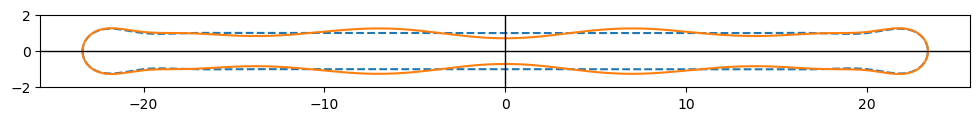

In [210]:
plt.figure()
plt.plot(delta_N_fur, '.--')
plt.yscale('symlog', linthresh=1e-4)
plt.legend(loc='upper right')
plt.grid()

scale=1/10

v_m = delta_N_fur*scale
dN = get_int_field(v_m)
plt.figure(figsize=(12,2))

P_corr = P+l_rho*dN; Z_corr = Z+l_z*dN
plt.plot(np.hstack([Z[::-1],Z]),np.hstack([-P[::-1],P]),'--')
plt.plot(np.hstack([Z_corr[::-1],Z_corr]),np.hstack([-P_corr[::-1],P_corr]))

#plt.title(f'w={w_m.real:.2e}')
plt.axhline(0, color='k', lw=1)
plt.axvline(0, color='k', lw=1)

plt.axis('scaled')
plt.ylim(-2,2)


In [71]:
scale=1/500/100
v_m = delta_N_fur*scale
dN = get_int_field(v_m)
P_new = P+l_rho*dN; Z_new = Z+l_z*dN


P_rfft_new = np.fft.rfft(get_ext_array(P_new,'p'), norm='forward')
P_rfft_new[abs(P_rfft_new)<1e-11]=0
Z_rfft_new = np.fft.rfft(get_ext_array(Z_new,'z'), norm='forward')
Z_rfft_new[abs(Z_rfft_new)<1e-11]=0
P_, P1_,P2,P3,P4 = get_int_fields(P_rfft_new)
Z_, Z1_,Z2,Z3,Z4 = get_int_fields(Z_rfft_new)   
V_new = np.sqrt(P1_**2+Z1_**2)

Pfur_init, Zfur_init = make_constant_v_repar_from_PZV(P_new, Z_new, V_new, N_proj=N)

In [72]:
P_init, P1_init,P2_init,P3_init,P4_init = get_int_fields(-1j*Pfur_init)
Z_init, Z1_init,Z2_init,Z3_init,Z4_init = get_int_fields(Zfur_init)
V_init = np.sqrt(P1_init**2+Z1_init**2)


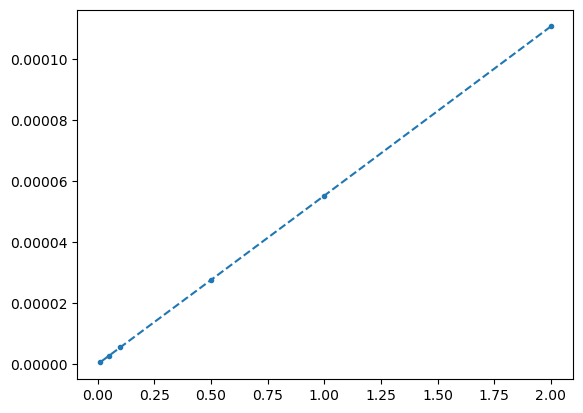

In [213]:
norm_velo_norm = []
corr_velo_norm = []
scale_extra_arr = [2,1,0.5,0.1,0.05,0.01]
for scale_extra in scale_extra_arr:
    scale=1/500*scale_extra
    dN = get_int_field(delta_N_fur*scale)
    P_new = P+l_rho*dN; Z_new = Z+l_z*dN


    P_rfft_new = np.fft.rfft(get_ext_array(P_new,'p'), norm='forward')
    P_rfft_new[abs(P_rfft_new)<1e-11]=0
    Z_rfft_new = np.fft.rfft(get_ext_array(Z_new,'z'), norm='forward')
    Z_rfft_new[abs(Z_rfft_new)<1e-11]=0
    P_, P1_,P2,P3,P4 = get_int_fields(P_rfft_new)
    Z_, Z1_,Z2,Z3,Z4 = get_int_fields(Z_rfft_new)   
    V_new = np.sqrt(P1_**2+Z1_**2)

    Pfur_init, Zfur_init = make_constant_v_repar_from_PZV(P_new, Z_new, V_new, N_proj=N)
    
    corr_velo_norm.append(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[0])[::2].sum())
    norm_velo_norm.append(abs(get_normal_velo_projects_full(Pfur_init, Zfur_init)[0])[::2].sum())
    
plt.figure()
plt.plot(scale_extra_arr, corr_velo_norm, '.--')

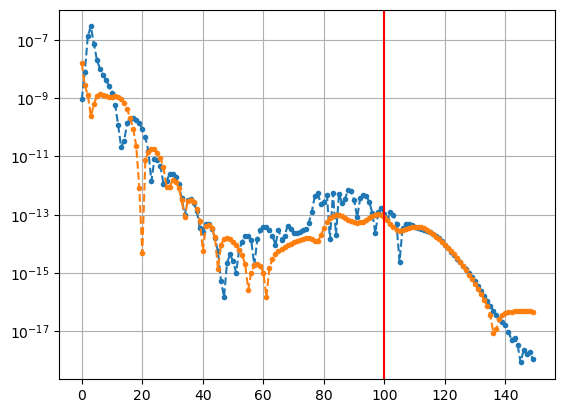

In [219]:
plt.figure()
plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[0])[::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')


plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[1])[1::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')
plt.axvline(N//2, color='red')
plt.yscale('log')
plt.grid()

### Integrate

In [307]:
%timeit get_corr_velo_sym_fur_1d(get_pz_sym_from_PZ_fur(Pfur_0, Zfur_0))

1.25 s ± 59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [222]:
%load_ext line_profiler

In [227]:
%lprun -f get_sigma_fur get_corr_velo_sym_fur_1d(get_pz_sym_from_PZ_fur(Pfur_0, Zfur_0))

In [528]:
step_arr = np.logspace(-8,-5.5,N)[::-1]
j_fun = nd.Jacobian(lambda x: get_corr_velo_sym_fur_1d(x), step=step_arr)

In [229]:
jac_0 = j_fun(get_pz_sym_from_PZ_fur(Pfur_init, Zfur_init))
eigs_0 = sc.linalg.eigvals(jac_0)
print(f'{eigs_0.real.min():.2e}',eigs_0.real.max())

-5.45e+02 0.016352326982626363


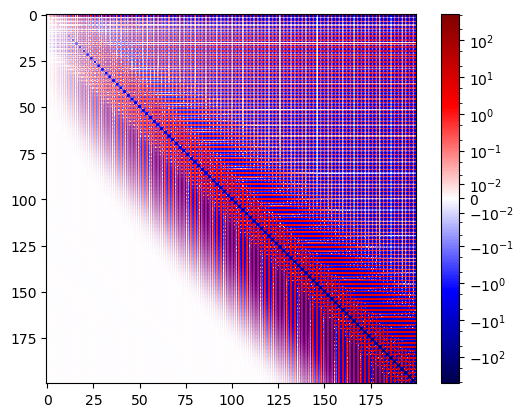

In [230]:
import matplotlib.colors as colors
lnrwidth=1e-2
gain=np.max(abs(jac_0))

plt.figure()
#plt.title(r'$\frac{\delta ||v_l||_i}{\delta N_j}$')
plt.imshow(jac_0, norm=colors.AsinhNorm(linear_width=lnrwidth,
                                             vmin=-gain, vmax=gain), cmap='seismic')
plt.colorbar()

In [311]:
t_max=3e2

In [566]:
rtol=1e-5
atol_arr = np.logspace(-13,-6, N)[::-1]

In [396]:
ev = 0
def fun_a(t,pz):
    global ev
    if ev % 4 == 0:
        print(t)
        print(pz)
    ev+=1
    return get_corr_velo_sym_fur_1d(pz)
jac = j_fun

In [314]:
sol_rad = sc.integrate.solve_ivp(fun_a, (0., t_max), get_pz_sym_from_PZ_fur(Pfur_init, Zfur_init), 
                                   method='Radau', jac=lambda t,pz:jac(pz),atol=atol_arr,rtol=rtol);

0.0
[ 6.37921982e-01  9.73493596e+00  2.16068945e-01  1.06713454e+00
  1.33584729e-01  3.74209377e-01  9.93182441e-02  1.83852142e-01
  8.05675598e-02  1.06020630e-01  6.81150422e-02  6.70394466e-02
  5.78712112e-02  4.49405569e-02  4.76200063e-02  3.13108926e-02
  3.65637114e-02  2.23696013e-02  2.55097742e-02  1.62194429e-02
  1.61249990e-02  1.18299035e-02  9.43850439e-03  8.60782330e-03
  5.30840399e-03  6.19688808e-03  3.00098410e-03  4.37598459e-03
  1.79052858e-03  3.00362834e-03  1.16945835e-03  1.98511170e-03
  8.36036605e-04  1.25168055e-03  6.29884823e-04  7.47232847e-04
  4.76275497e-04  4.21044395e-04  3.47673193e-04  2.25747993e-04
  2.38765762e-04  1.18974353e-04  1.51393425e-04  6.61504898e-05
  8.69513310e-05  4.22073125e-05  4.39668564e-05  3.12902156e-05
  1.85211742e-05  2.49047949e-05  5.64630504e-06  1.94805350e-05
  6.06662161e-07  1.41659631e-05 -3.40459684e-07  9.24231980e-06
  2.95132503e-07  5.19468600e-06  1.11850773e-06  2.30061851e-06
  1.55668270e-06  5.4

0.6030058497753945
[ 6.37921981e-01  9.73493597e+00  2.16068940e-01  1.06713454e+00
  1.33584646e-01  3.74209378e-01  9.93184184e-02  1.83852143e-01
  8.05675167e-02  1.06020630e-01  6.81150297e-02  6.70394459e-02
  5.78712051e-02  4.49405561e-02  4.76200025e-02  3.13108919e-02
  3.65637089e-02  2.23696006e-02  2.55097726e-02  1.62194423e-02
  1.61249981e-02  1.18299029e-02  9.43850403e-03  8.60782261e-03
  5.30840392e-03  6.19688740e-03  3.00098411e-03  4.37598401e-03
  1.79052856e-03  3.00362793e-03  1.16945826e-03  1.98511145e-03
  8.36036485e-04  1.25168042e-03  6.29884697e-04  7.47232795e-04
  4.76275386e-04  4.21044382e-04  3.47673111e-04  2.25747993e-04
  2.38765709e-04  1.18974353e-04  1.51393397e-04  6.61504854e-05
  8.69513218e-05  4.22073037e-05  4.39668575e-05  3.12902046e-05
  1.85211792e-05  2.49047844e-05  5.64630998e-06  1.94805268e-05
  6.06665142e-07  1.41659579e-05 -3.40458917e-07  9.24231732e-06
  2.95131658e-07  5.19468548e-06  1.11850612e-06  2.30061908e-06
  1.55

63.829708860432774
[ 6.37921878e-01  9.73493772e+00  2.16068079e-01  1.06713486e+00
  1.33569450e-01  3.74209518e-01  9.93504967e-02  1.83852170e-01
  8.05595830e-02  1.06020562e-01  6.81127393e-02  6.70393161e-02
  5.78700719e-02  4.49404076e-02  4.76193010e-02  3.13107514e-02
  3.65632439e-02  2.23694742e-02  2.55094781e-02  1.62193225e-02
  1.61248362e-02  1.18297805e-02  9.43843698e-03  8.60769462e-03
  5.30839031e-03  6.19676239e-03  3.00098656e-03  4.37587829e-03
  1.79052488e-03  3.00355258e-03  1.16944338e-03  1.98506602e-03
  8.36014520e-04  1.25165734e-03  6.29861463e-04  7.47223397e-04
  4.76255118e-04  4.21041867e-04  3.47657923e-04  2.25747947e-04
  2.38755985e-04  1.18974392e-04  1.51388367e-04  6.61496995e-05
  8.69496316e-05  4.22056972e-05  4.39670711e-05  3.12882037e-05
  1.85221235e-05  2.49028706e-05  5.64723285e-06  1.94790320e-05
  6.07222931e-07  1.41650063e-05 -3.40313374e-07  9.24186379e-06
  2.94976796e-07  5.19459178e-06  1.11820850e-06  2.30072556e-06
  1.55

184.3889385224964
[ 6.37920955e-01  9.73495286e+00  2.16061050e-01  1.06713753e+00
  1.33445066e-01  3.74210699e-01  9.96130672e-02  1.83852410e-01
  8.04946450e-02  1.06020016e-01  6.80939711e-02  6.70382586e-02
  5.78608367e-02  4.49392024e-02  4.76135618e-02  3.13096012e-02
  3.65594456e-02  2.23684431e-02  2.55070719e-02  1.62183447e-02
  1.61235146e-02  1.18287815e-02  9.43788972e-03  8.60664881e-03
  5.30827961e-03  6.19574055e-03  3.00100682e-03  4.37501404e-03
  1.79049487e-03  3.00293663e-03  1.16932163e-03  1.98469472e-03
  8.35834895e-04  1.25146866e-03  6.29671476e-04  7.47146595e-04
  4.76089387e-04  4.21021328e-04  3.47533742e-04  2.25747577e-04
  2.38676486e-04  1.18974705e-04  1.51347237e-04  6.61432640e-05
  8.69358125e-05  4.21925526e-05  4.39688161e-05  3.12718358e-05
  1.85298422e-05  2.48872177e-05  5.65477545e-06  1.94668069e-05
  6.11780662e-07  1.41572238e-05 -3.39125680e-07  9.23815474e-06
  2.93709045e-07  5.19382510e-06  1.11577416e-06  2.30159573e-06
  1.553

119.0423659281517
[ 6.37921627e-01  9.73494189e+00  2.16066113e-01  1.06713560e+00
  1.33534688e-01  3.74209845e-01  9.94238796e-02  1.83852236e-01
  8.05414340e-02  1.06020408e-01  6.81074957e-02  6.70390201e-02
  5.78674875e-02  4.49400699e-02  4.76176968e-02  3.13104300e-02
  3.65621817e-02  2.23691858e-02  2.55088052e-02  1.62190490e-02
  1.61244666e-02  1.18295012e-02  9.43828391e-03  8.60740219e-03
  5.30835932e-03  6.19647669e-03  3.00099220e-03  4.37563666e-03
  1.79051648e-03  3.00338037e-03  1.16940934e-03  1.98496221e-03
  8.35964303e-04  1.25160458e-03  6.29808349e-04  7.47201922e-04
  4.76208784e-04  4.21036123e-04  3.47623205e-04  2.25747843e-04
  2.38733759e-04  1.18974479e-04  1.51376868e-04  6.61479008e-05
  8.69457680e-05  4.22020229e-05  4.39675589e-05  3.12836281e-05
  1.85242815e-05  2.48984948e-05  5.64934170e-06  1.94756144e-05
  6.08497305e-07  1.41628306e-05 -3.39981193e-07  9.24082689e-06
  2.94622466e-07  5.19437746e-06  1.11752798e-06  2.30096886e-06
  1.555

235.46691853832255
[ 6.37918179e-01  9.73499180e+00  2.16047450e-01  1.06714408e+00
  1.33200536e-01  3.74213435e-01  1.00129191e-01  1.83853086e-01
  8.03670215e-02  1.06019065e-01  6.80568187e-02  6.70362415e-02
  5.78431814e-02  4.49369564e-02  4.76023082e-02  3.13073359e-02
  3.65520735e-02  2.23664599e-02  2.55024057e-02  1.62164562e-02
  1.61209547e-02  1.18268443e-02  9.43683288e-03  8.60461488e-03
  5.30806999e-03  6.19374948e-03  3.00104951e-03  4.37332875e-03
  1.79043719e-03  3.00173557e-03  1.16908377e-03  1.98397109e-03
  8.35483808e-04  1.25110122e-03  6.29300303e-04  7.46997173e-04
  4.75765743e-04  4.20981443e-04  3.47291314e-04  2.25746870e-04
  2.38521314e-04  1.18975228e-04  1.51266966e-04  6.61305720e-05
  8.69088380e-05  4.21667666e-05  4.39722043e-05  3.12397834e-05
  1.85448764e-05  2.48565934e-05  5.66945969e-06  1.94429019e-05
  6.20640447e-07  1.41420104e-05 -3.36836697e-07  9.23090329e-06
  2.91214263e-07  5.19232175e-06  1.11101038e-06  2.30328889e-06
  1.54

269.10185220470544
[ 6.37913484e-01  9.73505133e+00  2.16031753e-01  1.06715368e+00
  1.32912605e-01  3.74217274e-01  1.00736815e-01  1.83854185e-01
  8.02167969e-02  1.06018130e-01  6.80126464e-02  6.70339591e-02
  5.78231869e-02  4.49344960e-02  4.75890837e-02  3.13046629e-02
  3.65435393e-02  2.23641901e-02  2.54970095e-02  1.62142834e-02
  1.61180013e-02  1.18246035e-02  9.43561784e-03  8.60225319e-03
  5.30783544e-03  6.19143188e-03  3.00110393e-03  4.37136524e-03
  1.79037100e-03  3.00033637e-03  1.16880568e-03  1.98312864e-03
  8.35073301e-04  1.25067386e-03  6.28866653e-04  7.46823615e-04
  4.75387885e-04  4.20935211e-04  3.47008411e-04  2.25746032e-04
  2.38340292e-04  1.18975650e-04  1.51173336e-04  6.61155147e-05
  8.68773621e-05  4.21364455e-05  4.39761187e-05  3.12022026e-05
  1.85623526e-05  2.48207396e-05  5.68651744e-06  1.94149390e-05
  6.30907976e-07  1.41242225e-05 -3.34220512e-07  9.22242343e-06
  2.88266801e-07  5.19055596e-06  1.10543093e-06  2.30525463e-06
  1.54

In [316]:
sol_t = sol_rad.t.copy()
sol_y = sol_rad.y.copy()

#### Continue

In [368]:
t_start = sol_t[-1]
pz_start = sol_y[:,-1]

In [530]:
t_start

705.0

In [348]:
t_end = 6e2

In [397]:
def get_jac(t, pz):
    print('Computing jac!.......')
    return jac(pz)

In [350]:
sol_rad = sc.integrate.solve_ivp(fun_a, (t_start, t_end), pz_start, 
                                   method='Radau', jac=get_jac,atol=atol_arr,rtol=rtol);

Computing jac!.......
500.064027784721
[ 6.30143896e-01  9.81269682e+00  2.15342416e-01  1.07766594e+00
  1.04499244e-01  3.78131979e-01  1.60740920e-01  1.85356437e-01
  6.79809276e-02  1.06926427e-01  6.05465413e-02  6.72435251e-02
  5.98216980e-02  4.56136068e-02  4.61767891e-02  3.10238865e-02
  3.64321282e-02  2.23775124e-02  2.51386152e-02  1.63351414e-02
  1.62515485e-02  1.17387085e-02  9.40404783e-03  8.52230893e-03
  5.33434335e-03  6.07386381e-03  3.02129609e-03  4.26470842e-03
  1.80128151e-03  2.91766288e-03  1.15333656e-03  1.93553588e-03
  8.05656674e-04  1.22884348e-03  5.99458128e-04  7.38545847e-04
  4.49988498e-04  4.19391897e-04  3.28421034e-04  2.25859487e-04
  2.26218440e-04  1.18622685e-04  1.44932590e-04  6.43514295e-05
  8.46366872e-05  3.93586237e-05  4.40351353e-05  2.80606837e-05
  1.94695480e-05  2.19728409e-05  6.56840200e-06  1.72494819e-05
  1.08847139e-06  1.27559569e-05 -3.39704889e-07  8.55079378e-06
 -3.59039015e-08  5.00706810e-06  6.50444883e-07  2

501.0920331065251
[ 6.29897259e-01  9.81520234e+00  2.15323159e-01  1.07799171e+00
  1.04046732e-01  3.78261972e-01  1.61723252e-01  1.85401283e-01
  6.78621692e-02  1.06958773e-01  6.03579453e-02  6.72536889e-02
  5.99254808e-02  4.56396868e-02  4.61450763e-02  3.10197454e-02
  3.64416773e-02  2.23794690e-02  2.51303763e-02  1.63441179e-02
  1.62624633e-02  1.17384116e-02  9.40431751e-03  8.52322876e-03
  5.33506940e-03  6.07341069e-03  3.02170343e-03  4.26414133e-03
  1.80189265e-03  2.91687642e-03  1.15340366e-03  1.93507451e-03
  8.05242959e-04  1.22872541e-03  5.99153546e-04  7.38484124e-04
  4.49696903e-04  4.19398569e-04  3.28228649e-04  2.25857192e-04
  2.26063861e-04  1.18620881e-04  1.44855238e-04  6.43223590e-05
  8.46017009e-05  3.93181643e-05  4.40291755e-05  2.80160877e-05
  1.94736009e-05  2.19333150e-05  6.57417480e-06  1.72190878e-05
  1.09080946e-06  1.27360277e-05 -3.41884148e-07  8.54024332e-06
 -4.10416954e-08  5.00301838e-06  6.44187241e-07  2.39045459e-06
  1.105

510.19522211625747
[ 6.27574413e-01  9.83897983e+00  2.15091226e-01  1.08105304e+00
  1.00129717e-01  3.79505546e-01  1.70335869e-01  1.85817702e-01
  6.69850742e-02  1.07267345e-01  5.86025255e-02  6.73521598e-02
  6.09463205e-02  4.58884118e-02  4.58417214e-02  3.09858564e-02
  3.65357385e-02  2.23948881e-02  2.50477352e-02  1.64348084e-02
  1.63718010e-02  1.17355529e-02  9.40778687e-03  8.53359133e-03
  5.33978294e-03  6.07105202e-03  3.02530763e-03  4.26028591e-03
  1.80789031e-03  2.91020316e-03  1.15499181e-03  1.93082094e-03
  8.01311741e-04  1.22789446e-03  5.96702920e-04  7.37869091e-04
  4.47161564e-04  4.19462508e-04  3.26667289e-04  2.25789604e-04
  2.24658343e-04  1.18633990e-04  1.44163695e-04  6.40758647e-05
  8.42707106e-05  3.89739731e-05  4.39612975e-05  2.76326441e-05
  1.94952880e-05  2.15909137e-05  6.61763316e-06  1.69530147e-05
  1.11149283e-06  1.25573328e-05 -3.59907856e-07  8.44413447e-06
 -8.37455315e-08  4.96374811e-06  5.90839364e-07  2.38559345e-06
  1.05

515.243330207417
[ 6.26066762e-01  9.85458919e+00  2.14889406e-01  1.08303581e+00
  9.78638880e-02  3.80330518e-01  1.75427606e-01  1.86082680e-01
  6.66106072e-02  1.07470799e-01  5.74815445e-02  6.74185508e-02
  6.16460463e-02  4.60522670e-02  4.56384503e-02  3.09682294e-02
  3.65978406e-02  2.24018497e-02  2.49893941e-02  1.64988872e-02
  1.64479865e-02  1.17333460e-02  9.41106162e-03  8.54144884e-03
  5.34049651e-03  6.07102062e-03  3.02754173e-03  4.25882617e-03
  1.81191999e-03  2.90635941e-03  1.15696021e-03  1.92796694e-03
  7.98608828e-04  1.22756444e-03  5.95445031e-04  7.37399997e-04
  4.45645972e-04  4.19495515e-04  3.25853025e-04  2.25695499e-04
  2.23759633e-04  1.18670659e-04  1.43732026e-04  6.39393684e-05
  8.40495722e-05  3.87788992e-05  4.39057527e-05  2.74123622e-05
  1.94962101e-05  2.13907537e-05  6.63708768e-06  1.67952340e-05
  1.12547448e-06  1.24465565e-05 -3.69075031e-07  8.38343402e-06
 -1.06500165e-07  4.93673425e-06  5.60523907e-07  2.38039101e-06
  1.0283

Computing jac!.......
520.5758609049943
[ 6.24292024e-01  9.87315289e+00  2.14595795e-01  1.08536926e+00
  9.54208336e-02  3.81318848e-01  1.81035699e-01  1.86389628e-01
  6.63261809e-02  1.07712716e-01  5.61833126e-02  6.74993007e-02
  6.25031060e-02  4.62470257e-02  4.53904923e-02  3.09513621e-02
  3.66676649e-02  2.24069003e-02  2.49166075e-02  1.65788402e-02
  1.65417548e-02  1.17300655e-02  9.41639773e-03  8.55126843e-03
  5.33822854e-03  6.07223423e-03  3.03030652e-03  4.25773467e-03
  1.81664025e-03  2.90210915e-03  1.16036007e-03  1.92427943e-03
  7.95075480e-04  1.22733573e-03  5.94239272e-04  7.36728502e-04
  4.43913855e-04  4.19511456e-04  3.25061985e-04  2.25522109e-04
  2.22673665e-04  1.18741010e-04  1.43215604e-04  6.38015324e-05
  8.37807780e-05  3.85682948e-05  4.38264603e-05  2.71759216e-05
  1.94872875e-05  2.11700136e-05  6.65084368e-06  1.66206277e-05
  1.14538194e-06  1.23171421e-05 -3.77501034e-07  8.31214028e-06
 -1.28590692e-07  4.90274394e-06  5.27904378e-07  

519.299113198067
[ 6.24734594e-01  9.86850560e+00  2.14674393e-01  1.08478739e+00
  9.60096458e-02  3.81070755e-01  1.79671948e-01  1.86313550e-01
  6.63828137e-02  1.07652166e-01  5.65050984e-02  6.74789220e-02
  6.22862847e-02  4.61982893e-02  4.54531817e-02  3.09552078e-02
  3.66505963e-02  2.24059440e-02  2.49351563e-02  1.65584829e-02
  1.65180001e-02  1.17309532e-02  9.41493475e-03  8.54877352e-03
  5.33908121e-03  6.07181899e-03  3.02960658e-03  4.25795352e-03
  1.81546450e-03  2.90314686e-03  1.15941384e-03  1.92523254e-03
  7.95988335e-04  1.22737893e-03  5.94515539e-04  7.36907844e-04
  4.44341902e-04  4.19509814e-04  3.25244645e-04  2.25571234e-04
  2.22947483e-04  1.18720900e-04  1.43345282e-04  6.38338199e-05
  8.38488797e-05  3.86190657e-05  4.38475132e-05  2.72328248e-05
  1.94904552e-05  2.12237467e-05  6.64816304e-06  1.66632074e-05
  1.14010220e-06  1.23493651e-05 -3.75647145e-07  8.32992950e-06
 -1.23514208e-07  4.91143717e-06  5.35753595e-07  2.37461574e-06
  1.0056

539.8018572560737
[ 6.16199830e-01  9.96039474e+00  2.12507255e-01  1.09607034e+00
  8.64984706e-02  3.86025123e-01  2.03002965e-01  1.87728711e-01
  6.65017072e-02  1.08834558e-01  5.06544903e-02  6.79056865e-02
  6.67971638e-02  4.71528403e-02  4.41212017e-02  3.09170339e-02
  3.68750212e-02  2.23941463e-02  2.45487566e-02  1.69906611e-02
  1.70071664e-02  1.17019963e-02  9.46616773e-03  8.59627385e-03
  5.27632403e-03  6.09233253e-03  3.04857060e-03  4.25558158e-03
  1.83598819e-03  2.88377559e-03  1.19147591e-03  1.90029658e-03
  7.71936822e-04  1.22786986e-03  5.91465797e-04  7.31542632e-04
  4.36060858e-04  4.18936379e-04  3.23060384e-04  2.23825661e-04
  2.16942158e-04  1.19346837e-04  1.40312399e-04  6.35166621e-05
  8.25379220e-05  3.76655026e-05  4.31996370e-05  2.63508329e-05
  1.93711488e-05  2.02598842e-05  6.55536694e-06  1.59377880e-05
  1.33203987e-06  1.16782400e-05 -3.90744291e-07  7.97062151e-06
 -1.74104226e-07  4.71342940e-06  4.02047037e-07  2.31543401e-06
  8.914

544.9719194873609
[ 6.13538994e-01  9.99003385e+00  2.11565620e-01  1.09963706e+00
  8.41515328e-02  3.87631423e-01  2.09313035e-01  1.88147852e-01
  6.69101188e-02  1.09205851e-01  4.90301378e-02  6.80548431e-02
  6.83363455e-02  4.74554167e-02  4.36477128e-02  3.09181546e-02
  3.68811357e-02  2.23810260e-02  2.44226166e-02  1.71389569e-02
  1.71696404e-02  1.16866803e-02  9.49330688e-03  8.60930723e-03
  5.23376405e-03  6.10413017e-03  3.05812306e-03  4.25445441e-03
  1.84116192e-03  2.87745236e-03  1.20760246e-03  1.88915979e-03
  7.61068043e-04  1.22852041e-03  5.91287561e-04  7.28940289e-04
  4.33511356e-04  4.18339019e-04  3.22738348e-04  2.22961533e-04
  2.14698652e-04  1.19612471e-04  1.38990207e-04  6.35787711e-05
  8.22189877e-05  3.73038394e-05  4.28506097e-05  2.61707813e-05
  1.93243416e-05  1.99707029e-05  6.44147328e-06  1.57502930e-05
  1.45005839e-06  1.14313452e-05 -3.87794921e-07  7.84666612e-06
 -1.74142084e-07  4.64082968e-06  3.64314670e-07  2.28839770e-06
  8.639

543.8486993491762
[ 6.14135473e-01  9.98334752e+00  2.11786725e-01  1.09883450e+00
  8.46578471e-02  3.87269282e-01  2.07929554e-01  1.88054897e-01
  6.68081892e-02  1.09122632e-01  4.93837644e-02  6.80206704e-02
  6.79857625e-02  4.73874081e-02  4.37565064e-02  3.09174484e-02
  3.68830928e-02  2.23841584e-02  2.44509015e-02  1.71052641e-02
  1.71329076e-02  1.16904492e-02  9.48674908e-03  8.60650216e-03
  5.24436286e-03  6.10124690e-03  3.05577912e-03  4.25476052e-03
  1.84005502e-03  2.87890271e-03  1.20373705e-03  1.89180844e-03
  7.63662455e-04  1.22835281e-03  5.91300652e-04  7.29567625e-04
  4.34073505e-04  4.18501691e-04  3.22806646e-04  2.23164311e-04
  2.15218584e-04  1.19550857e-04  1.39308167e-04  6.35557671e-05
  8.22816098e-05  3.73932049e-05  4.29371885e-05  2.62059847e-05
  1.93348723e-05  2.00346041e-05  6.47161673e-06  1.57909702e-05
  1.42021678e-06  1.14889649e-05 -3.88843602e-07  7.87571787e-06
 -1.74437785e-07  4.65636621e-06  3.72656256e-07  2.29546475e-06
  8.698

564.5542511900484
[ 6.01408192e-01  1.01311794e+01  2.05969220e-01  1.11641210e+00
  7.57650565e-02  3.95194337e-01  2.34368372e-01  1.89907598e-01
  6.98140419e-02  1.10885597e-01  4.33221439e-02  6.88442029e-02
  7.61642190e-02  4.88573661e-02  4.10889825e-02  3.09801475e-02
  3.63737167e-02  2.23146902e-02  2.38701932e-02  1.78677605e-02
  1.79442755e-02  1.15627285e-02  9.68041329e-03  8.64922252e-03
  4.88032527e-03  6.19332286e-03  3.14093576e-03  4.23791750e-03
  1.85752950e-03  2.84215683e-03  1.31234032e-03  1.81639923e-03
  6.86960147e-04  1.23427934e-03  5.94742741e-04  7.10260399e-04
  4.25839137e-04  4.10662866e-04  3.19260149e-04  2.18184230e-04
  2.01913281e-04  1.20982603e-04  1.29221709e-04  6.51566256e-05
  8.31772574e-05  3.42375090e-05  3.96157665e-05  2.61327881e-05
  1.90175728e-05  1.86639825e-05  5.18692296e-06  1.51204246e-05
  2.60793806e-06  9.92072438e-06 -2.92814052e-07  7.16068465e-06
 -2.41862925e-07  4.32505307e-06  2.34880053e-07  2.08089057e-06
  7.589

557.261963580575
[ 6.06321154e-01  1.00728256e+01  2.08464769e-01  1.10950279e+00
  7.87888172e-02  3.92093486e-01  2.24856424e-01  1.89227477e-01
  6.84976331e-02  1.10209257e-01  4.52676189e-02  6.85025415e-02
  7.28267058e-02  4.82854089e-02  4.22073206e-02  3.09449601e-02
  3.66919987e-02  2.23385965e-02  2.40868893e-02  1.75636701e-02
  1.76260599e-02  1.16251628e-02  9.59372978e-03  8.63720031e-03
  5.05536599e-03  6.15001010e-03  3.09788919e-03  4.24745503e-03
  1.85223890e-03  2.85802763e-03  1.26483038e-03  1.85006901e-03
  7.22013938e-04  1.23137198e-03  5.92324992e-04  7.19319110e-04
  4.27699532e-04  4.14989918e-04  3.21541857e-04  2.20129874e-04
  2.07628905e-04  1.20399440e-04  1.33994966e-04  6.42490732e-05
  8.21143872e-05  3.58591207e-05  4.13296658e-05  2.59627206e-05
  1.91838352e-05  1.91784170e-05  5.84590222e-06  1.53393646e-05
  1.99254436e-06  1.06193721e-05 -3.53451668e-07  7.46774507e-06
 -1.77876206e-07  4.43414644e-06  2.71337580e-07  2.18989567e-06
  7.9981

Computing jac!.......
561.9651169944473
[ 6.03208724e-01  1.01096061e+01  2.06915453e-01  1.11386004e+00
  7.68257583e-02  3.94053257e-01  2.30971072e-01  1.89663943e-01
  6.93175327e-02  1.10638490e-01  4.39738319e-02  6.87155426e-02
  7.49132714e-02  4.86471291e-02  4.15120114e-02  3.09657862e-02
  3.65087007e-02  2.23223355e-02  2.39482738e-02  1.77550597e-02
  1.78274620e-02  1.15877871e-02  9.64730163e-03  8.64549294e-03
  4.94941005e-03  6.17631033e-03  3.12331238e-03  4.24195073e-03
  1.85580561e-03  2.84825865e-03  1.29436563e-03  1.82935576e-03
  7.00613112e-04  1.23311326e-03  5.93644281e-04  7.13848704e-04
  4.26244614e-04  4.12482155e-04  3.20322473e-04  2.18869360e-04
  2.04099236e-04  1.20760026e-04  1.31105327e-04  6.47819322e-05
  8.26491214e-05  3.49113053e-05  4.03209846e-05  2.60339046e-05
  1.90906252e-05  1.88457606e-05  5.45108942e-06  1.51978797e-05
  2.35561124e-06  1.01929972e-05 -3.19517763e-07  7.27868490e-06
 -2.08006389e-07  4.35692860e-06  2.43862972e-07  

565.6121528966
[ 6.00654246e-01  1.01402772e+01  2.05562933e-01  1.11748777e+00
  7.53354138e-02  3.95673544e-01  2.35762082e-01  1.90007648e-01
  7.00256044e-02  1.10988809e-01  4.30706887e-02  6.88992478e-02
  7.66977942e-02  4.89455856e-02  4.09073339e-02  3.09866772e-02
  3.63109128e-02  2.23119860e-02  2.38379749e-02  1.79153475e-02
  1.79931691e-02  1.15514651e-02  9.69466681e-03  8.65056769e-03
  4.84973162e-03  6.20084335e-03  3.14905184e-03  4.23599526e-03
  1.85817018e-03  2.83950926e-03  1.31998664e-03  1.81078957e-03
  6.80947722e-04  1.23479286e-03  5.95310882e-04  7.08661048e-04
  4.25800583e-04  4.09821330e-04  3.18698103e-04  2.17919190e-04
  2.00963669e-04  1.21067669e-04  1.28388724e-04  6.53243128e-05
  8.34620607e-05  3.39370607e-05  3.92847716e-05  2.61841632e-05
  1.89793695e-05  1.85859420e-05  5.07222667e-06  1.50887093e-05
  2.72322291e-06  9.80529016e-06 -2.80470722e-07  7.11039518e-06
 -2.61698206e-07  4.30792456e-06  2.34332185e-07  2.06307055e-06
  7.524188

577.0907691719192
[ 5.91757282e-01  1.02504821e+01  2.00380962e-01  1.13050595e+00
  7.07801487e-02  4.01376240e-01  2.51036040e-01  1.91094264e-01
  7.26069434e-02  1.12194663e-01  4.10699942e-02  6.95983743e-02
  8.34512063e-02  4.99947954e-02  3.85717077e-02  3.10857060e-02
  3.52994799e-02  2.23112182e-02  2.34787501e-02  1.84948801e-02
  1.85524095e-02  1.13806793e-02  9.87079533e-03  8.65652303e-03
  4.42174764e-03  6.30603330e-03  3.28492453e-03  4.20224735e-03
  1.86115097e-03  2.80375754e-03  1.41036179e-03  1.73735051e-03
  5.97805461e-04  1.24266067e-03  6.07767832e-04  6.84622485e-04
  4.31764642e-04  3.95451874e-04  3.05725421e-04  2.16183880e-04
  1.88235872e-04  1.22234964e-04  1.16723236e-04  6.77889261e-05
  8.97878419e-05  2.88323337e-05  3.37120710e-05  2.75511604e-05
  1.81540354e-05  1.78445515e-05  3.57630442e-06  1.46196009e-05
  4.54514488e-06  8.19337530e-06 -7.70825468e-08  6.44566385e-06
 -8.13185570e-07  4.31353456e-06  4.01341614e-07  1.67275470e-06
  6.657

580.5025598050383
[ 5.88841880e-01  1.02877485e+01  1.98550866e-01  1.13490463e+00
  6.94446077e-02  4.03259455e-01  2.55605367e-01  1.91411021e-01
  7.34575994e-02  1.12585550e-01  4.08003156e-02  6.98459149e-02
  8.58573277e-02  5.03411487e-02  3.77378586e-02  3.11277757e-02
  3.48698095e-02  2.23278639e-02  2.33691807e-02  1.86924437e-02
  1.87175648e-02  1.13085997e-02  9.92610802e-03  8.65495188e-03
  4.25931203e-03  6.34646455e-03  3.35142036e-03  4.18533518e-03
  1.85935529e-03  2.79044367e-03  1.43619235e-03  1.71146002e-03
  5.65838347e-04  1.24608257e-03  6.15430747e-04  6.74223057e-04
  4.37089323e-04  3.88731508e-04  2.97613410e-04  2.16590257e-04
  1.83542547e-04  1.22610148e-04  1.12374926e-04  6.86862992e-05
  9.33087932e-05  2.64940552e-05  3.09426461e-05  2.83924665e-05
  1.76836707e-05  1.76665723e-05  3.20598222e-06  1.43440337e-05
  5.30566787e-06  7.60023765e-06 -2.19212003e-08  6.22112108e-06
 -1.19025952e-06  4.40454708e-06  6.02595664e-07  1.44930805e-06
  6.256

Computing jac!.......
583.0895832234958
[ 5.86542143e-01  1.03175438e+01  1.97068327e-01  1.13842026e+00
  6.84315107e-02  4.04748793e-01  2.59070671e-01  1.91647191e-01
  7.41217091e-02  1.12892645e-01  4.07177535e-02  7.00470421e-02
  8.78235218e-02  5.06150075e-02  3.70598800e-02  3.11644945e-02
  3.45011468e-02  2.23480210e-02  2.32856145e-02  1.88510999e-02
  1.88380965e-02  1.12460987e-02  9.96711826e-03  8.65269796e-03
  4.12504589e-03  6.38015466e-03  3.41306138e-03  4.16955569e-03
  1.85676008e-03  2.77946369e-03  1.45426166e-03  1.69074115e-03
  5.39123593e-04  1.24911339e-03  6.22980126e-04  6.65042389e-04
  4.42575681e-04  3.82692577e-04  2.89575583e-04  2.17356963e-04
  1.79746450e-04  1.22870786e-04  1.08830559e-04  6.93944239e-05
  9.65981617e-05  2.44190119e-05  2.83596853e-05  2.92222821e-05
  1.72515290e-05  1.75428133e-05  3.01533509e-06  1.40549719e-05
  5.94168499e-06  7.12334981e-06  3.29138065e-09  6.04909315e-06
 -1.56780298e-06  4.51190936e-06  8.35773827e-07  

591.1204999052919
[ 5.78872833e-01  1.04194894e+01  1.91907895e-01  1.15043319e+00
  6.52455042e-02  4.09736152e-01  2.69783018e-01  1.92348203e-01
  7.62478260e-02  1.13911267e-01  4.12386465e-02  7.07514129e-02
  9.48238996e-02  5.15304059e-02  3.47016221e-02  3.13120461e-02
  3.31219443e-02  2.24680175e-02  2.30266127e-02  1.94006528e-02
  1.91465670e-02  1.10022548e-02  1.00716027e-02  8.64076392e-03
  3.65107290e-03  6.50168266e-03  3.69143199e-03  4.09772472e-03
  1.83861391e-03  2.74054493e-03  1.49173897e-03  1.62241705e-03
  4.41836906e-04  1.26169075e-03  6.59827765e-04  6.27424989e-04
  4.69683283e-04  3.57719305e-04  2.49787938e-04  2.23590953e-04
  1.67559942e-04  1.23101530e-04  9.69436460e-05  7.14828997e-05
  1.10705431e-04  1.61474472e-05  1.65367895e-05  3.33163099e-05
  1.55675964e-05  1.71360038e-05  3.61873098e-06  1.23632987e-05
  8.04693260e-06  5.62641833e-06 -1.69519510e-07  5.57659607e-06
 -3.42145251e-06  5.11548554e-06  2.31153213e-06  1.05344073e-07
  3.313

Computing jac!.......
595.8617977705758
[ 5.73931144e-01  1.04873325e+01  1.88428243e-01  1.15840472e+00
  6.33051294e-02  4.12965280e-01  2.76028707e-01  1.92731398e-01
  7.75058410e-02  1.14565680e-01  4.21841949e-02  7.12294135e-02
  9.96967148e-02  5.21198722e-02  3.31360928e-02  3.14299644e-02
  3.21560195e-02  2.25950602e-02  2.28800699e-02  1.97742103e-02
  1.92375184e-02  1.08182837e-02  1.00957852e-02  8.63225475e-03
  3.33605863e-03  6.58509589e-03  3.94333308e-03  4.03191980e-03
  1.81802867e-03  2.71421668e-03  1.49108225e-03  1.58141700e-03
  3.74599959e-04  1.27209709e-03  6.93905137e-04  5.97080022e-04
  4.93770562e-04  3.37936321e-04  2.11508501e-04  2.31294296e-04
  1.62039084e-04  1.22045223e-04  8.99544074e-05  7.23279973e-05
  1.21631305e-04  1.00353654e-05  5.61295455e-06  3.73043403e-05
  1.46594132e-05  1.66955434e-05  5.71786166e-06  1.03968482e-05
  8.95777304e-06  4.95592329e-06 -6.39011432e-07  5.41414196e-06
 -5.09791260e-06  5.68101854e-06  4.06964712e-06 -

593.4911488379339
[ 5.76442979e-01  1.04526338e+01  1.90210848e-01  1.15433050e+00
  6.42827670e-02  4.11322435e-01  2.72916587e-01  1.92543170e-01
  7.68798643e-02  1.14233064e-01  4.16466327e-02  7.09842863e-02
  9.71846582e-02  5.18204246e-02  3.39341244e-02  3.13676452e-02
  3.26513998e-02  2.25252148e-02  2.29521601e-02  1.95822387e-02
  1.92039148e-02  1.09142418e-02  1.00888815e-02  8.63644417e-03
  3.49640797e-03  6.54235620e-03  3.80739059e-03  4.06754165e-03
  1.82940255e-03  2.72768818e-03  1.49416421e-03  1.60181709e-03
  4.09044214e-04  1.26656844e-03  6.75572449e-04  6.13111481e-04
  4.80965720e-04  3.48319126e-04  2.32317925e-04  2.26977944e-04
  1.64458872e-04  1.22757224e-04  9.33932775e-05  7.19662712e-05
  1.15965502e-04  1.31899400e-05  1.15315215e-05  3.51282062e-05
  1.50719487e-05  1.69516592e-05  4.43726934e-06  1.15000445e-05
  8.57291655e-06  5.25060019e-06 -3.57326986e-07  5.48056309e-06
 -4.20261181e-06  5.38007258e-06  3.08262248e-06 -4.05456612e-07
  1.767

595.1996414621959
[ 5.74641198e-01  1.04774788e+01  1.88934976e-01  1.15724837e+00
  6.35798519e-02  4.12500562e-01  2.75161881e-01  1.92679541e-01
  7.73318741e-02  1.14471646e-01  4.20205593e-02  7.11596829e-02
  9.89792657e-02  5.20352695e-02  3.33619979e-02  3.14118403e-02
  3.22967527e-02  2.25741878e-02  2.28999219e-02  1.97194922e-02
  1.92308011e-02  1.08459069e-02  1.00950397e-02  8.63339593e-03
  3.38138082e-03  6.57295436e-03  3.90319750e-03  4.04246148e-03
  1.82143687e-03  2.71804081e-03  1.49255077e-03  1.58708086e-03
  3.84379718e-04  1.27048266e-03  6.88511591e-04  6.01739369e-04
  4.90039171e-04  3.40937507e-04  2.17681135e-04  2.29987739e-04
  1.62631812e-04  1.22287098e-04  9.08995987e-05  7.22412959e-05
  1.20011097e-04  1.09348854e-05  7.36528645e-06  3.66566589e-05
  1.47635142e-05  1.67757430e-05  5.30775853e-06  1.07317751e-05
  8.86756160e-06  5.02833663e-06 -5.49586381e-07  5.42934819e-06
 -4.83593574e-06  5.59344488e-06  3.77002617e-06 -8.39450306e-07
  2.374

Computing jac!.......


In [351]:
sol_t = np.concatenate((sol_t, sol_rad.t))
sol_y = np.concatenate((sol_y, sol_rad.y), axis=1)
t_max = t_end

In [660]:
t_end = t_max
for k in tqdm(range(30)):
    t_start = sol_t[-1]
    pz_start = sol_y[:,-1]
    t_end += 1
    sol_rad = sc.integrate.solve_ivp(fun_a, (t_start, t_end), pz_start, 
                                   method='Radau', jac=get_jac,atol=atol_arr,rtol=rtol);
    sol_t = np.concatenate((sol_t, sol_rad.t))
    sol_y = np.concatenate((sol_y, sol_rad.y), axis=1)
    t_max = t_end
    print('Finished!')

  0%|          | 0/30 [00:00<?, ?it/s]

663.0234380376568
[ 4.65917092e-01  1.24539770e+01  1.08033844e-01  1.38890855e+00
  3.03091559e-02  4.94520942e-01  3.11768296e-01  1.90419108e-01
  4.92961488e-02  1.34076698e-01  1.10293390e-01  8.27064023e-02
  2.24219963e-01  6.05467877e-02  9.03623687e-03  3.92442476e-02
  6.88208264e-02  3.67816698e-02  5.27918878e-02  3.26241564e-02
 -9.26686668e-03  9.55100899e-03  5.01626032e-03  1.84249820e-02
 -4.72959187e-03  9.21203292e-03  2.87283888e-03 -1.96872700e-03
 -9.51571000e-03  4.82461225e-03  4.41729812e-03 -1.09037619e-03
  8.83882361e-03 -1.67411248e-03 -1.33326667e-03 -2.30530874e-04
  4.35887283e-03  2.45326147e-04  1.03106021e-03  6.55773454e-04
  5.54252965e-04 -3.74135953e-04 -3.23042472e-03  1.72243724e-03
 -9.02510494e-04  2.59448940e-04  4.01117490e-04 -2.74935270e-04
 -1.82055297e-03  3.66957712e-04  9.45104658e-04 -3.62222152e-04
  7.10545975e-04 -2.71273127e-04  8.06274471e-04 -4.05665183e-04
 -1.08135442e-04  1.63980893e-04  1.86349481e-04 -3.38804451e-05
  1.989

662.7828457081526
[ 4.66292695e-01  1.24455454e+01  1.08246168e-01  1.38783434e+00
  3.03741336e-02  4.94131314e-01  3.11841613e-01  1.90422853e-01
  4.95391535e-02  1.33958089e-01  1.10088305e-01  8.26688072e-02
  2.23974033e-01  6.05465890e-02  9.14111966e-03  3.92055069e-02
  6.84823734e-02  3.67209881e-02  5.25775938e-02  3.25827198e-02
 -9.18128059e-03  9.53043638e-03  4.86784624e-03  1.83417944e-02
 -4.73044823e-03  9.19388884e-03  2.99414335e-03 -1.96231130e-03
 -9.43116237e-03  4.78218650e-03  4.41612034e-03 -1.06801669e-03
  8.83289980e-03 -1.65133538e-03 -1.28848511e-03 -2.32636242e-04
  4.27922628e-03  2.60542702e-04  9.88903688e-04  6.66501869e-04
  5.58745428e-04 -3.74387955e-04 -3.23356593e-03  1.70848373e-03
 -9.04044574e-04  2.59205588e-04  4.17624622e-04 -2.78669285e-04
 -1.77901800e-03  3.53765395e-04  9.35646964e-04 -3.57689242e-04
  7.07107357e-04 -2.67502370e-04  8.09192899e-04 -4.04266139e-04
 -1.21372064e-04  1.66921718e-04  1.72494859e-04 -2.87506360e-05
  1.945

663.1594100673701
[ 4.65708613e-01  1.24586864e+01  1.07917141e-01  1.38950997e+00
  3.02737047e-02  4.94739456e-01  3.11727062e-01  1.90418419e-01
  4.91610045e-02  1.34143867e-01  1.10406415e-01  8.27273681e-02
  2.24351171e-01  6.05465129e-02  8.97780265e-03  3.92659360e-02
  6.90090886e-02  3.68149519e-02  5.29094377e-02  3.26465792e-02
 -9.31247868e-03  9.56283571e-03  5.10332021e-03  1.84714983e-02
 -4.72799554e-03  9.22209326e-03  2.80462500e-03 -1.97144350e-03
 -9.56110206e-03  4.84894874e-03  4.41710595e-03 -1.10284820e-03
  8.83952743e-03 -1.68640869e-03 -1.35907692e-03 -2.29062877e-04
  4.40381988e-03  2.36324329e-04  1.05420241e-03  6.49508738e-04
  5.51814719e-04 -3.73985980e-04 -3.22656235e-03  1.72989131e-03
 -9.01041223e-04  2.59388699e-04  3.91360320e-04 -2.72568576e-04
 -1.84386916e-03  3.74564717e-04  9.50322490e-04 -3.64776703e-04
  7.11473647e-04 -2.73141585e-04  8.03904906e-04 -4.06248873e-04
 -1.00122063e-04  1.62117706e-04  1.94308954e-04 -3.68904002e-05
  2.014

663.2384501609329
[ 4.65586568e-01  1.24614366e+01  1.07848554e-01  1.38986084e+00
  3.02528068e-02  4.94866851e-01  3.11703050e-01  1.90417695e-01
  4.90819526e-02  1.34182878e-01  1.10472772e-01  8.27396189e-02
  2.24429209e-01  6.05464422e-02  8.94365057e-03  3.92785900e-02
  6.91192025e-02  3.68345280e-02  5.29785703e-02  3.26598389e-02
 -9.33961763e-03  9.56966492e-03  5.15319547e-03  1.84986484e-02
 -4.72732387e-03  9.22798430e-03  2.76490139e-03 -1.97322894e-03
 -9.58802665e-03  4.86301178e-03  4.41719010e-03 -1.11013499e-03
  8.84053859e-03 -1.69368600e-03 -1.37396219e-03 -2.28272865e-04
  4.42995650e-03  2.31183695e-04  1.06780465e-03  6.45913904e-04
  5.50374911e-04 -3.73900524e-04 -3.22479113e-03  1.73432137e-03
 -9.00324949e-04  2.59398495e-04  3.85787845e-04 -2.71251312e-04
 -1.85745325e-03  3.78951004e-04  9.53384036e-04 -3.66263128e-04
  7.12241982e-04 -2.74286600e-04  8.02691332e-04 -4.06635035e-04
 -9.55861953e-05  1.61080558e-04  1.98903377e-04 -3.86141035e-05
  2.029

Computing jac!.......
663.7137966421404
[ 4.64924856e-01  1.24763736e+01  1.07477637e-01  1.39176773e+00
  3.01400103e-02  4.95559488e-01  3.11572427e-01  1.90415015e-01
  4.86531305e-02  1.34395543e-01  1.10831909e-01  8.28061281e-02
  2.24847700e-01  6.05457370e-02  8.75836058e-03  3.93473663e-02
  6.97165409e-02  3.69403165e-02  5.33521113e-02  3.27312224e-02
 -9.48509045e-03  9.60705189e-03  5.42763104e-03  1.86461322e-02
 -4.72274514e-03  9.25990450e-03  2.54881568e-03 -1.98216437e-03
 -9.73260851e-03  4.93993256e-03  4.41691585e-03 -1.14969374e-03
  8.84376809e-03 -1.73282329e-03 -1.45545829e-03 -2.23727857e-04
  4.57225022e-03  2.02830349e-04  1.14126267e-03  6.26163067e-04
  5.42622202e-04 -3.73428380e-04 -3.21332180e-03  1.75807268e-03
 -8.95911657e-04  2.59278355e-04  3.55077086e-04 -2.63853176e-04
 -1.93126964e-03  4.02968150e-04  9.69950697e-04 -3.74354680e-04
  7.15523279e-04 -2.80287397e-04  7.95455294e-04 -4.08557345e-04
 -7.04225886e-05  1.55256679e-04  2.24012132e-04 -

663.7829777771572
[ 4.64750981e-01  1.24803060e+01  1.07380438e-01  1.39227005e+00
  3.01105114e-02  4.95742022e-01  3.11537985e-01  1.90414663e-01
  4.85403936e-02  1.34451746e-01  1.10926104e-01  8.28236289e-02
  2.24956368e-01  6.05454627e-02  8.70964632e-03  3.93654859e-02
  6.98735847e-02  3.69680156e-02  5.34498960e-02  3.27498359e-02
 -9.52284442e-03  9.61697732e-03  5.50086303e-03  1.86849620e-02
 -4.72128368e-03  9.26828512e-03  2.49184375e-03 -1.98430234e-03
 -9.77020047e-03  4.96033173e-03  4.41663962e-03 -1.16010229e-03
  8.84398493e-03 -1.74301570e-03 -1.47708948e-03 -2.22460167e-04
  4.60979726e-03  1.95245399e-04  1.16047574e-03  6.20901408e-04
  5.40600838e-04 -3.73301849e-04 -3.20978283e-03  1.76423699e-03
 -8.94604518e-04  2.59197897e-04  3.46870207e-04 -2.61837423e-04
 -1.95070533e-03  4.09343555e-04  9.74294079e-04 -3.76489778e-04
  7.16134310e-04 -2.81804793e-04  7.93369756e-04 -4.09014063e-04
 -6.36516254e-05  1.53670204e-04  2.30661368e-04 -5.06196971e-05
  2.129

Computing jac!.......
664.4883868274193
[ 4.63682063e-01  1.25045492e+01  1.06785231e-01  1.39536963e+00
  2.99303919e-02  4.96868973e-01  3.11325224e-01  1.90415784e-01
  4.78468275e-02  1.34800194e-01  1.11503699e-01  8.29314441e-02
  2.25612528e-01  6.05429888e-02  8.41006116e-03  3.94773285e-02
  7.08397437e-02  3.71373935e-02  5.40475295e-02  3.28629386e-02
 -9.75058030e-03  9.67893512e-03  5.96120430e-03  1.89243355e-02
 -4.71001486e-03  9.31972169e-03  2.13996012e-03 -1.99550366e-03
 -9.99753249e-03  5.08742474e-03  4.41308308e-03 -1.22421272e-03
  8.83953247e-03 -1.80480211e-03 -1.61197136e-03 -2.13993886e-04
  4.84194459e-03  1.47387792e-04  1.27764141e-03  5.87916803e-04
  5.28332701e-04 -3.72501553e-04 -3.18318204e-03  1.80140217e-03
 -8.85238969e-04  2.58250197e-04  2.95203830e-04 -2.48788321e-04
 -2.07042215e-03  4.49102321e-04  1.00089503e-03 -3.89694632e-04
  7.17534067e-04 -2.90566175e-04  7.78861097e-04 -4.11372965e-04
 -2.05936513e-05  1.43404436e-04  2.71934954e-04 -

Finished!
Computing jac!.......
664.676076396857
[ 4.63410566e-01  1.25107258e+01  1.06634679e-01  1.39616004e+00
  2.98849692e-02  4.97156507e-01  3.11270917e-01  1.90416984e-01
  4.76705367e-02  1.34889497e-01  1.11650023e-01  8.29588907e-02
  2.25775920e-01  6.05421501e-02  8.33396897e-03  3.95058614e-02
  7.10853214e-02  3.71801648e-02  5.41983320e-02  3.28912992e-02
 -9.80721626e-03  9.69493199e-03  6.08088087e-03  1.89853077e-02
 -4.70654406e-03  9.33275844e-03  2.05016089e-03 -1.99781178e-03
 -1.00542152e-02  5.12016160e-03  4.41167234e-03 -1.24052864e-03
  8.83681562e-03 -1.82024837e-03 -1.64673268e-03 -2.11659030e-04
  4.90124466e-03  1.34896856e-04  1.30711185e-03  5.79368494e-04
  5.25263659e-04 -3.72292210e-04 -3.17509079e-03  1.81063537e-03
 -8.82500657e-04  2.57884232e-04  2.81757755e-04 -2.45293943e-04
 -2.10086567e-03  4.59349909e-04  1.00762119e-03 -3.93069589e-04
  7.17231878e-04 -2.92631129e-04  7.74713913e-04 -4.11848006e-04
 -9.26974126e-06  1.40656896e-04  2.82510

664.9307603879645
[ 4.63019522e-01  1.25196360e+01  1.06418264e-01  1.39730073e+00
  2.98197685e-02  4.97571561e-01  3.11192519e-01  1.90419378e-01
  4.74165320e-02  1.35018688e-01  1.11860527e-01  8.29984675e-02
  2.26008926e-01  6.05407971e-02  8.22439596e-03  3.95470502e-02
  7.14391521e-02  3.72415911e-02  5.44148067e-02  3.29318843e-02
 -9.88792136e-03  9.71816017e-03  6.25519508e-03  1.90732446e-02
 -4.70112624e-03  9.35151204e-03  1.92054052e-03 -2.00074991e-03
 -1.01350828e-02  5.16763353e-03  4.40928068e-03 -1.26405108e-03
  8.83177258e-03 -1.84231365e-03 -1.69714259e-03 -2.08164616e-04
  4.98687436e-03  1.16667728e-04  1.34932921e-03  5.66938320e-04
  5.20879618e-04 -3.71986424e-04 -3.16247985e-03  1.82378198e-03
 -8.78304604e-04  2.57266986e-04  2.62168634e-04 -2.40132709e-04
 -2.14471702e-03  4.74211283e-04  1.01728526e-03 -3.97945097e-04
  7.16318052e-04 -2.95486924e-04  7.68411703e-04 -4.12442903e-04
  7.31219230e-06  1.36600061e-04  2.97793487e-04 -7.65469505e-05
  2.341

665.669178340072
[ 4.61926956e-01  1.25446181e+01  1.05816220e-01  1.40050172e+00
  2.96389405e-02  4.98736808e-01  3.10972432e-01  1.90430303e-01
  4.67063310e-02  1.35383164e-01  1.12447222e-01  8.31093245e-02
  2.26645285e-01  6.05361387e-02  7.91856077e-03  3.96627189e-02
  7.24284167e-02  3.74120915e-02  5.50149147e-02  3.30436137e-02
 -1.01079051e-02  9.78424581e-03  6.75423492e-03  1.93196262e-02
 -4.68346233e-03  9.40373806e-03  1.55677201e-03 -2.00651650e-03
 -1.03560592e-02  5.30223985e-03  4.40035595e-03 -1.32990441e-03
  8.81061528e-03 -1.90278142e-03 -1.84002668e-03 -1.97579916e-04
  5.22735011e-03  6.42525960e-05  1.46569917e-03  5.31494906e-04
  5.08880497e-04 -3.71106140e-04 -3.12122827e-03  1.85952900e-03
 -8.65034287e-04  2.54973814e-04  2.06097010e-04 -2.24910967e-04
 -2.26710866e-03  5.16337752e-04  1.04412150e-03 -4.11653859e-04
  7.10713298e-04 -3.02699710e-04  7.48753930e-04 -4.13541928e-04
  5.53119217e-05  1.24645885e-04  3.40727339e-04 -9.35518860e-05
  2.4792

Computing jac!.......
Finished!
665.669178340072
[ 4.61926955e-01  1.25446181e+01  1.05816220e-01  1.40050173e+00
  2.96389410e-02  4.98736811e-01  3.10972431e-01  1.90430303e-01
  4.67063294e-02  1.35383165e-01  1.12447221e-01  8.31093246e-02
  2.26645285e-01  6.05361384e-02  7.91855863e-03  3.96627188e-02
  7.24284193e-02  3.74120917e-02  5.50149180e-02  3.30436140e-02
 -1.01079057e-02  9.78424586e-03  6.75423691e-03  1.93196270e-02
 -4.68346151e-03  9.40373846e-03  1.55677036e-03 -2.00651664e-03
 -1.03560615e-02  5.30224027e-03  4.40035563e-03 -1.32990453e-03
  8.81061564e-03 -1.90278190e-03 -1.84002761e-03 -1.97580031e-04
  5.22735171e-03  6.42525025e-05  1.46570118e-03  5.31494686e-04
  5.08880685e-04 -3.71106182e-04 -3.12122936e-03  1.85952943e-03
 -8.65034433e-04  2.54973970e-04  2.06096665e-04 -2.24910982e-04
 -2.26711031e-03  5.16338016e-04  1.04412148e-03 -4.11653861e-04
  7.10714458e-04 -3.02700041e-04  7.48754543e-04 -4.13542133e-04
  5.53118702e-05  1.24645935e-04  3.40728

665.7138253929737
[ 4.61861429e-01  1.25461205e+01  1.05780232e-01  1.40069436e+00
  2.96281565e-02  4.98806954e-01  3.10959186e-01  1.90431159e-01
  4.66637126e-02  1.35405188e-01  1.12482344e-01  8.31159862e-02
  2.26682762e-01  6.05358191e-02  7.90023704e-03  3.96696840e-02
  7.24877785e-02  3.74222645e-02  5.50506825e-02  3.30502364e-02
 -1.01208387e-02  9.78826544e-03  6.78472338e-03  1.93344340e-02
 -4.68228767e-03  9.40686174e-03  1.53488379e-03 -2.00674710e-03
 -1.03690773e-02  5.31040415e-03  4.39971569e-03 -1.33385996e-03
  8.80901611e-03 -1.90635143e-03 -1.84868834e-03 -1.96906844e-04
  5.24182605e-03  6.10397580e-05  1.47260036e-03  5.29336532e-04
  5.08173725e-04 -3.71052217e-04 -3.11847263e-03  1.86162599e-03
 -8.64167467e-04  2.54809658e-04  2.02673205e-04 -2.23960590e-04
 -2.27443881e-03  5.18891534e-04  1.04572255e-03 -4.12479930e-04
  7.10233271e-04 -3.03095741e-04  7.47480126e-04 -4.13581549e-04
  5.82674875e-05  1.23900132e-04  3.43310177e-04 -9.45860286e-05
  2.487

665.9931691112704
[ 4.61452836e-01  1.25554998e+01  1.05556119e-01  1.40189718e+00
  2.95610570e-02  4.99244991e-01  3.10876481e-01  1.90437026e-01
  4.63979130e-02  1.35542931e-01  1.12701214e-01  8.31575598e-02
  2.26914694e-01  6.05337296e-02  7.78605910e-03  3.97131896e-02
  7.28579893e-02  3.74855631e-02  5.52731053e-02  3.30913294e-02
 -1.02008130e-02  9.81347510e-03  6.97623378e-03  1.94268392e-02
 -4.67468606e-03  9.42631221e-03  1.39824361e-03 -2.00788688e-03
 -1.04496207e-02  5.36154003e-03  4.39545888e-03 -1.35853916e-03
  8.79819858e-03 -1.92845994e-03 -1.90291576e-03 -1.92611327e-04
  5.33220096e-03  4.08302810e-05  1.51540128e-03  5.15798721e-04
  5.03800362e-04 -3.70712840e-04 -3.10055830e-03  1.87457516e-03
 -8.58583434e-04  2.53716270e-04  1.81176713e-04 -2.17938708e-04
 -2.32009085e-03  5.34879956e-04  1.05568296e-03 -4.17640519e-04
  7.06856622e-04 -3.05466341e-04  7.39290941e-04 -4.13759337e-04
  7.68903712e-05  1.19176278e-04  3.59419859e-04 -1.01067361e-04
  2.539

666.669178340072
[ 4.60473870e-01  1.25780480e+01  1.05021166e-01  1.40479073e+00
  2.94012928e-02  5.00298996e-01  3.10677607e-01  1.90454808e-01
  4.57606948e-02  1.35875855e-01  1.13224657e-01  8.32574034e-02
  2.27457998e-01  6.05280534e-02  7.51308378e-03  3.98179483e-02
  7.37454299e-02  3.76362702e-02  5.58017739e-02  3.31883612e-02
 -1.03876747e-02  9.87490300e-03  7.44485772e-03  1.96487236e-02
 -4.65456353e-03  9.47272227e-03  1.06981467e-03 -2.00851542e-03
 -1.06381899e-02  5.48564034e-03  4.38339686e-03 -1.41776645e-03
  8.76637399e-03 -1.98035251e-03 -2.03432694e-03 -1.81636114e-04
  5.54946647e-03 -8.81925420e-06  1.61630913e-03  4.82816475e-04
  4.93586047e-04 -3.69880584e-04 -3.05254520e-03  1.90470860e-03
 -8.43981734e-04  2.50612037e-04  1.28665710e-04 -2.02841488e-04
 -2.42904828e-03  5.73624887e-04  1.07937140e-03 -4.30068688e-04
  6.96094424e-04 -3.10450262e-04  7.17982591e-04 -4.13707060e-04
  1.22835944e-04  1.07347271e-04  3.98012407e-04 -1.16815817e-04
  2.6648

666.6972793862626
[ 4.60433475e-01  1.25789808e+01  1.04999152e-01  1.40491048e+00
  2.93947298e-02  5.00342621e-01  3.10669381e-01  1.90455657e-01
  4.57343907e-02  1.35889680e-01  1.13246229e-01  8.32615304e-02
  2.27480040e-01  6.05277995e-02  7.50184112e-03  3.98222870e-02
  7.37820599e-02  3.76424598e-02  5.58234568e-02  3.31923215e-02
 -1.03952397e-02  9.87746910e-03  7.46448770e-03  1.96578929e-02
 -4.65367736e-03  9.47463099e-03  1.05623416e-03 -2.00847710e-03
 -1.06458349e-02  5.49080825e-03  4.38284285e-03 -1.42021310e-03
  8.76488212e-03 -1.98246019e-03 -2.03979210e-03 -1.81162605e-04
  5.55845068e-03 -1.09049964e-05  1.62042020e-03  4.81439506e-04
  4.93173159e-04 -3.69845702e-04 -3.05040953e-03  1.90592430e-03
 -8.43342961e-04  2.50469205e-04  1.26469649e-04 -2.02198302e-04
 -2.43352833e-03  5.75236167e-04  1.08034311e-03 -4.30583333e-04
  6.95568446e-04 -3.10634310e-04  7.17052657e-04 -4.13690371e-04
  1.24771145e-04  1.06843795e-04  3.99602730e-04 -1.17471781e-04
  2.670

667.0336447916527
[ 4.59951812e-01  1.25901170e+01  1.04737007e-01  1.40634049e+00
  2.93166439e-02  5.00863613e-01  3.10571176e-01  1.90466483e-01
  4.54206785e-02  1.36055054e-01  1.13503303e-01  8.33107834e-02
  2.27740552e-01  6.05246563e-02  7.36793173e-03  3.98741209e-02
  7.42189023e-02  3.77160860e-02  5.60811856e-02  3.32392773e-02
 -1.04845480e-02  9.90826133e-03  7.70032898e-03  1.97673077e-02
 -4.64278263e-03  9.49734933e-03  8.94143934e-04 -2.00762445e-03
 -1.07361503e-02  5.55271447e-03  4.37589336e-03 -1.44940345e-03
  8.74600277e-03 -2.00738246e-03 -2.10520618e-03 -1.75391054e-04
  5.66567800e-03 -3.60008779e-05  1.66910020e-03  4.64925662e-04
  4.88306335e-04 -3.69426633e-04 -3.02399699e-03  1.92024758e-03
 -8.35509675e-04  2.48675771e-04  1.00112041e-04 -1.94405528e-04
 -2.48683263e-03  5.94521776e-04  1.09189208e-03 -4.36730586e-04
  6.88789197e-04 -3.12694062e-04  7.05656583e-04 -4.13402579e-04
  1.48082481e-04  1.00747008e-04  4.18540088e-04 -1.25328050e-04
  2.732

667.1321849202156
[ 4.59811353e-01  1.25933695e+01  1.04660683e-01  1.40675825e+00
  2.92939315e-02  5.01015820e-01  3.10542500e-01  1.90469889e-01
  4.53291745e-02  1.36103463e-01  1.13578220e-01  8.33251613e-02
  2.27815717e-01  6.05237000e-02  7.32893643e-03  3.98892712e-02
  7.43463133e-02  3.77374944e-02  5.61560562e-02  3.32528772e-02
 -1.05102786e-02  9.91730847e-03  7.76971665e-03  1.97992411e-02
 -4.63949358e-03  9.50395957e-03  8.46825019e-04 -2.00723777e-03
 -1.07621924e-02  5.57086510e-03  4.37374770e-03 -1.45792123e-03
  8.74011907e-03 -2.01457634e-03 -2.12436555e-03 -1.73664483e-04
  5.69697861e-03 -4.33973258e-05  1.68317496e-03  4.60077608e-04
  4.86907323e-04 -3.69303402e-04 -3.01596606e-03  1.92436376e-03
 -8.33151030e-04  2.48121362e-04  9.23674014e-05 -1.92090244e-04
 -2.50233373e-03  6.00170219e-04  1.09524640e-03 -4.38526768e-04
  6.86635421e-04 -3.13247340e-04  7.02227205e-04 -4.13287780e-04
  1.54961332e-04  9.89368122e-05  4.24051672e-04 -1.27630483e-04
  2.750

KeyboardInterrupt: 

In [523]:
#np.save('perlDyno1.npy',{'t':sol_t, 'y':sol_y})

In [568]:
np.save('perlDyno1_extand.npy',{'t':sol_t, 'y':sol_y})

In [74]:
dta = np.load('perlDyno1.npy', allow_pickle=True).item()
sol_t=dta['t']
sol_y = dta['y']

#### Extand N

In [550]:
N=300

In [551]:
step_arr = np.logspace(-8,-5.5,N)[::-1]
j_fun = nd.Jacobian(lambda x: get_corr_velo_sym_fur_1d(x), step=step_arr)

In [ ]:
rtol=1e-5
atol_arr = np.logspace(-13,-6, N)[::-1]

In [552]:
ev = 0
def fun_a(t,pz):
    global ev
    if ev % 4 == 0:
        print(t)
        print(pz)
    ev+=1
    return get_corr_velo_sym_fur_1d(pz)
jac = j_fun

In [553]:
def get_jac(t, pz):
    print('Computing jac!.......')
    return jac(pz)

In [558]:
sol_y = np.vstack([sol_y, np.zeros((100, len(sol_t)))])
sol_t = sol_t


In [563]:
sol_y = sol_y[:,:110]
sol_t = sol_t[:110]
t_max = sol_t[-1]
t_max

657.669178340072

### Analys

In [236]:
def get_Energy(P_fur, Z_fur):
    """
    Find Helfrih enegry of shape
    """
    ### find fields ###
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)    
    V = np.sqrt(P1**2+Z1**2) 
   
    H,force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4)
    
    energy = H*H*P*V/2 ### density whitout 2pi###
    
    enegry_fur = 1j*np.fft.rfft(get_ext_array(energy,'p'), norm='forward')
    Energy = 8*(enegry_fur.real/np.arange(enegry_fur.shape[0]))[1::2].sum()
    return Energy

def get_VolSqr(P_fur, Z_fur):
    """
    Find Volume and Square of the membrane
    """
    
    ### find fields ###
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur)    
    V = np.sqrt(P1**2+Z1**2) 
   
    
    vol = -P*P*Z1/2 ### density without 2pi###
    vol_fur = 1j*np.fft.rfft(get_ext_array(vol,'p'), norm='forward')
    Vol = 8*(vol_fur.real/np.arange(vol.shape[0]))[1::2].sum()
    
    sqr = V*P ### density without 2pi###
    sqr_fur = 1j*np.fft.rfft(get_ext_array(sqr,'p'), norm='forward')
    Sqr = 8*(sqr_fur.real/np.arange(sqr.shape[0]))[1::2].sum()
    
    return np.array((Vol,Sqr))

In [1]:
plt.figure()
plt.plot(sol_t[:-1], sol_t[1:]-sol_t[:-1],'.--')
plt.grid()
plt.yscale('log')

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


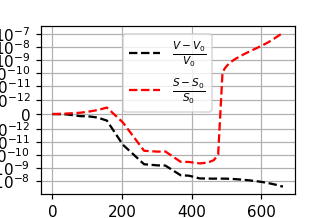

In [570]:
%matplotlib notebook
Vol0, Sqr0 = get_VolSqr(Pfur_init, Zfur_init)
plt.figure(figsize=(3,2))
plt.grid()
Vol_ar=[]
Sqr_ar=[]
for j in range(len(sol_t)):
    #print(j)
    P_fur_j,Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])
    Vol,Sqr = get_VolSqr(P_fur_j, Z_fur_j)
    Vol_ar.append(Vol)
    Sqr_ar.append(Sqr)
Vol_ar=np.array(Vol_ar)
Sqr_ar=np.array(Sqr_ar)   
plt.plot(sol_t, Vol_ar/Vol0-1,'--', color='k', label=r'$\frac{V-V_0}{V_0}$')
plt.plot(sol_t, Sqr_ar/Sqr0-1,'--', color='r', label=r'$\frac{S-S_0}{S_0}$')

plt.legend()
plt.xlabel(r'$t$')
plt.yscale('symlog', linthresh=1e-12)

In [571]:
dZ_arr = []
R0_arr = []

t_arr = []
En_arr = []

for j in range(len(sol_t)):

    P_fur_j,Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])

    
    P = get_int_field(-P_fur_j*1j)
    Z = get_int_field(Z_fur_j)
    dZ_arr.append(Z[0])
    R0_arr.append(P[N_int//2])
    #plt.scatter(t_j,Z[0]-Z[-1],lw=1.5, label=f't={sol_t[j]:.2f}',color='k')
    t_arr.append(sol_t[j])
   
    
    En_arr.append(get_Energy(P_fur_j,Z_fur_j))
dZ_arr = np.array(dZ_arr)
En_arr = np.array(En_arr)
t_arr = np.array(t_arr)
R0_arr = np.array(R0_arr)

<IPython.core.display.Javascript object>


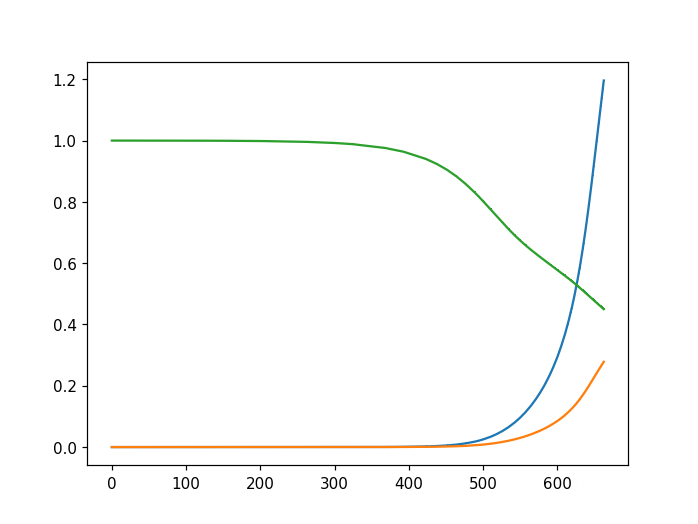

<IPython.core.display.Javascript object>


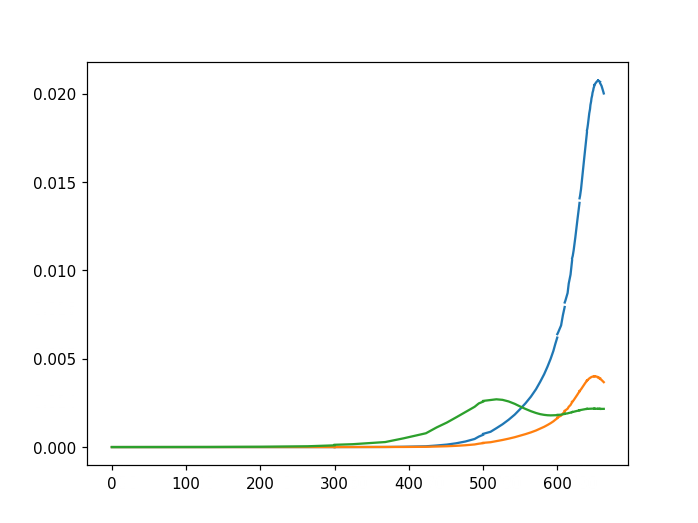

In [572]:
plt.figure()
plt.plot(t_arr, (En_arr-En_arr[0])/En_arr[0],',-')
plt.plot(t_arr, (dZ_arr-dZ_arr[0])/dZ_arr[0],',-')
plt.plot(t_arr, R0_arr,',-')

plt.figure()
plt.plot(t_arr[1:], (En_arr[1:]-En_arr[:-1])/En_arr[0]/(t_arr[1:]-t_arr[:-1]))
plt.plot(t_arr[1:], (dZ_arr[1:]-dZ_arr[:-1])/dZ_arr[0]/(t_arr[1:]-t_arr[:-1]))
plt.plot(t_arr[1:], -(R0_arr[1:]-R0_arr[:-1])/R0_arr[0]/(t_arr[1:]-t_arr[:-1]))

#plt.xscale('log')
#plt.yscale('log')

In [606]:
%matplotlib inline
@interact(j=(0, len(sol_t)-1))
def plot_state_t(j):
    P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur_j)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur_j)
    V = np.sqrt(P1**2+Z1**2)
    plt.figure(figsize=(12,3))
    plt.plot(np.hstack([Z[::-1],Z]),np.hstack([-P[::-1],P]))
    plt.axvline(0, color='k', lw=0.6)
    plt.axhline(0, color='k', lw=0.6)
    plt.axis('scaled')
    plt.ylim(-2.5,2.5)
    plt.xlim(-30,30)
    plt.title(f't={sol_t[j]:.2e}')

interactive(children=(IntSlider(value=64, description='j', max=128), Output()), _dom_classes=('widget-interact…

<IPython.core.display.Javascript object>


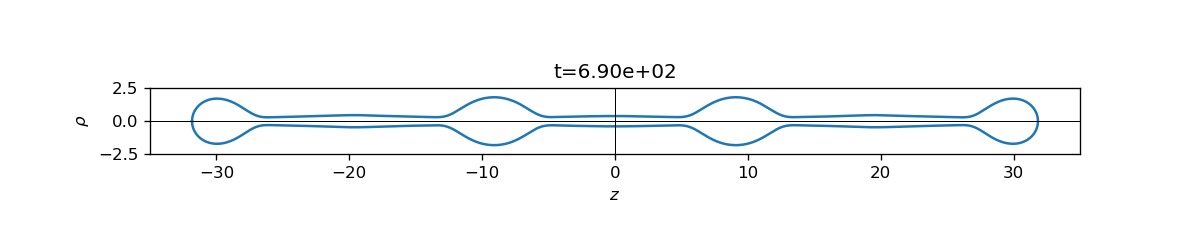

interactive(children=(IntSlider(value=75, description='j', max=151), Output()), _dom_classes=('widget-interact…

In [75]:
%matplotlib notebook

P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,-1])
P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur_j)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur_j)
V = np.sqrt(P1**2+Z1**2)

plt.figure(figsize=(10,2))
ax=plt.gca()
line, =plt.plot(np.hstack([Z[::-1],Z]),np.hstack([-P[::-1],P]))
plt.axvline(0, color='k', lw=0.6)
plt.axhline(0, color='k', lw=0.6)
plt.axis('scaled')
plt.ylim(-2.5,2.5)
plt.xlim(-35,35)
plt.xlabel(r'$z$');plt.ylabel(r'$\rho$')
@interact(j=(0, len(sol_t)-1))
def plot_state_t(j):
    P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])

    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur_j)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur_j)
    line.set_xdata(np.hstack([Z[::-1],Z]));line.set_ydata(np.hstack([-P[::-1],P]));
    
    ax.set_title(f't={sol_t[j]:.2e}')

<IPython.core.display.Javascript object>


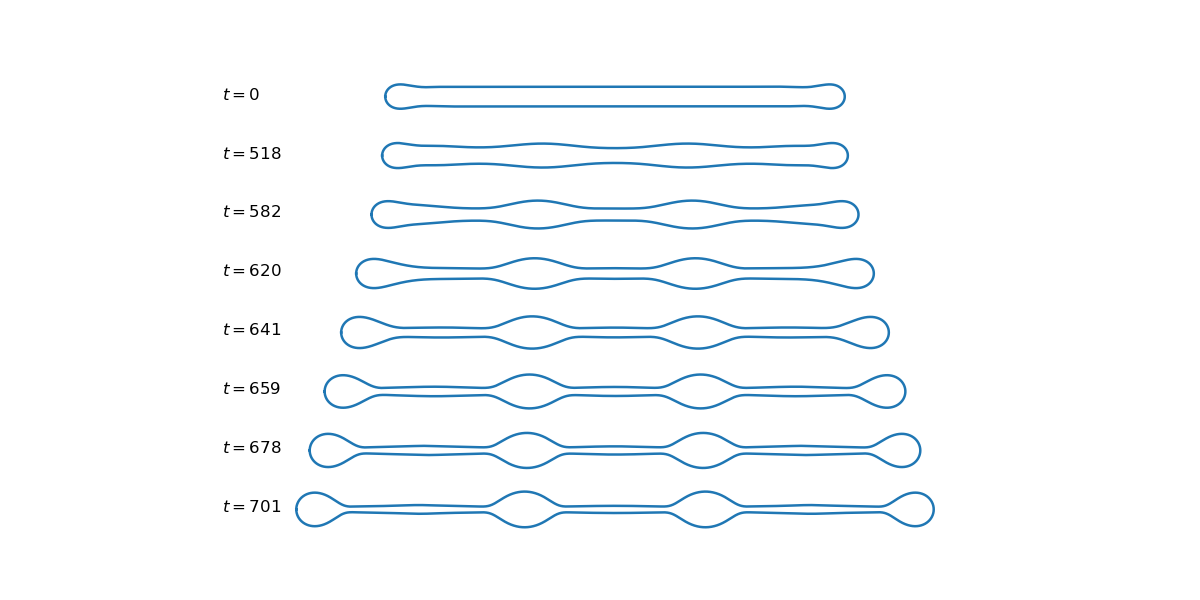

In [80]:
%matplotlib notebook



fig,axs = plt.subplots(8,1,figsize=(10,5), sharex=True, sharey=True)
cur_plot=0
axs[cur_plot].axis('scaled')


for j in [0,30, 39, 60, 86,110,130,150]:
    P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])
    P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur_j)
    Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur_j)
    V = np.sqrt(P1**2+Z1**2)
    axs[cur_plot].plot(np.hstack([Z[::-1],Z]),np.hstack([-P[::-1],P]))
    axs[cur_plot].axis('scaled')
    #xs[cur_plot].xaxis.set_visible(False)
    #xs[cur_plot].yaxis.set_visible(False)
    axs[cur_plot].axis('off')
    axs[cur_plot].text(-40,-0.3,fr'$t={sol_t[j]:.0f}$', rotation='horizontal')
    cur_plot +=1
#plt.axvline(0, color='k', lw=0.6)
#plt.axhline(0, color='k', lw=0.6)
axs[0].set_ylim(-2.5,2.5)
axs[0].set_xlim(-35,35)

plt.savefig('series_plus.png', bbox_inches="tight", pad_inches = 0, dpi=1000, transparent=True)

<IPython.core.display.Javascript object>


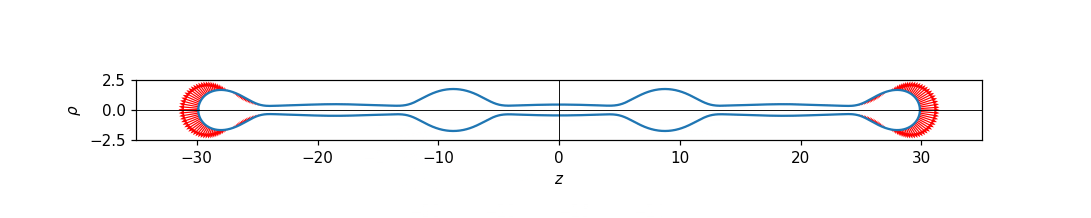

In [608]:
P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,-1])
P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur_j)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur_j)
V = np.sqrt(P1**2+Z1**2)
l_rho = -Z1/V;l_z = P1/V;
force_gamma_rho = l_rho*force_gamma; force_gamma_z = l_z*force_gamma; 

plt.figure(figsize=(10,2))
ax=plt.gca()
Z_plot = np.hstack([Z[::-1],Z]);P_plot = np.hstack([-P[::-1],P])
line, =plt.plot(Z_plot,P_plot)
plt.axvline(0, color='k', lw=0.6)
plt.axhline(0, color='k', lw=0.6)
plt.axis('scaled')
plt.ylim(-2.5,2.5)
plt.xlim(-35,35)
plt.xlabel(r'$z$');plt.ylabel(r'$\rho$')

force_Z_plot = np.hstack([force_gamma_z[::-1],force_gamma_z]);force_P_plot = np.hstack([-force_gamma_rho[::-1],force_gamma_rho])
Qnow = ax.quiver(Z_plot[::10],P_plot[::10], force_Z_plot[::10],force_P_plot[::10], color='red', 
                 units='xy', scale=2, width=0.1, headwidth=3., headlength=4.)
#Qnow = ax.quiver(Z,P, force_gamma_z,force_gamma_rho, color='red')
#qk = ax.quiverkey(Qnow, 0.3, 0.5, 10, r'$f_\gamma=10$', labelpos='E',
#                  coordinates='figure')

<IPython.core.display.Javascript object>


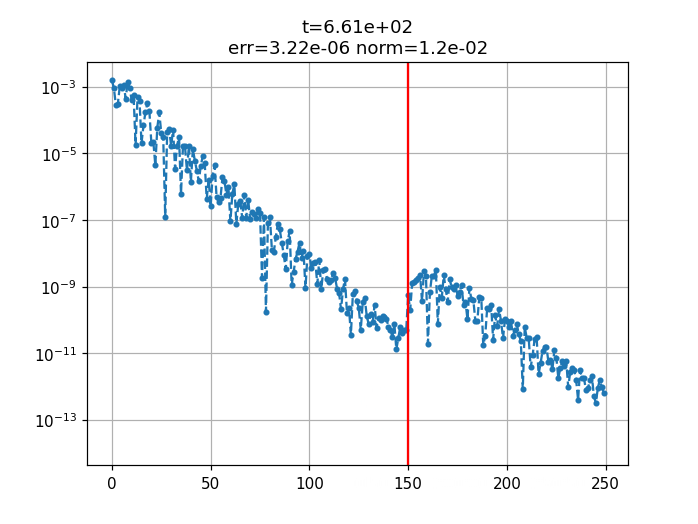

interactive(children=(IntSlider(value=64, description='j', max=128), Output()), _dom_classes=('widget-interact…

In [575]:
%matplotlib notebook
plt.figure()
ax=plt.gca()
P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,-1])

line,=plt.plot(abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[::2],'.--')

#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')


#plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[1])[1::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')
plt.axvline(N//2, color='red')
plt.yscale('log')
plt.grid()
@interact(j=(0, len(sol_t)-1))
def plot_state_t(j):
    P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])
    ydata=abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[::2]
    line.set_ydata(ydata)
    err = 1- ydata[:N//2].sum()/ydata.sum()
    ax.set_title(f't={sol_t[j]:.2e}'+'\n'+f'err={err:.2e}'+f' norm={ydata.sum():.1e}')
    #plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')
    
    
    #plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[1])[1::2],'.--')
    #plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')


In [592]:
N_old=200
t_goal_arr = np.linspace(0, t_max, 200)
norm_rho_arr = [];err_rho_arr = [];norm_z_arr = [];err_z_arr = [];
t_got_arr = []
for j in tqdm(range(len(t_goal_arr))):
    j = np.argmin(abs(t_goal_arr[j]-sol_t))
    
    P_fur_j,Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])
    
    P = get_int_field(-P_fur_j*1j);    Z = get_int_field(Z_fur_j)
    vel_ = get_corr_velo_projects_full(P_fur_j, Z_fur_j)
    ydata = abs(vel_[0][::2])**2
    norm = np.sqrt(ydata.sum());err = np.sqrt(ydata[N//2:].sum()/ydata.sum())
    norm_rho_arr.append(norm);err_rho_arr.append(err)
    
    ydata = abs(vel_[1][1::2])**2
    norm = np.sqrt(ydata.sum());err = np.sqrt(ydata[N//2:].sum()/ydata.sum())
    norm_z_arr.append(norm);err_z_arr.append(err)
    
    t_got_arr.append(sol_t[j])

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


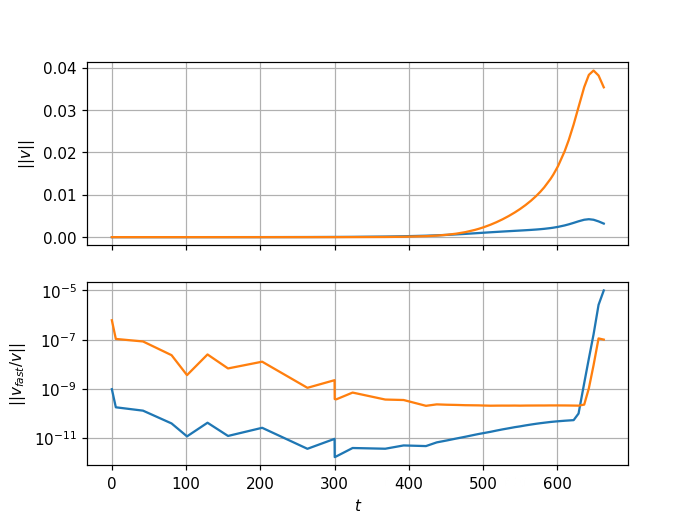

In [605]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(t_got_arr, norm_rho_arr)
axs[0].plot(t_got_arr, norm_z_arr)
axs[0].grid()
axs[1].plot(t_got_arr, err_rho_arr)
axs[1].plot(t_got_arr, err_z_arr)
axs[1].grid()
axs[1].set_xlabel(r'$t$')
axs[1].set_ylabel(r'$||v_{fast}/v||$')
axs[0].set_ylabel(r'$||v||$')
axs[1].set_yscale('log')

In [599]:
sol_t[112]

657.6763594889408

### State analys

In [648]:
P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym([ 
  4.73698554e-01,  1.16951061e+01,  1.31913165e-01,  1.30998670e+00,
  2.96650910e-01,  4.20512978e-01,  1.24465157e-01,  2.23019941e-01,
  2.47905234e-01,  1.22865743e-01,  5.00773294e-02,  8.17823287e-02,
  1.08067060e-01,  5.79128662e-02,  4.54338114e-03,  3.42368749e-02,
  3.67217289e-02,  2.88116260e-02,  9.15715520e-03,  1.23385408e-02,
  1.60439501e-02,  1.39019856e-02,  1.51448626e-02,  4.53969693e-03,
  4.06265520e-03,  7.16242648e-03,  7.80607998e-03,  2.60135389e-03,
 -1.93448771e-03,  3.25251080e-03,  1.77654000e-03,  1.49312953e-03,
 -4.60179082e-04,  6.63968703e-04,  2.82268639e-04,  7.09496583e-04,
  1.26336380e-03, -2.36530595e-04, -4.06329338e-04,  4.57343938e-04,
  8.04130239e-04, -1.40056288e-04, -5.18160021e-04,  2.53888308e-04,
  1.56972470e-04,  1.30375084e-05, -1.10487841e-05, -7.97236707e-06,
 -6.92749952e-05,  5.49082980e-05,  2.32856642e-04, -1.01650762e-04,
 -1.54710503e-04,  7.17434924e-05,  1.21727577e-04, -5.17217107e-05,
 -9.58155077e-05,  4.25188005e-05,  7.44051446e-06, -2.55455198e-06,
  2.09747874e-05, -8.84023037e-06, -3.38272673e-05,  1.56812855e-05,
  5.25768873e-05, -2.51315481e-05, -3.77700094e-05,  1.83769287e-05,
  2.21603226e-05, -1.21838381e-05, -1.32428616e-05,  7.89522189e-06,
 -2.93819820e-06,  3.48025254e-07,  1.03563724e-05, -4.21675327e-06,
 -1.09718822e-05,  5.22552637e-06,  1.22075544e-05, -6.53835582e-06,
 -8.46883425e-06,  4.81508981e-06,  3.66806833e-06, -2.62930296e-06,
 -1.03924745e-06,  1.23562268e-06, -2.01809760e-06,  6.56772822e-07,
  3.50955594e-06, -1.62708620e-06, -3.18926636e-06,  1.71193205e-06,
  2.79101051e-06, -1.71706837e-06, -1.72414778e-06,  1.18453697e-06,
  4.38021325e-07, -4.99202576e-07,  2.77119620e-07,  5.96972666e-08,
 -8.25501250e-07,  3.58042795e-07,  1.05391161e-06, -5.67762770e-07,
 -8.57931101e-07,  5.26522743e-07,  6.07933877e-07, -4.37117893e-07,
 -2.99164780e-07,  2.63564089e-07, -2.55363939e-08, -6.19792868e-08,
  1.99713418e-07, -6.34249255e-08, -2.84374597e-07,  1.49628327e-07,
  2.94807522e-07, -1.82440185e-07, -2.14386226e-07,  1.51074391e-07,
  1.19982170e-07, -1.04032492e-07, -3.25781556e-08,  4.83585357e-08,
 -4.47612522e-08,  7.19903299e-09,  8.19597586e-08, -3.94670179e-08,
 -8.87173163e-08,  5.42217016e-08,  7.75860001e-08, -5.46248518e-08,
 -4.89438549e-08,  4.00242891e-08,  1.87310533e-08, -2.18593300e-08,
  4.83453796e-09,  4.89500046e-09, -2.19106464e-08,  9.38204916e-09,
  2.81483199e-08, -1.65683008e-08, -2.56583922e-08,  1.77867749e-08,
  1.90379384e-08, -1.52165780e-08, -9.66083463e-09,  9.55380009e-09,
  8.69308566e-10, -3.47514251e-09,  5.05942828e-09, -1.34335225e-09,
 -8.36337290e-09,  4.68404969e-09,  8.74873811e-09, -5.89172144e-09,
 -6.90847556e-09,  5.35877655e-09,  4.22022287e-09, -3.87944646e-09,
 -1.35633618e-09,  1.94229041e-09, -1.03885871e-09, -1.00508151e-10,
  2.35805886e-09, -1.12798523e-09, -2.86464349e-09,  1.80371732e-09,
  2.51473690e-09, -1.81502942e-09, -1.74904546e-09,  1.50627847e-09,
  7.61228384e-10, -8.42892264e-10,  2.14857470e-11,  3.62751557e-10,
 -7.06758758e-10,  1.50285762e-10,  8.79156868e-10, -3.75876386e-10,
 -1.00330452e-09,  5.14598457e-10,  7.00430202e-10, -3.62025051e-10,
 -4.94660634e-10,  4.91380387e-10,  1.48188720e-10, -2.09178792e-10,
  6.47286379e-11,  2.49537908e-10, -2.39114003e-10, -4.04585672e-10,
  2.46902683e-10,  3.10694516e-11, -3.09691566e-10, -5.49285091e-10,
  1.45057741e-10,  2.07654826e-10, -1.76899537e-10, -1.35240911e-11])

In [651]:
P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym([ 
  4.52142770e-01,  1.21420635e+01,  1.13524066e-01,  1.35981256e+00,
  2.74889981e-01,  4.22950318e-01,  1.22908205e-01,  2.26829732e-01,
  2.75161877e-01,  1.21239051e-01,  6.93833300e-02,  8.46472199e-02,
  1.40731523e-01,  6.10640379e-02,  1.08173409e-02,  3.83082124e-02,
  4.26374763e-02,  3.29946317e-02, -7.07223412e-03,  1.34242231e-02,
  9.73378752e-03,  1.49470463e-02,  7.20159041e-03,  2.02931839e-03,
  4.46353581e-03,  6.20812523e-03,  1.19973063e-02,  1.03799208e-04,
 -2.56918797e-04,  3.21898612e-03,  4.71506402e-03,  1.04326201e-03,
 -2.96475361e-03,  1.40178958e-03, -3.58804794e-04,  1.03792676e-03,
 -5.17874896e-04, -2.08129994e-04, -5.91661649e-04,  4.39180497e-04,
  1.69193668e-03, -7.00451964e-04, -3.88201727e-04,  2.38540425e-04,
  1.05208579e-03, -2.63256933e-04, -5.69457668e-04,  2.10693229e-04,
 -8.84362247e-05,  1.17702604e-04, -1.45634353e-04,  2.58914697e-06,
 -2.77241764e-04,  1.28947518e-04,  3.55146117e-04, -1.69290648e-04,
 -1.41450458e-04,  5.99804970e-05,  2.78199057e-04, -1.13787200e-04,
 -1.08622768e-04,  4.40165862e-05, -1.24741848e-05,  1.05567520e-05,
 -2.37209741e-05,  8.09551928e-06, -9.59293048e-05,  4.51697286e-05,
  8.64308514e-05, -3.98231829e-05, -4.94702246e-05,  2.39297067e-05,
  7.68048441e-05, -3.75535618e-05, -2.04629229e-05,  1.03089775e-05,
 -2.05024868e-07, -2.19696318e-06, -2.80645913e-07,  1.30612962e-06,
 -3.14501425e-05,  1.50334174e-05,  2.28308309e-05, -1.04950476e-05,
 -1.76924820e-05,  9.77358795e-06,  2.11748462e-05, -1.16503259e-05,
 -3.95549254e-06,  2.82302263e-06,  5.59808164e-07, -1.79637417e-06,
  2.12665467e-06, -4.71433460e-07, -1.00704785e-05,  4.89500316e-06,
  6.58688764e-06, -3.19004125e-06, -6.26074693e-06,  3.82856064e-06,
  5.83132541e-06, -3.54089924e-06, -8.04042655e-07,  9.06251211e-07,
  2.05522464e-07, -7.43107171e-07,  1.35132882e-06, -5.00142074e-07,
 -3.20578622e-06,  1.59367213e-06,  2.06554857e-06, -1.09951394e-06,
 -2.17858106e-06,  1.43840234e-06,  1.60322420e-06, -1.07292630e-06,
 -1.79627390e-07,  3.21858492e-07,  2.03771376e-08, -2.40223065e-07,
  6.36589692e-07, -2.80333535e-07, -1.02617541e-06,  5.27176703e-07,
  6.93570703e-07, -4.10606553e-07, -7.44531183e-07,  5.22456016e-07,
  4.40788502e-07, -3.28027741e-07, -4.46262519e-08,  1.17892730e-07,
 -2.50101693e-08, -6.27232922e-08,  2.66353491e-07, -1.29361482e-07,
 -3.33544244e-07,  1.79114223e-07,  2.43993736e-07, -1.58805715e-07,
 -2.50201851e-07,  1.84858486e-07,  1.21590331e-07, -1.02008278e-07,
 -1.12866240e-08,  4.26774910e-08, -2.35074840e-08, -1.12946511e-08,
  1.04941838e-07, -5.40895428e-08, -1.11079994e-07,  6.24051566e-08,
  8.81971648e-08, -6.16253441e-08, -8.29480462e-08,  6.38211933e-08,
  3.38691778e-08, -3.24915050e-08, -2.00314109e-09,  1.52947910e-08,
 -1.41474916e-08, -1.47721953e-10,  4.05993373e-08, -2.06631543e-08,
 -3.82101369e-08,  2.09787840e-08,  3.28883776e-08, -2.36533021e-08,
 -2.73875005e-08,  2.06060481e-08,  1.01231041e-08, -1.15210043e-08,
  7.55128100e-10,  6.28362613e-09, -6.57024975e-09, -4.78984057e-10,
  1.71072002e-08, -5.55774004e-09, -1.32661127e-08,  3.90924851e-09,
  1.44275593e-08, -9.12497833e-09, -9.89870370e-09,  3.84432155e-09,
  4.72984115e-09, -7.35785818e-09, -1.17916835e-09,  6.00124663e-09,
 -1.94264602e-09, -2.83232072e-09,  5.19606950e-09,  7.49451214e-09,
 -3.71648023e-09, -7.07370740e-10,  5.78793055e-09,  7.72049440e-09,
 -2.46616658e-09, -3.88764143e-09,  3.13007251e-09,  1.14522703e-09,])

In [654]:
P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym([ 
  4.33271367e-01,  1.25816189e+01,  9.93989107e-02,  1.40874078e+00,
  2.52582020e-01,  4.24412349e-01,  1.17098520e-01,  2.30120927e-01,
  2.91801571e-01,  1.18271766e-01,  7.93024539e-02,  8.69477026e-02,
  1.68189280e-01,  6.32251769e-02,  2.57673773e-02,  4.25933577e-02,
  5.77289051e-02,  3.78017035e-02, -1.69731908e-02,  1.62328315e-02,
  7.67706512e-03,  1.77660091e-02, -5.55461217e-03,  9.51177484e-04,
 -4.92440927e-04,  5.77378201e-03,  1.05957960e-02, -3.07479054e-03,
  2.01735980e-03,  2.26614266e-03,  1.04389416e-02, -7.87389958e-04,
 -1.87727918e-03,  1.83008936e-03,  1.80368348e-03,  1.34474482e-03,
 -3.48570411e-03,  7.34918963e-04, -2.04368509e-03,  1.10624583e-03,
 -1.44816383e-04, -7.33631460e-04, -8.59898945e-04,  2.25983626e-04,
  2.41073993e-03, -1.02074650e-03, -6.80456883e-05,  6.29650940e-05,
  1.35895378e-03, -2.60281452e-04, -5.54802264e-04,  2.24989485e-04,
 -4.15119185e-04,  3.11301071e-04, -3.76128277e-04,  5.85525691e-05,
 -6.29902018e-04,  2.47292629e-04,  4.22974654e-04, -2.34058644e-04,
 -1.12150751e-04,  2.62232009e-05,  5.66146120e-04, -2.23698755e-04,
 -1.30771767e-06,  1.41566757e-06,  5.21153796e-05,  3.51750518e-06,
 -9.11495518e-05,  3.65898404e-05, -2.50377604e-04,  1.15378629e-04,
  3.00131462e-05, -1.94460615e-05, -1.27971771e-04,  5.58544539e-05,
  1.64853740e-04, -7.63673619e-05,  1.78815085e-05, -7.75979489e-06,
  8.22904741e-05, -3.89822379e-05,  1.15451005e-05, -5.06743066e-06,
 -6.20844140e-05,  2.78047675e-05, -4.08024182e-06,  2.30682858e-06,
 -7.52114030e-05,  3.72110838e-05,  3.17239343e-05, -1.49009428e-05,
 -8.89260870e-06,  6.75947658e-06,  3.79996258e-05, -2.02060880e-05,
  1.78791414e-05, -8.14323987e-06, -4.34846913e-06, -2.67751305e-07,
  5.29536911e-06, -2.92092265e-06, -2.96915114e-05,  1.48109147e-05,
  3.21425007e-06, -1.46300366e-06, -1.34992435e-05,  8.67686493e-06,
  1.02921090e-05, -5.58210723e-06,  6.57156552e-06, -2.33392757e-06,
  4.04541974e-06, -3.27173461e-06,  6.88079602e-06, -3.82561609e-06,
 -8.00065491e-06,  3.60611948e-06,  1.04544699e-06, -8.44344653e-07,
 -8.10503821e-06,  4.97121308e-06,  1.20463646e-06, -6.91863707e-07,
  2.30455342e-07,  6.95370939e-07,  1.90426194e-06, -1.32653854e-06,
  3.89356893e-06, -2.03618005e-06, -1.18211270e-06,  2.78710716e-07,
  1.59225382e-06, -1.16101247e-06, -3.18172260e-06,  1.84608966e-06,
 -1.79735143e-07, -2.27228351e-08, -1.12902315e-06,  1.03054522e-06,
  1.61579695e-07, -1.27710694e-07,  1.34340993e-06, -5.68587704e-07,
  1.65789133e-08, -1.21672632e-07,  1.25062008e-06, -8.26269699e-07,
 -8.50647401e-07,  4.40364778e-07,  6.79970861e-08, -1.76703705e-07,
 -7.49680037e-07,  5.58957751e-07, -2.45245387e-07,  1.11070130e-07,
  2.25444222e-07,  1.88934570e-08, -3.80847661e-08,  1.21959977e-08,
  6.37514790e-07, -3.59139162e-07, -1.39966383e-07,  5.10945946e-08,
  2.25155294e-07, -2.22791012e-07, -2.79181661e-07,  1.75619013e-07,
 -1.48454110e-07,  1.20622040e-08, -4.50964703e-08,  1.09232083e-07,
 -1.14230556e-07,  5.12201172e-08,  2.51635533e-07, -6.79630935e-08,
 -2.03296659e-08,  1.41318620e-08,  2.23257244e-07, -1.51578941e-07,
 -5.79204267e-08,  1.84696582e-08,  1.26786736e-08, -1.23478496e-07,
 -6.33456987e-08,  6.49147480e-08, -7.60770525e-08, -7.44678792e-08,
  3.39984966e-08,  1.02681253e-07, -3.28057072e-08,  8.25994871e-09,
  9.99807152e-08,  9.05603164e-08, -6.06227719e-10,  1.46362340e-08,
  6.56540923e-08,  4.54240910e-08, -8.52327428e-09, -2.13711420e-08,])

In [657]:
P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym([ 
  4.25781585e-01,  1.27669503e+01,  9.46306979e-02,  1.43002112e+00,
  2.43825104e-01,  4.25716590e-01,  1.14240830e-01,  2.31791571e-01,
  2.96878359e-01,  1.16832607e-01,  8.04996376e-02,  8.78403594e-02,
  1.76785983e-01,  6.37557231e-02,  3.35916992e-02,  4.42339295e-02,
  6.52503855e-02,  3.97453060e-02, -1.97049271e-02,  1.77302467e-02,
  9.80938819e-03,  1.93731106e-02, -1.01368652e-02,  1.06339940e-03,
 -3.67011895e-03,  5.98220395e-03,  7.97309363e-03, -4.25870880e-03,
  2.15687558e-03,  1.83331726e-03,  1.20863987e-02, -1.93482316e-03,
 -7.15574042e-04,  1.72467753e-03,  3.97513589e-03,  1.18488449e-03,
 -3.92394524e-03,  1.17360594e-03, -2.09788685e-03,  1.48771766e-03,
 -1.61858951e-03, -4.36861787e-04, -1.66679231e-03,  4.33219554e-04,
  2.18868975e-03, -1.25211036e-03, -2.43494807e-06, -4.45535131e-05,
  2.29672679e-03, -6.23788843e-04, -2.79820777e-04,  1.81112229e-04,
  1.04784519e-04,  2.44392620e-04, -6.86802047e-04,  2.06871368e-04,
 -9.15003640e-04,  4.03364933e-04,  5.85277562e-05, -1.41061016e-04,
 -3.79906342e-04,  1.05658334e-04,  7.32800631e-04, -3.24678557e-04,
  7.76623659e-05, -4.11556701e-05,  4.03753121e-04, -1.26857069e-04,
 -4.17218917e-05,  2.45188784e-05, -2.11479968e-04,  1.15873287e-04,
 -9.64873173e-05,  3.39684959e-05, -2.97520592e-04,  1.27774333e-04,
  1.15171850e-04, -5.95901315e-05, -4.39583362e-05,  1.58701916e-05,
  1.98968211e-04, -9.01474583e-05,  6.02386765e-05, -2.63133560e-05,
  2.82446106e-05, -1.23636201e-05,  5.08916759e-08,  4.85649773e-07,
 -1.15571314e-04,  5.37316664e-05, -6.52820054e-06,  3.03886267e-06,
 -7.44932719e-05,  3.73319023e-05,  4.74817957e-05, -2.29527812e-05,
  1.61880355e-05, -5.40736097e-06,  4.17881492e-05, -2.24358994e-05,
  2.80486602e-05, -1.35949534e-05, -1.88785176e-05,  6.92642974e-06,
  6.38326097e-07, -9.22924201e-07, -4.18649363e-05,  2.14576419e-05,
  1.13389108e-06, -3.69155149e-07, -1.12154782e-05,  8.10975015e-06,
  1.39982986e-05, -7.46585878e-06,  1.46485285e-05, -6.44679301e-06,
  4.94997585e-06, -4.00133978e-06,  9.50653736e-06, -5.57840846e-06,
 -1.24225739e-05,  5.76711879e-06, -1.23077558e-06,  1.54360450e-07,
 -1.15697685e-05,  7.08306224e-06,  2.43671043e-07, -4.45910139e-08,
  1.66336142e-06,  3.01984143e-07,  3.25513635e-06, -2.00278047e-06,
  6.89289165e-06, -3.65725573e-06, -9.76869537e-07, -4.43242474e-08,
  2.13579045e-06, -1.71090185e-06, -4.92319409e-06,  2.68039147e-06,
 -1.33391424e-06,  5.33309511e-07, -2.14665404e-06,  1.80190334e-06,
 -1.22052216e-07,  1.49381052e-07,  2.28923620e-06, -8.35786831e-07,
  5.92120971e-07, -4.53483305e-07,  2.41360911e-06, -1.49752179e-06,
 -9.56504314e-07,  2.95976016e-07, -1.43944830e-09, -3.20803448e-07,
 -1.52522026e-06,  9.27507654e-07, -8.20457844e-07,  3.99233398e-07,
  2.88466900e-08,  3.83240951e-07, -8.01995305e-08,  1.27196343e-07,
  1.22351784e-06, -4.04552063e-07,  5.13063557e-08, -1.19020127e-07,
  6.29809505e-07, -4.73601528e-07, -5.45341350e-07,  1.14081185e-07,
 -3.88909828e-07, -6.75975561e-08, -5.57502232e-07,  4.23264806e-07,
 -4.85663781e-07,  2.52257534e-07,  9.41757156e-08,  5.24953606e-07,
 -6.24899451e-08,  9.90709728e-08,  4.34395878e-07,  2.94968562e-07,
  1.30317518e-08, -8.91384172e-08,  1.51587852e-07, -2.57099301e-07,
 -1.91566937e-07, -3.55308824e-07, -1.97878236e-07, -2.41239984e-07,
 -2.28773169e-07, -2.72753576e-07, -2.18583543e-07, -2.50672229e-07,
 -7.40638185e-08,  1.03295254e-07, -7.25047040e-08, -4.54642724e-08])

In [600]:
t_j=t_max
j=np.argmin(np.abs(t_j-sol_t))
P_fur_j, Z_fur_j = get_PZ_fur_from_pz_sym(sol_y[:,j])

<IPython.core.display.Javascript object>


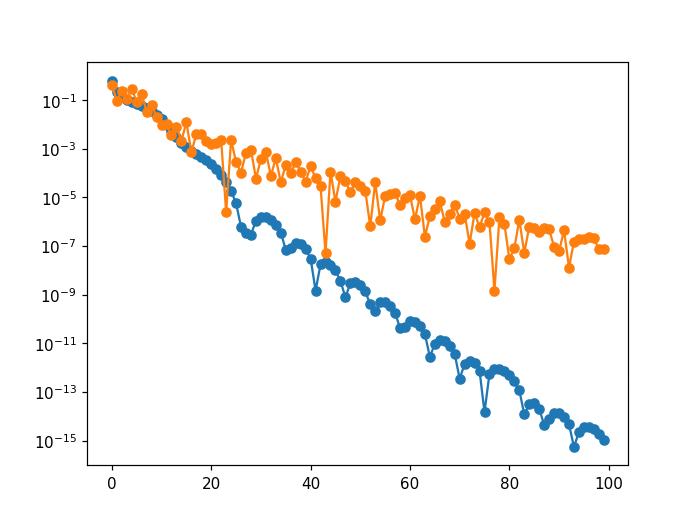

In [645]:
plt.figure()
plt.plot(abs(Pfur_init)[1::2],'o-')
plt.plot(abs(P_fur_j)[1::2],'o-')

#plt.plot(abs(Zfur_0)[1::2],'.--')
#plt.plot(abs(Z_fur_j)[1::2],'.--')
plt.yscale('log')

In [658]:
P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur_j)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur_j)
V = np.sqrt(P1**2+Z1**2)

H, force = get_H_force(P,P1,P2,P3,P4,Z,Z1,Z2,Z3,Z4) 

In [659]:
plt.plot(np.hstack([Z[::-1],Z]),np.hstack([-P[::-1],P]))

<IPython.core.display.Javascript object>


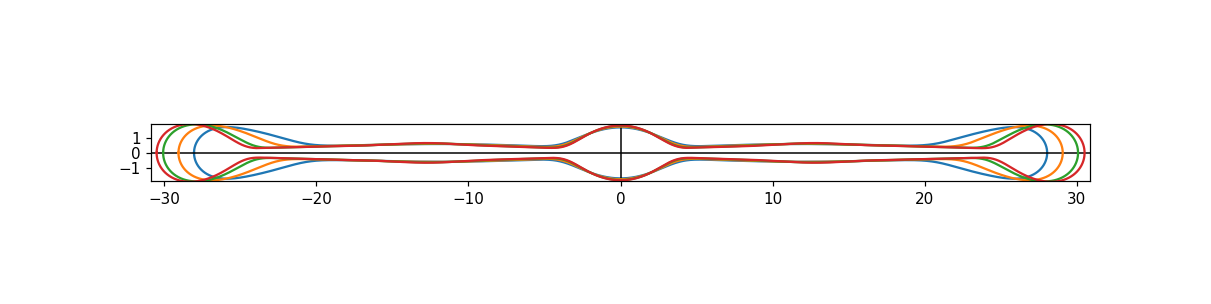

In [650]:
plt.figure(figsize=(12,3))
plt.plot(np.hstack([Z[::-1],Z]),np.hstack([-P[::-1],P]))
plt.axvline(0, color='k', lw=1)
plt.axhline(0, color='k', lw=1)

plt.axis('scaled');

<IPython.core.display.Javascript object>


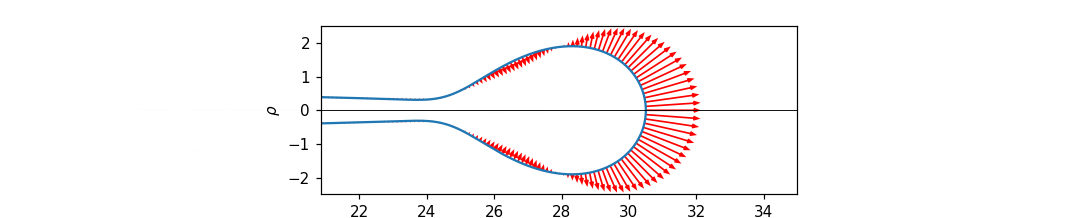

In [647]:
P, P1,P2,P3,P4 = get_int_fields(-1j*P_fur_j)
Z, Z1,Z2,Z3,Z4 = get_int_fields(Z_fur_j)
V = np.sqrt(P1**2+Z1**2)
l_rho = -Z1/V;l_z = P1/V;
force_gamma_rho = l_rho*force_gamma; force_gamma_z = l_z*force_gamma; 

plt.figure(figsize=(10,2))
ax=plt.gca()
Z_plot = np.hstack([Z[::-1],Z]);P_plot = np.hstack([-P[::-1],P])
line, =plt.plot(Z_plot,P_plot)
plt.axvline(0, color='k', lw=0.6)
plt.axhline(0, color='k', lw=0.6)
plt.axis('scaled')
plt.ylim(-2.5,2.5)
plt.xlim(-35,35)
plt.xlabel(r'$z$');plt.ylabel(r'$\rho$')

force_Z_plot = np.hstack([force_gamma_z[::-1],force_gamma_z]);force_P_plot = np.hstack([-force_gamma_rho[::-1],force_gamma_rho])
Qnow = ax.quiver(Z_plot[::10],P_plot[::10], force_Z_plot[::10],force_P_plot[::10], color='red', 
                 units='xy', scale=2, width=0.05, headwidth=3., headlength=4.)
#Qnow = ax.quiver(Z,P, force_gamma_z,force_gamma_rho, color='red')
#qk = ax.quiverkey(Qnow, 0.3, 0.5, 10, r'$f_\gamma=10$', labelpos='E',
#                  coordinates='figure')

<IPython.core.display.Javascript object>


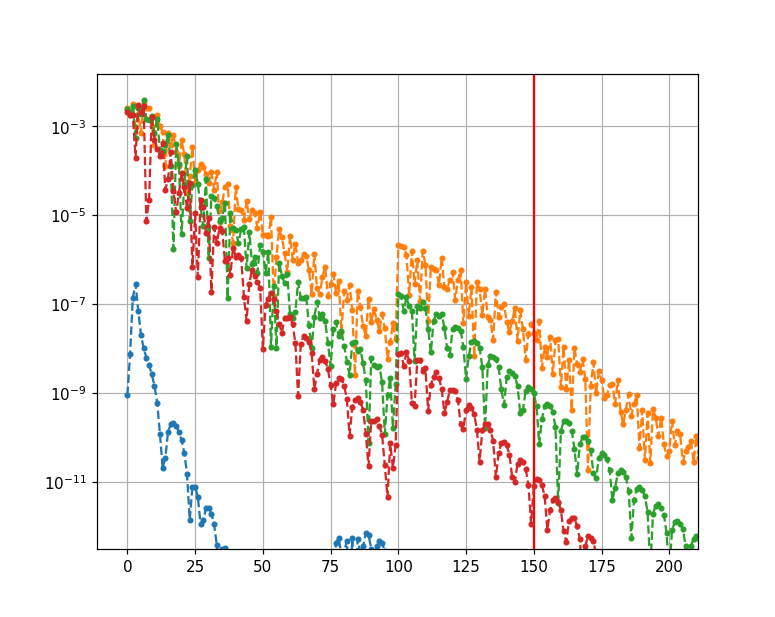

In [628]:
plt.figure()
plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[0])[::2],'.--')
plt.plot(abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[::2],'.--')

#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')


#plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[1])[1::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')
plt.axvline(N//2, color='red')
plt.yscale('log')
plt.grid()

In [632]:
plt.plot(abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[::2],'.--')


<IPython.core.display.Javascript object>


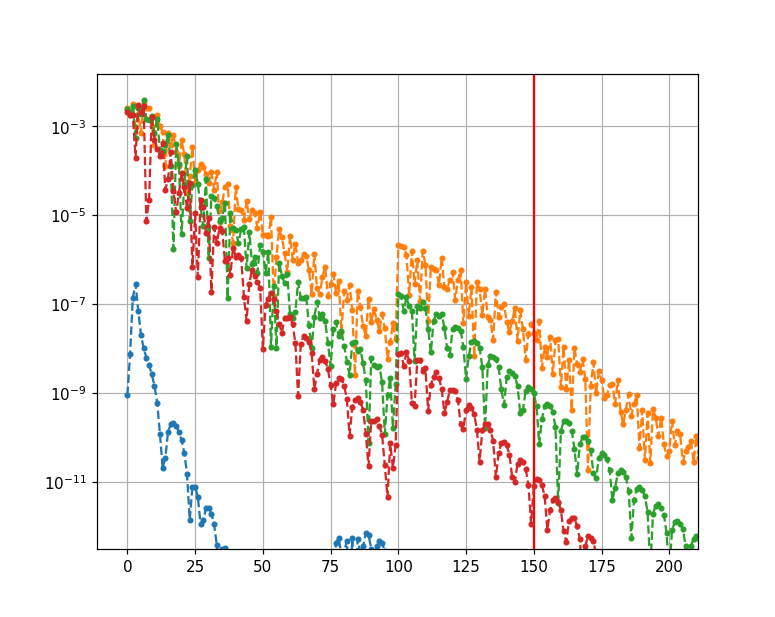

In [628]:
plt.figure()
# plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[0])[::2],'.--')
# plt.plot(abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[::2],'.--')

#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')


plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[1])[1::2],'.--')
plt.plot(abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[1::2],'.--')

plt.axvline(N//2, color='red')
plt.yscale('log')
plt.grid()

<IPython.core.display.Javascript object>


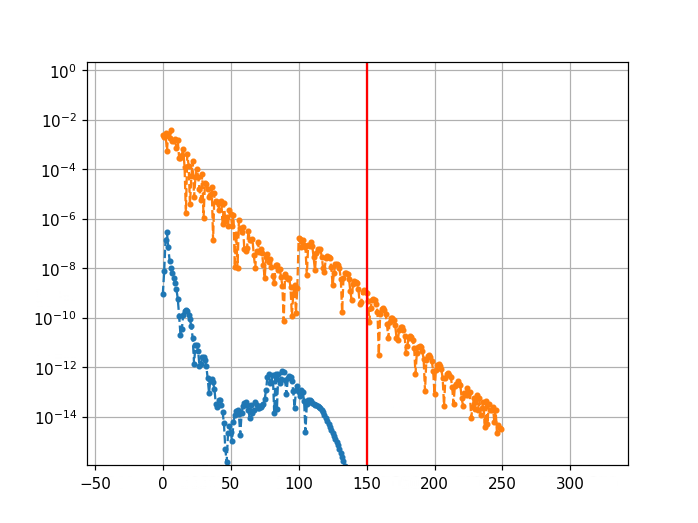

In [621]:
plt.figure()
plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[0])[::2],'.--')
plt.plot(abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[::2],'.--')

#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')


#plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[1])[1::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')
plt.axvline(N//2, color='red')
plt.yscale('log')
plt.grid()

<IPython.core.display.Javascript object>


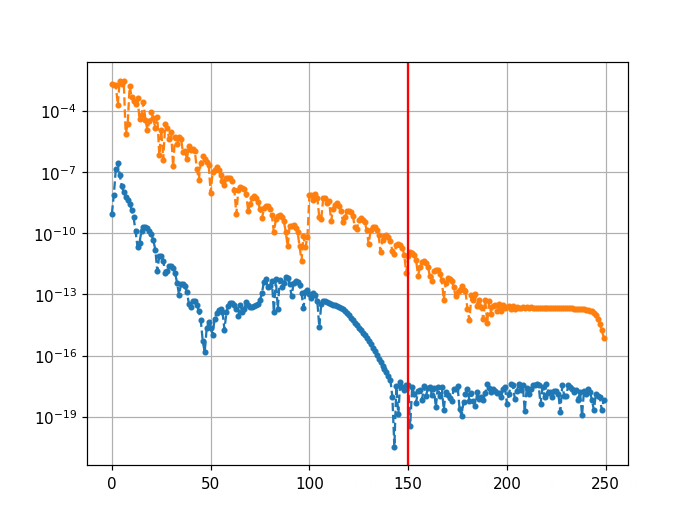

In [615]:
plt.figure()
plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[0])[::2],'.--')
plt.plot(abs(get_corr_velo_projects_full(P_fur_j, Z_fur_j)[0])[::2],'.--')

#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[0])[::2],'.--')


#plt.plot(abs(get_corr_velo_projects_full(Pfur_init, Zfur_init)[1])[1::2],'.--')
#plt.plot(abs(get_normal_velo_projects_full(Pfur_0, Zfur_0)[1])[1::2],'.--')
plt.axvline(N//2, color='red')
plt.yscale('log')
plt.grid()

<IPython.core.display.Javascript object>


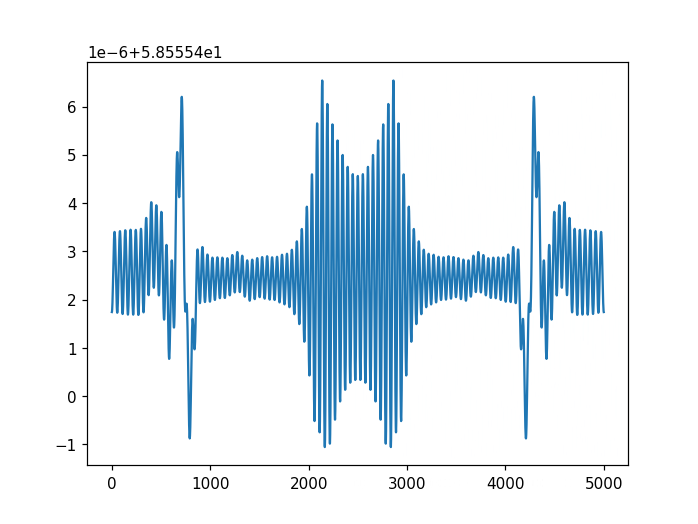

In [616]:
plt.figure()
plt.plot(V)